# Lane Detection 

# Calibration And Undistortion

## Camera Calibration

In [150]:
# Main imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [151]:
from importlib import reload
import utils; reload(utils)
from utils import *

In [152]:
calibration_dir = "camera_cal"
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

### Finding Chessboard Corners

In [153]:
# Let's get all our calibration image paths
cal_imgs_paths = glob.glob(calibration_dir + "/*.jpg")

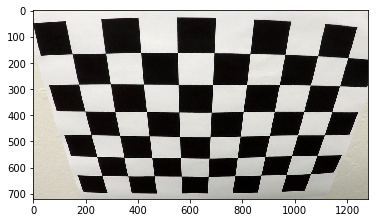

In [154]:
# Let's the first chessboard image to see what it looks like
cal_img_path = cal_imgs_paths[11]
cal_img = load_image(cal_img_path)
plt.imshow(cal_img)

In [155]:
cx = 9
cy = 6

In [156]:
def findChessboardCorners(img, nx, ny):
    """
    Finds the chessboard corners of the supplied image (must be grayscale)
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    return cv2.findChessboardCorners(img, (nx, ny), None)        

In [157]:
def showChessboardCorners(img, nx, ny, ret, corners):
    """
    Draws the chessboard corners of a given image
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    ret and corners should represent the results from cv2.findChessboardCorners()
    """
    c_img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.axis('off')
    plt.imshow(img)

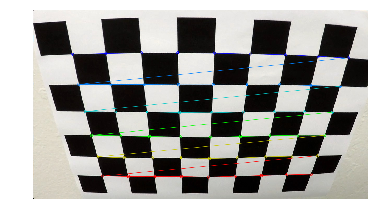

In [158]:
ret, corners = findChessboardCorners(to_grayscale(cal_img), cx, cy)
showChessboardCorners(cal_img, cx, cy, ret, corners)

### Image Undistortion

#### Identifying Image And Object Points

finding the mappings for coordinates of the images in 2D space (i.e. *image points*) to those of the undistorted image in the real-world (i.e. *object points*)

In [159]:
def findImgObjPoints(imgs_paths, nx, ny):
    """
    Returns the objects and image points computed for a set of chessboard pictures taken from the same camera
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    objpts = []
    imgpts = []
    
    # Pre-compute what our object points in the real world should be (the z dimension is 0 as we assume a flat surface)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for img_path in imgs_paths:
        img = load_image(img_path)
        gray = to_grayscale(img)
        ret, corners = findChessboardCorners(gray, nx, ny)
        
        if ret:
            # Found the corners of an image
            imgpts.append(corners)
            # Add the same object point since they don't change in the real world
            objpts.append(objp)
    
    return objpts, imgpts

In [160]:
opts, ipts = findImgObjPoints(cal_imgs_paths, cx, cy)

#### Finding Calibration Matrix

In [161]:
def undistort_image(img, objpts, imgpts):
    """
    Returns an undistorted image
    The desired object and image points must also be supplied to this function
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, to_grayscale(img).shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

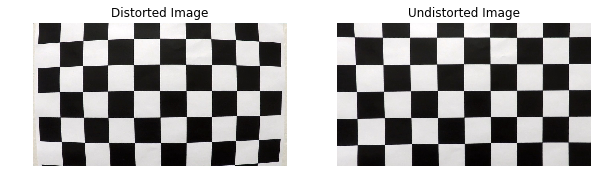

In [162]:
cal_img_example = load_image(cal_imgs_paths[0])
cal_img_undist = undistort_image(cal_img_example, opts, ipts)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(cal_img_example)
ax[0].axis("off")
ax[0].set_title("Distorted Image")

ax[1].imshow(cal_img_undist)
ax[1].axis("off")
ax[1].set_title("Undistorted Image")

plt.show()

#### Undistorting Test Images

In [163]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg")

In [164]:
test_img_names = np.asarray(list(map(lambda img_path: img_path.split("/")[-1].split(".")[0], test_imgs_paths)))
undist_test_img_names = np.asarray(list(map(lambda img_name: "{0}{1}".format("undistorted_", img_name), test_img_names)))

In [165]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))
undist_test_imgs = np.asarray(list(map(lambda img: undistort_image(img, opts, ipts), test_imgs)))

In [166]:
test_img_and_undist = np.asarray(list(zip(test_imgs, undist_test_imgs)))
test_img_and_undist_names = np.asarray(list(zip(test_img_names, undist_test_img_names)))

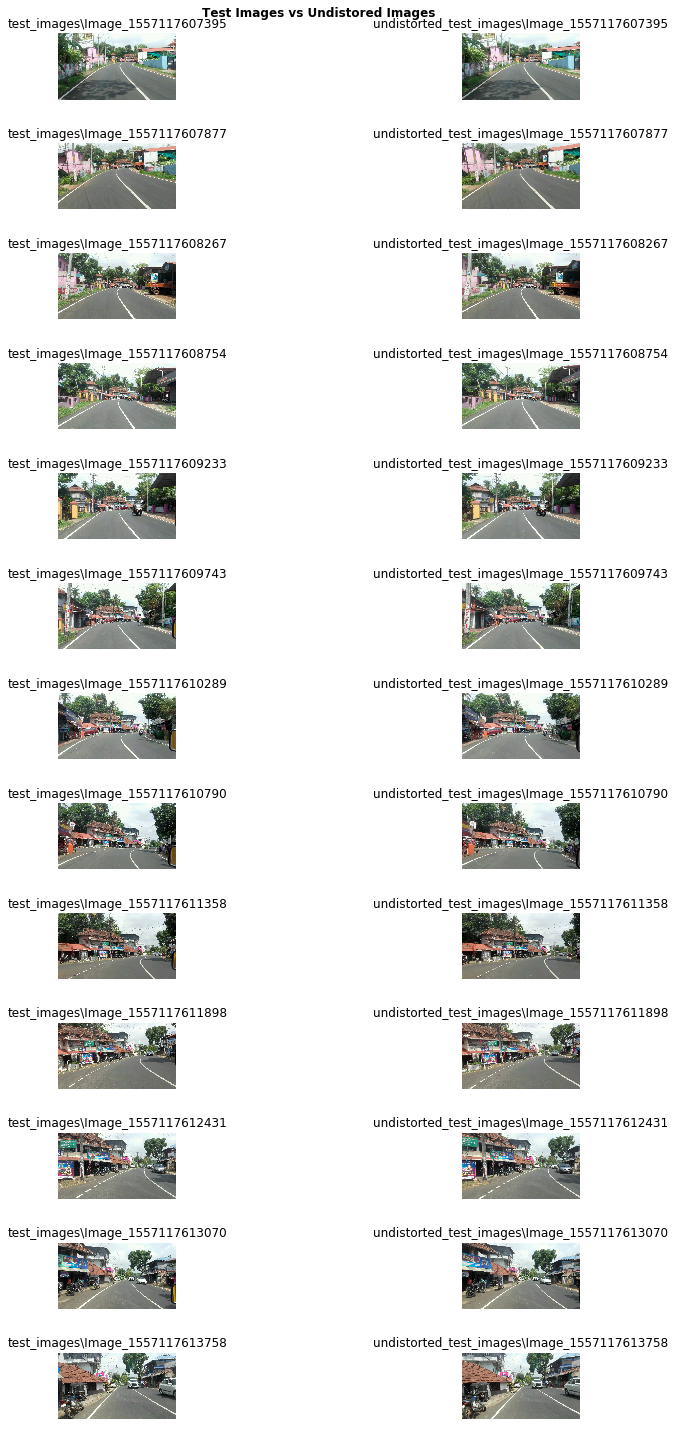

In [167]:
show_image_list(test_img_and_undist, test_img_and_undist_names, "Test Images vs Undistored Images", fig_size=(12, 20), cols=2, show_ticks=False)

## Thresholding

In [168]:
def threshold_img(img, channel, thres=(0, 255)):
    """
    Applies a threshold mask to the input image
    """
    img_ch = img[:,:,channel]
    if thres is None:  
        return img_ch
    
    mask_ch = np.zeros_like(img_ch)
    mask_ch[ (thres[0] <= img_ch) & (thres[1] >= img_ch) ] = 1
    return mask_ch

In [169]:
test_img_path = test_imgs_paths[7]
test_img = load_image(test_img_path)
undistorted_test_img = undistort_image(test_img, opts, ipts)

### Color Thresholding


In [170]:
rgb_comp = np.asarray([[threshold_img(undistorted_test_img, 0, thres=None), threshold_img(undistorted_test_img, 1, thres=None), threshold_img(undistorted_test_img, 2, thres=None)]])
rgb_lbs = np.asarray([["Red Channel", "Green Channel", "Blue Channel"]])

In [171]:
hls_test_img = to_hls(undistorted_test_img)
hls_comp = np.asarray([[threshold_img(hls_test_img, 0, thres=None), threshold_img(hls_test_img, 1, thres=None), threshold_img(hls_test_img, 2, thres=None)]])
hls_lbs = np.asarray([["Hue Channel", "Lightness Channel", "Saturation Channel"]])

In [172]:
hsv_test_img = to_hsv(undistorted_test_img)
hsv_comp = np.asarray([[threshold_img(hsv_test_img, 0, thres=None), threshold_img(hsv_test_img, 1, thres=None), threshold_img(hsv_test_img, 2, thres=None)]])
hsv_lbs = np.asarray([["Hue Channel", "Saturation Channel", "Value Channel"]])

In [173]:
lab_test_img = to_lab(undistorted_test_img)
lab_comp = np.asarray([[threshold_img(lab_test_img, 0, thres=None), threshold_img(lab_test_img, 1, thres=None), threshold_img(lab_test_img, 2, thres=None)]])
lab_lbs = np.asarray([["Lightness Channel", "Green-Red (A) Channel", "Blue-Yellow (B) Channel"]])

In [174]:
color_spaces_comps = np.concatenate((rgb_comp, hls_comp, hsv_comp, lab_comp))
color_spaces_lbs = np.concatenate((rgb_lbs, hls_lbs, hsv_lbs, lab_lbs))

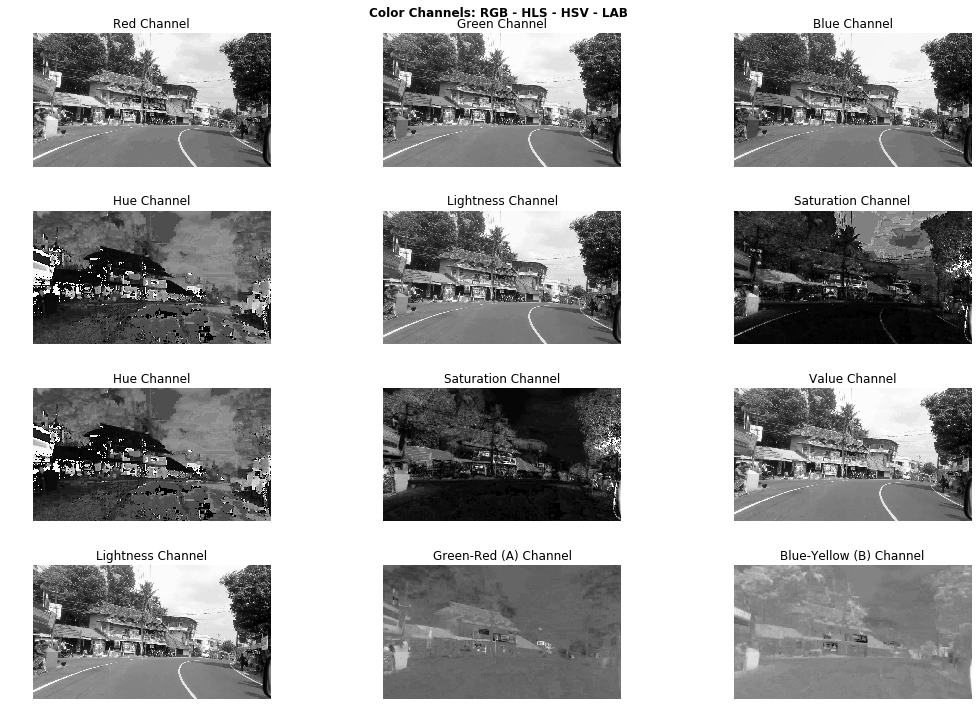

In [175]:
show_image_list(color_spaces_comps, color_spaces_lbs, "Color Channels: RGB - HLS - HSV - LAB", cols=3, fig_size=(15, 10), show_ticks=False)

In [176]:
def compute_hls_white_yellow_binary(rgb_img):
    """
    Returns a binary thresholded image produced retaining only white and yellow elements on the picture
    The provided image should be in RGB format
    """
    hls_img = to_hls(rgb_img)
    
    # Compute a binary thresholded image where yellow is isolated from HLS components
    img_hls_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_yellow_bin[((hls_img[:,:,0] >= 15) & (hls_img[:,:,0] <= 35))
                 & ((hls_img[:,:,1] >= 30) & (hls_img[:,:,1] <= 204))
                 & ((hls_img[:,:,2] >= 115) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    img_hls_white_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_bin[((hls_img[:,:,0] >= 0) & (hls_img[:,:,0] <= 255))
                 & ((hls_img[:,:,1] >= 200) & (hls_img[:,:,1] <= 255))
                 & ((hls_img[:,:,2] >= 0) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Now combine both
    img_hls_white_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_yellow_bin[(img_hls_yellow_bin == 1) | (img_hls_white_bin == 1)] = 1

    return img_hls_white_yellow_bin

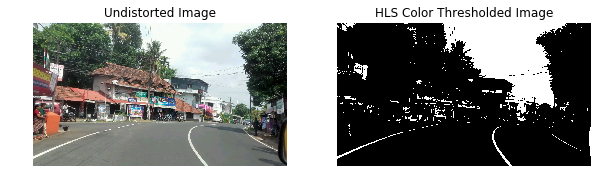

In [177]:
undistorted_yellow_white_hls_img_bin = compute_hls_white_yellow_binary(undistorted_test_img)

fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(undistorted_test_img)
ax[0].axis("off")
ax[0].set_title("Undistorted Image")

ax[1].imshow(undistorted_yellow_white_hls_img_bin, cmap='gray')
ax[1].axis("off")
ax[1].set_title("HLS Color Thresholded Image")

plt.show()

### Gradient Thresholding Via Sobel

In [178]:
# L channel is index 0 of the color components
undist_test_img_gray = to_lab(undistorted_test_img)[:,:,0]

#### Sobel In X or Y Directions

In [179]:
def abs_sobel(gray_img, x_dir=True, kernel_size=3, thres=(0, 255)):
    """
    Applies the sobel operator to a grayscale-like (i.e. single channel) image in either horizontal or vertical direction
    The function also computes the asbolute value of the resulting matrix and applies a binary threshold
    """
    sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size) if x_dir else cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255 * sobel / np.max(sobel_abs))
    
    gradient_mask = np.zeros_like(sobel_scaled)
    gradient_mask[(thres[0] <= sobel_scaled) & (sobel_scaled <= thres[1])] = 1
    return gradient_mask

In [180]:
sobx_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, thres=(20, 120)), abs_sobel(undist_test_img_gray, thres=(50, 150)), abs_sobel(undist_test_img_gray, thres=(80, 200))]])
sobx_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobx_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobx_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobx_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobx_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobx_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobx_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [181]:
sobx_thres = np.concatenate((sobx_3x3_thres, sobx_7x7_thres, sobx_11x11_thres, sobx_15x15_thres))
sobx_thres_lbs = np.concatenate((sobx_3x3_thres_lbs, sobx_7x7_thres_lbs, sobx_11x11_thres_lbs, sobx_15x15_thres_lbs))

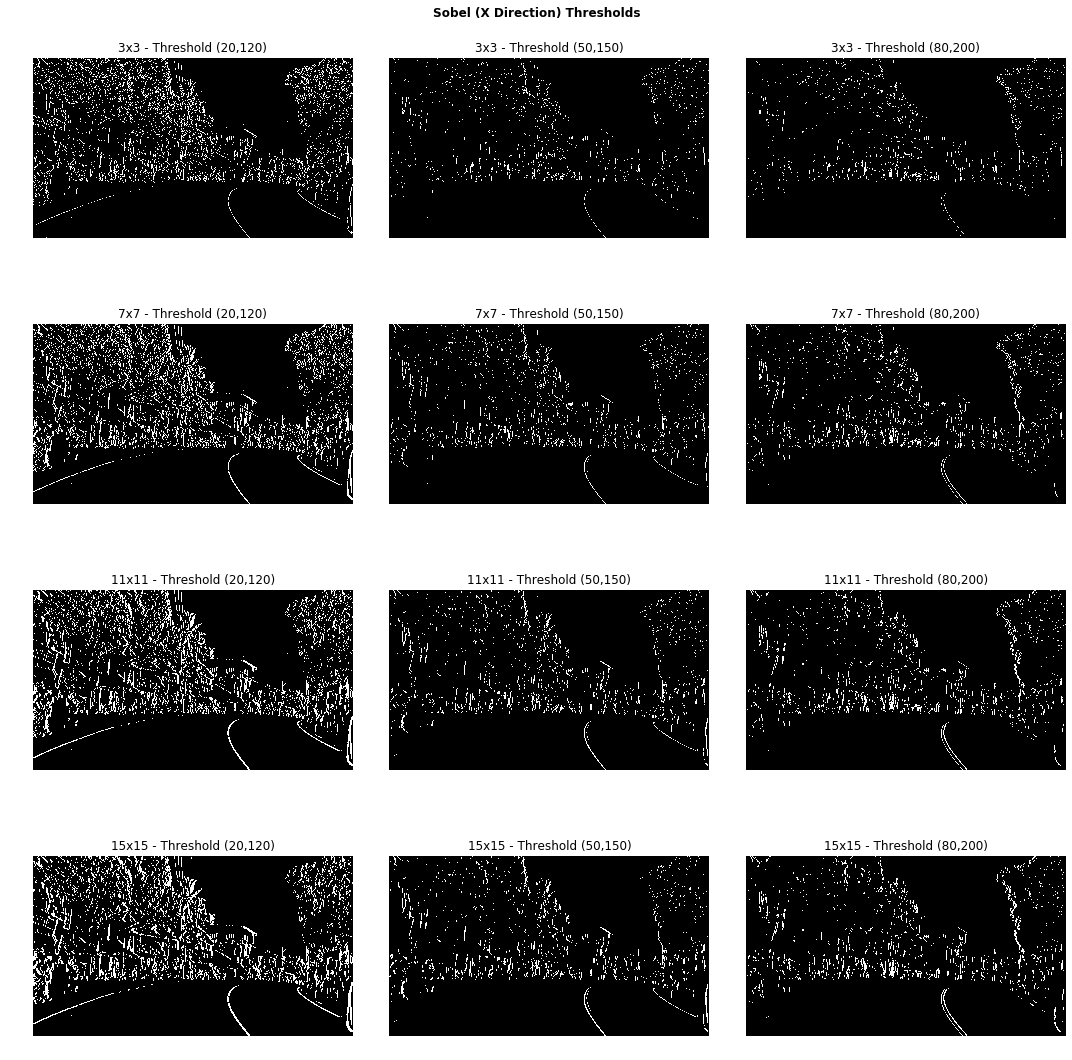

In [182]:
show_image_list(sobx_thres, sobx_thres_lbs, "Sobel (X Direction) Thresholds", cols=3, show_ticks=False)

In [183]:
# Saving our best sobel results
sobx_best = abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120))

In [184]:
soby_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(80, 200))]])
soby_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(80, 200))]])
soby_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(80, 200))]])
soby_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(80, 200))]])

soby_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
soby_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
soby_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
soby_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [185]:
soby_thres = np.concatenate((soby_3x3_thres, soby_7x7_thres, soby_11x11_thres, soby_15x15_thres))
soby_thres_lbs = np.concatenate((soby_3x3_thres_lbs, soby_7x7_thres_lbs, soby_11x11_thres_lbs, soby_15x15_thres_lbs))

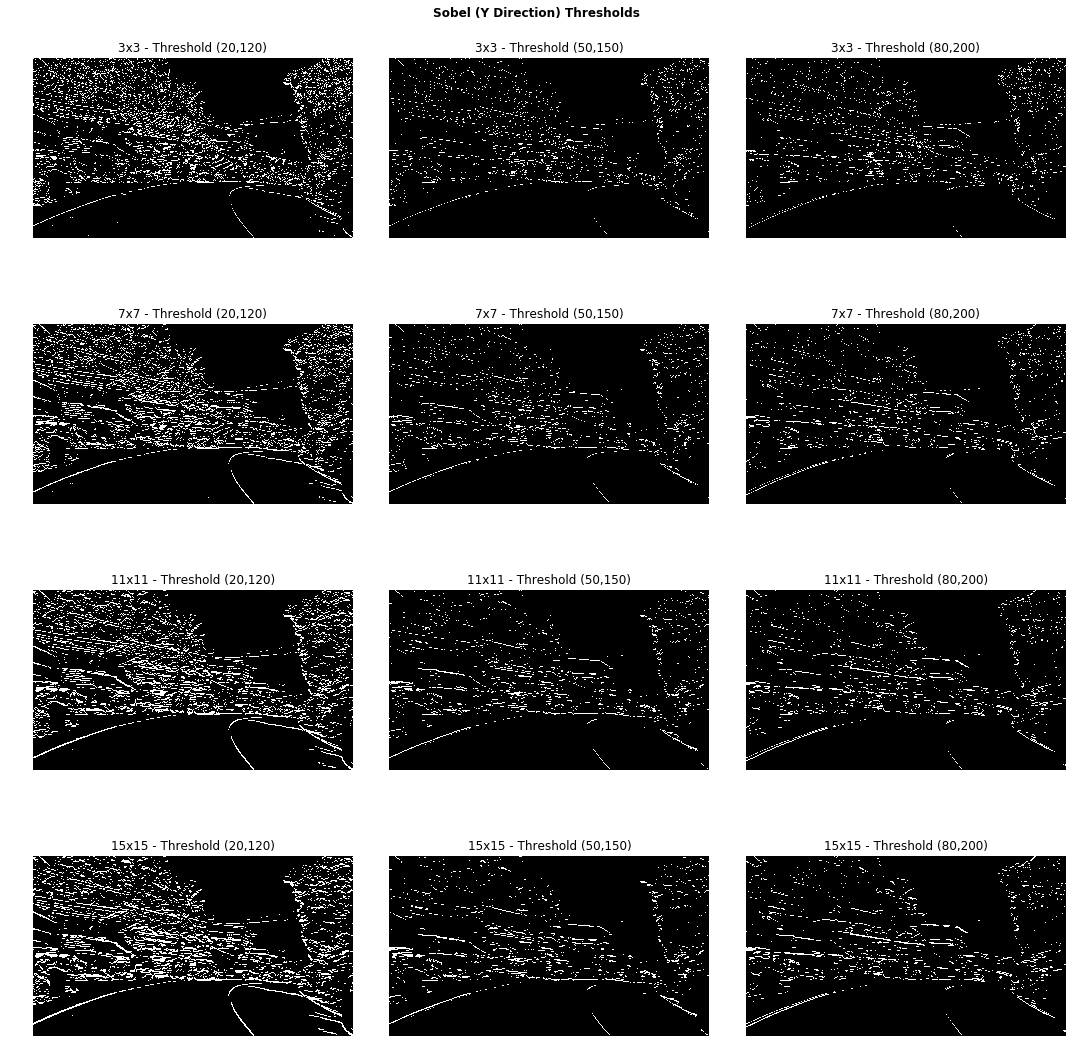

In [186]:
show_image_list(soby_thres, soby_thres_lbs, "Sobel (Y Direction) Thresholds", cols=3, show_ticks=False)

In [187]:
# Saving our best sobel y result
soby_best = abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))

#### Sobel Magnitude in X and Y Directions

In [188]:
def mag_sobel(gray_img, kernel_size=3, thres=(0, 255)):
    """
    Computes sobel matrix in both x and y directions, merges them by computing the magnitude in both directions
    and applies a threshold value to only set pixels within the specified range
    """
    sx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sy = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sxy = np.sqrt(np.square(sx) + np.square(sy))
    scaled_sxy = np.uint8(255 * sxy / np.max(sxy))
    
    sxy_binary = np.zeros_like(scaled_sxy)
    sxy_binary[(scaled_sxy >= thres[0]) & (scaled_sxy <= thres[1])] = 1
    
    return sxy_binary

In [189]:
sobxy_3x3_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=3, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(80, 200))]])
sobxy_7x7_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobxy_11x11_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobxy_15x15_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobxy_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,80)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobxy_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,80)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobxy_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,80)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobxy_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,80)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [190]:
sobxy_thres = np.concatenate((sobxy_3x3_thres, sobxy_7x7_thres, sobxy_11x11_thres, sobxy_15x15_thres))
sobxy_thres_lbs = np.concatenate((sobxy_3x3_thres_lbs, sobxy_7x7_thres_lbs, sobxy_11x11_thres_lbs, sobxy_15x15_thres_lbs))


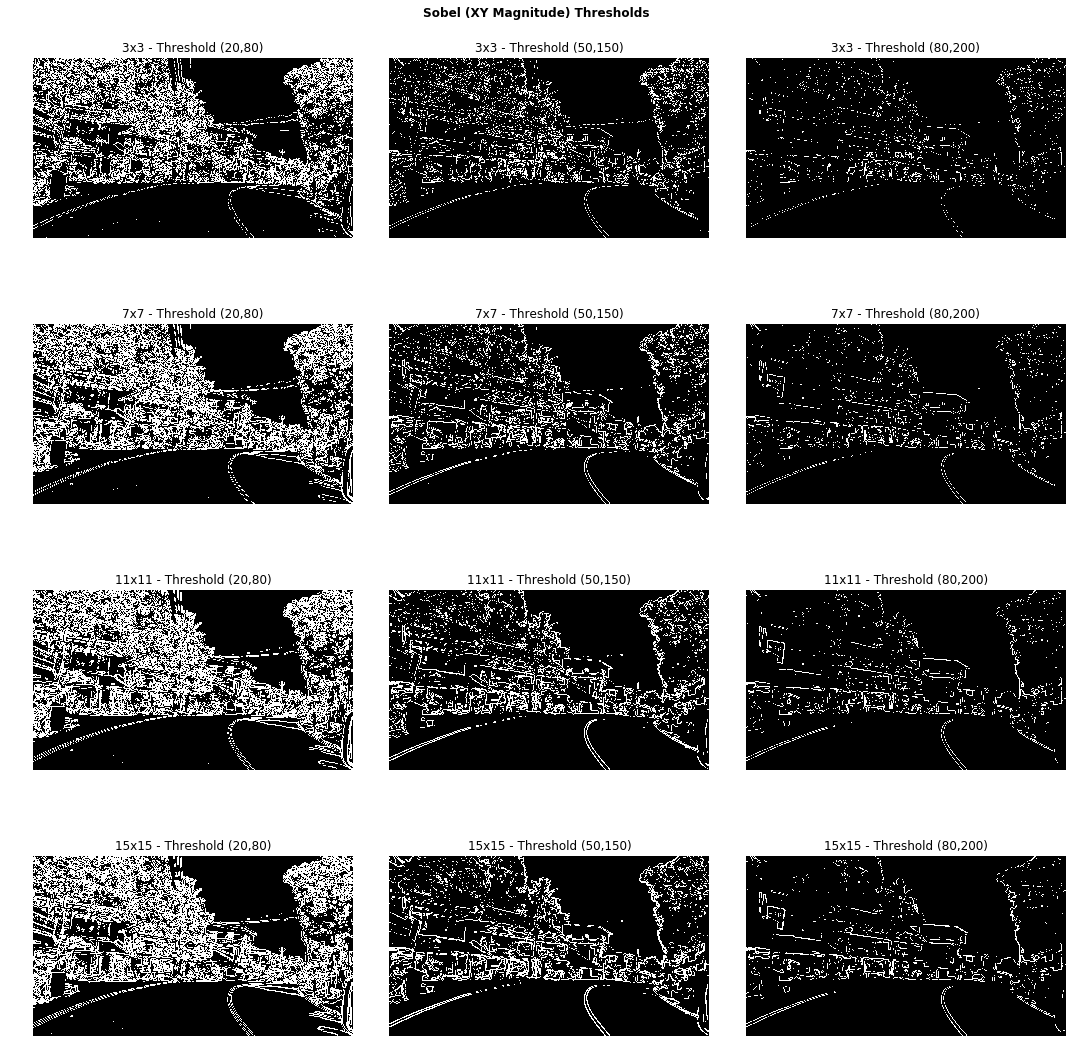

In [191]:
show_image_list(sobxy_thres, sobxy_thres_lbs, "Sobel (XY Magnitude) Thresholds", cols=3, show_ticks=False)

In [192]:
# Saving our best Sobel XY magnitude results
sobxy_best = mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))

#### Sobel With Gradient Direction

In [193]:
def dir_sobel(gray_img, kernel_size=3, thres=(0, np.pi/2)):
    """
    Computes sobel matrix in both x and y directions, gets their absolute values to find the direction of the gradient
    and applies a threshold value to only set pixels within the specified range
    """
    sx_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    sy_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    
    dir_sxy = np.arctan2(sx_abs, sy_abs)

    binary_output = np.zeros_like(dir_sxy)
    binary_output[(dir_sxy >= thres[0]) & (dir_sxy <= thres[1])] = 1
    
    return binary_output

In [194]:
def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary, gray_img, kernel_size=3, angle_thres=(0, np.pi/2)):
    sxy_direction_binary = dir_sobel(gray_img, kernel_size=kernel_size, thres=angle_thres)
    
    combined = np.zeros_like(sxy_direction_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels    
    combined[(sx_binary == 1) | ((sy_binary == 1) & (sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    
    return combined

In [195]:
cb = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray)

In [196]:
sobxy_combined_dir_3x3_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_7x7_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_11x11_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_15x15_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/3, np.pi/2))
                                           ]])


sobxy_combined_dir_3x3_thres_lbs = np.asarray([["3x3 - Combined (0, pi/4)", "3x3 - Combined (pi/4, pi/2)", "3x3 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_7x7_thres_lbs = np.asarray([["7x7 - Combined (0, pi/4)", "7x7 - Combined (pi/4, pi/2)", "7x7 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_11x11_thres_lbs = np.asarray([["11x11 - Combined (0, pi/4)", "11x11 - Combined (pi/4, pi/2)", "11x11 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_15x15_thres_lbs = np.asarray([["15x15 - Combined (0, pi/4)", "15x15 - Combined (pi/4, pi/2)", "15x15 - Combined (pi/3, pi/2)"]])

In [197]:
sobxy_combined_dir_thres = np.concatenate((sobxy_combined_dir_3x3_thres, sobxy_combined_dir_7x7_thres, sobxy_combined_dir_11x11_thres, sobxy_combined_dir_15x15_thres))
sobxy_combined_dir_thres_lbs = np.concatenate((sobxy_combined_dir_3x3_thres_lbs, sobxy_combined_dir_7x7_thres_lbs, sobxy_combined_dir_11x11_thres_lbs, sobxy_combined_dir_15x15_thres_lbs))

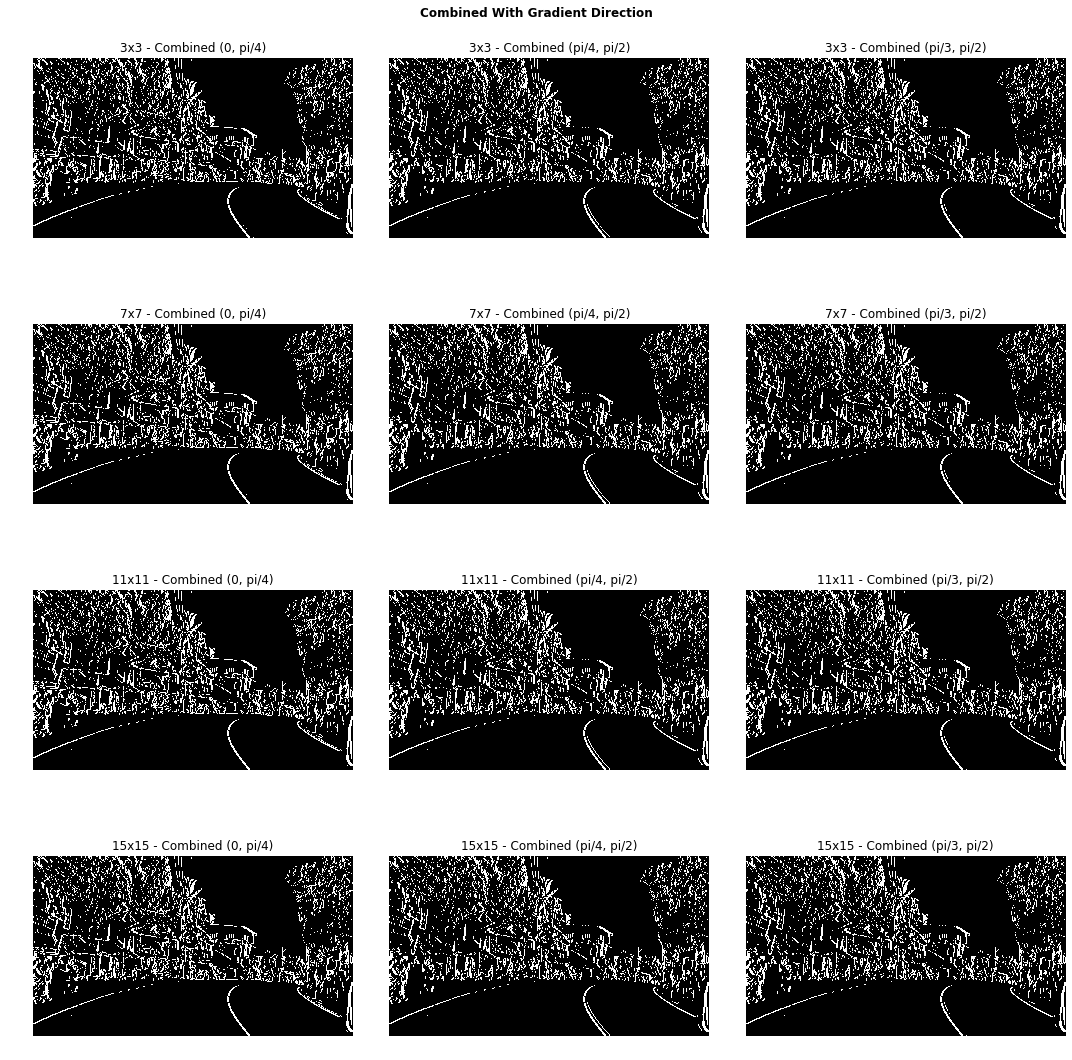

In [198]:
show_image_list(sobxy_combined_dir_thres, sobxy_combined_dir_thres_lbs, "Combined With Gradient Direction", cols=3, show_ticks=False)

In [199]:
sobel_combined_best = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))                                                                            

### Combining Color And Gradient (Sobel) Thresholds

In [200]:
color_binary = np.dstack((np.zeros_like(sobel_combined_best), sobel_combined_best, undistorted_yellow_white_hls_img_bin)) * 255
color_binary = color_binary.astype(np.uint8)

In [201]:
combined_binary = np.zeros_like(undistorted_yellow_white_hls_img_bin)
combined_binary[(sobel_combined_best == 1) | (undistorted_yellow_white_hls_img_bin == 1)] = 1

In [202]:
combined_binaries = [[color_binary, combined_binary]]
combined_binaries_lbs = np.asarray([["Stacked Thresholds", "Combined Color And Gradient Thresholds"]])

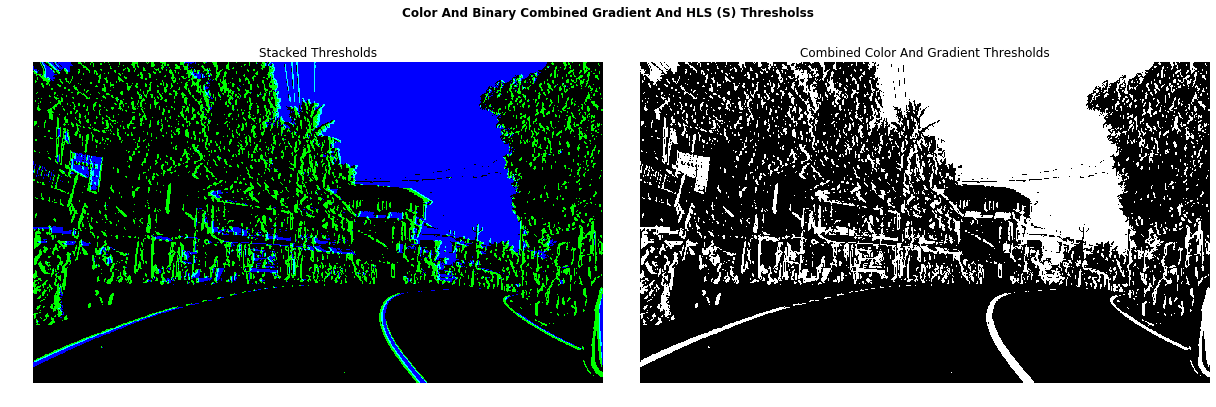

In [203]:
show_image_list(combined_binaries, combined_binaries_lbs, "Color And Binary Combined Gradient And HLS (S) Thresholss", cols=2, fig_size=(17, 6), show_ticks=False)

## Perspective Transform

(720, 1280, 3)


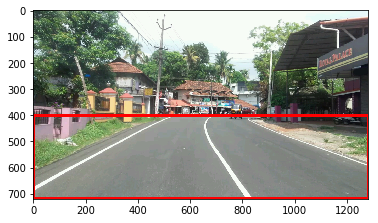

In [229]:
copy_combined = np.copy(undist_test_imgs[3])
print(copy_combined.shape)
(bottom_px, right_px) = (copy_combined.shape[0] - 1, copy_combined.shape[1] - 1) 
pts = np.array([[0,bottom_px],[0,400],[1280,400], [1280, bottom_px]], np.int32)
cv2.polylines(copy_combined,[pts],True,(255,0,0), 10)
plt.axis('on')
plt.imshow(copy_combined)

In [230]:
def compute_perspective_transform_matrices(src, dst):
    """
    Returns the tuple (M, M_inv) where M represents the matrix to use for perspective transform
    and M_inv is the matrix used to revert the transformed image back to the original one
    """
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, M_inv)

In [231]:
def perspective_transform(img, src, dst):   
    """
    Applies a perspective 
    """
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [232]:
src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, bottom_px], [200, 0], [1000, 0], [1000, bottom_px]], np.float32)

In [233]:
test_img_persp_tr = perspective_transform(undistorted_test_img, src_pts, dst_pts)

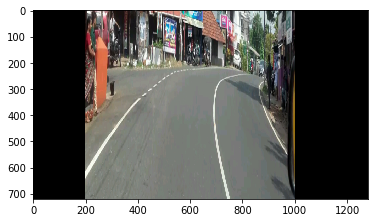

In [234]:
plt.imshow(test_img_persp_tr)

Here the lane is curved, and our perspective transform takes this into account too.

In [235]:
test_imgs_pers_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

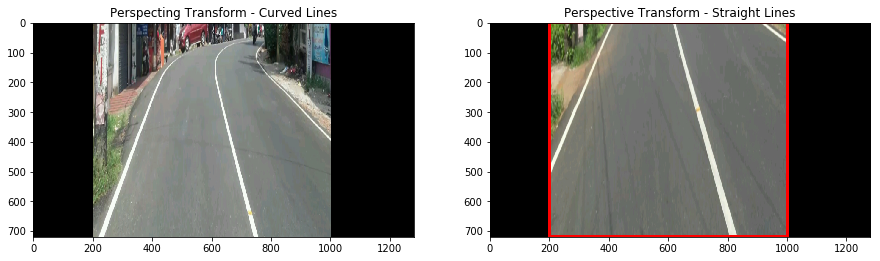

In [236]:
test_persp_img = np.copy(test_imgs_pers_tr[1])
dst = dst_pts.astype(np.int32)
cv2.polylines(test_persp_img,[dst],True,(255,0,0), 10)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(test_imgs_pers_tr[5])
ax[0].set_title("Perspecting Transform - Curved Lines")

ax[1].imshow(test_persp_img)
ax[1].set_title("Perspective Transform - Straight Lines")

plt.show()

In [237]:
test_undist_imgs_and_p_tr = np.asarray(list(zip(undist_test_imgs, test_imgs_pers_tr)))
test_undist_imgs_and_p_tr_names = np.asarray(list(zip(undist_test_img_names, undist_test_img_names)))

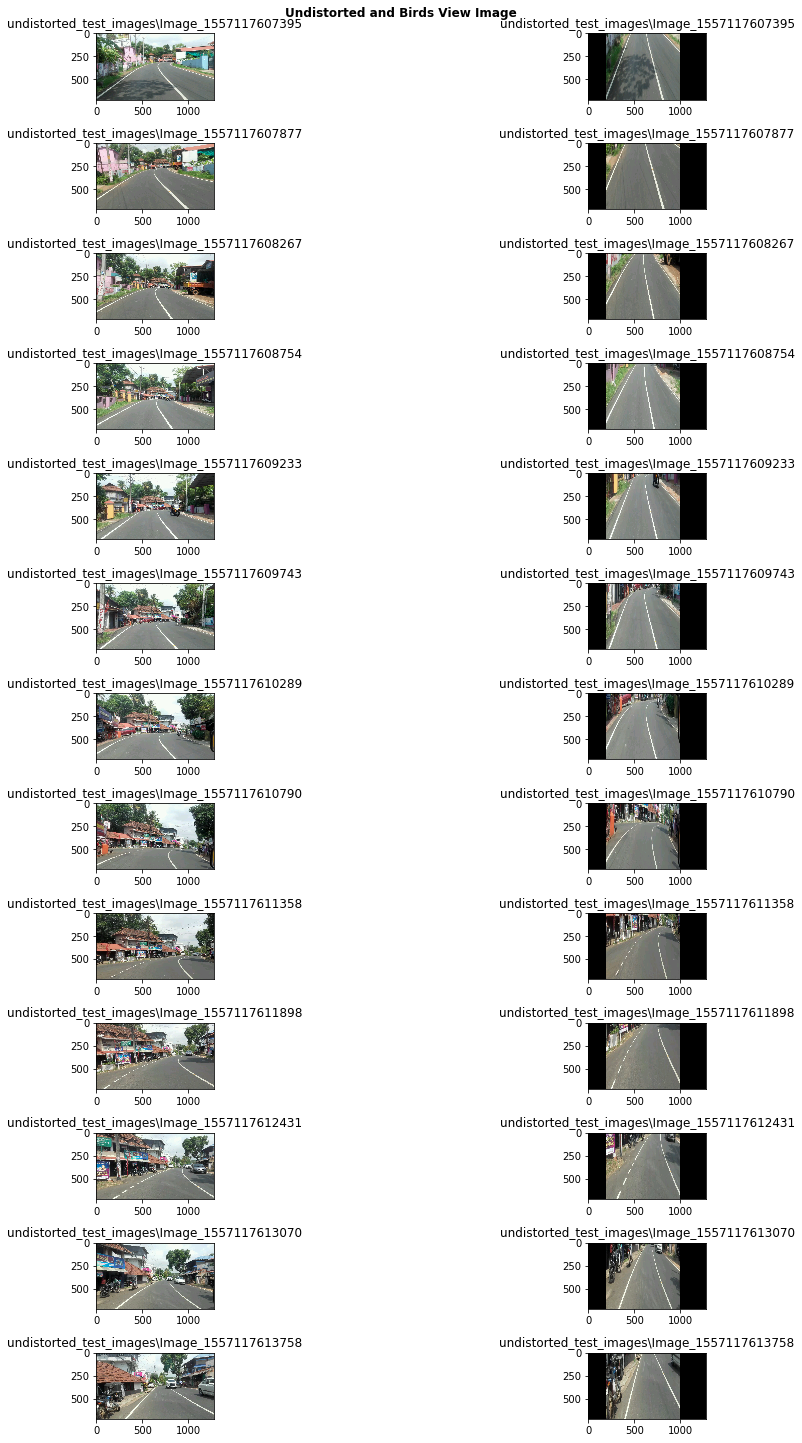

In [238]:
show_image_list(test_undist_imgs_and_p_tr, test_undist_imgs_and_p_tr_names, "Undistorted and Birds View Image", fig_size=(15, 20))

In [239]:
def get_combined_binary_thresholded_img(undist_img):
    """
    Applies a combination of binary Sobel and color thresholding to an undistorted image
    Those binary images are then combined to produce the returned binary image
    """
    undist_img_gray = to_lab(undist_img)[:,:,0]
    sx = abs_sobel(undist_img_gray, kernel_size=15, thres=(20, 120))
    sy = abs_sobel(undist_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))
    sxy = mag_sobel(undist_img_gray, kernel_size=15, thres=(80, 200))
    sxy_combined_dir = combined_sobels(sx, sy, sxy, undist_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))   
    
    hls_w_y_thres = compute_hls_white_yellow_binary(undist_img)
    
    combined_binary = np.zeros_like(hls_w_y_thres)
    combined_binary[(sxy_combined_dir == 1) | (hls_w_y_thres == 1)] = 1
        
    return combined_binary

In [240]:
test_imgs_combined_binary_thres = np.asarray(list(map(lambda img: get_combined_binary_thresholded_img(img), undist_test_imgs)))

In [241]:
test_imgs_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

In [242]:
test_imgs_combined_binary_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), test_imgs_combined_binary_thres))) 

In [243]:
test_imgs_combined_binary_and_psp_tr = np.asarray(list(zip(test_imgs_psp_tr[:,:,:,0],test_imgs_combined_binary_thres, test_imgs_combined_binary_psp_tr)))
test_imgs_combined_binary_and_psp_tr_names = np.asarray(list(zip(undist_test_img_names,undist_test_img_names, undist_test_img_names)))

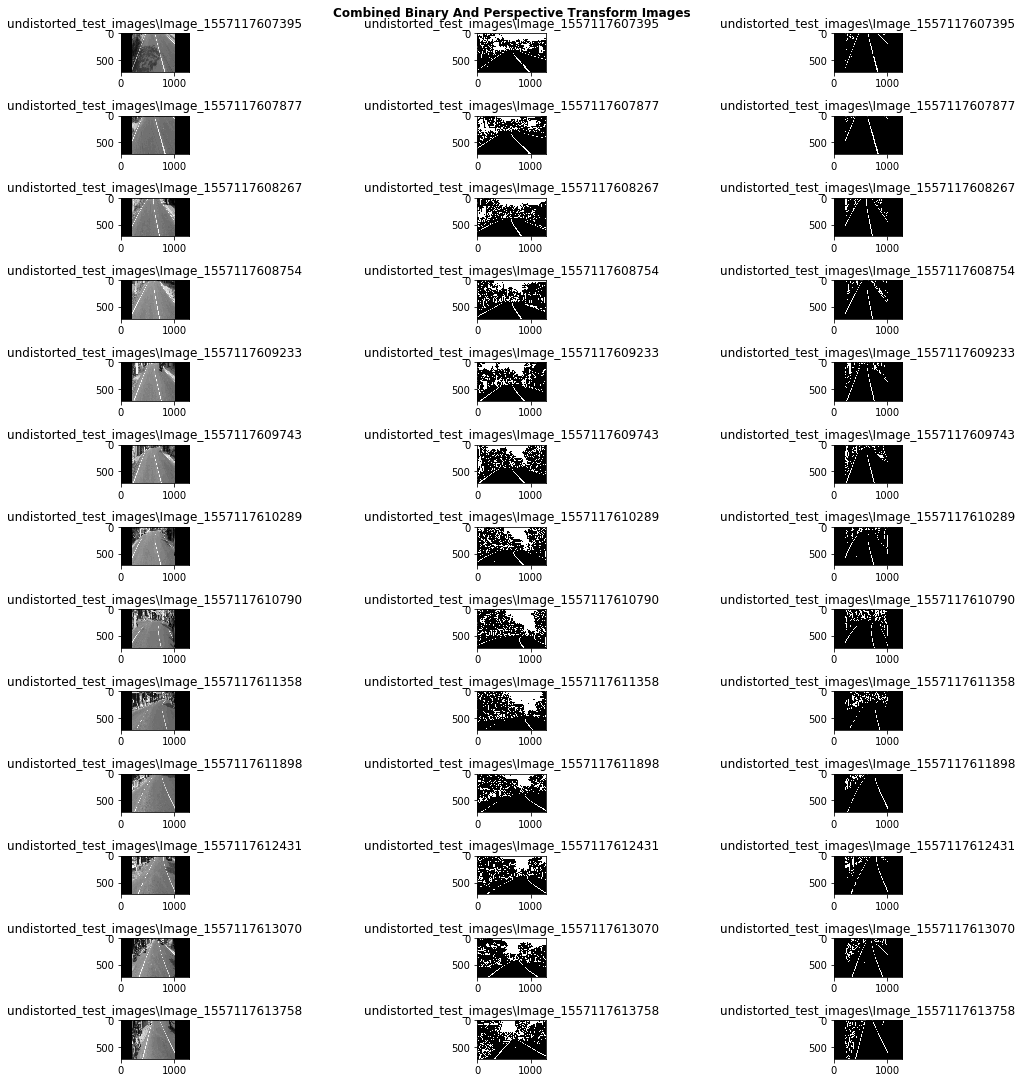

In [244]:
show_image_list(test_imgs_combined_binary_and_psp_tr, test_imgs_combined_binary_and_psp_tr_names, "Combined Binary And Perspective Transform Images", cols=3, fig_size=(15, 15))

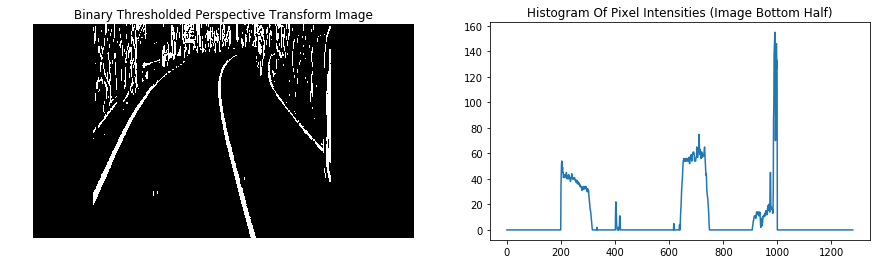

In [245]:
img_example = test_imgs_combined_binary_and_psp_tr[6][2]
histogram = np.sum(img_example[img_example.shape[0]//2:,:], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].imshow(img_example, cmap='gray')
ax[0].axis("off")
ax[0].set_title("Binary Thresholded Perspective Transform Image")

ax[1].plot(histogram)
ax[1].set_title("Histogram Of Pixel Intensities (Image Bottom Half)")

plt.show()

# Full Pipeline 



In [246]:
from collections import deque

def create_queue(length = 10):
    return deque(maxlen=length)

In [247]:
class LaneLine:
    def __init__(self):
        
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []

In [248]:
import math

class LaneLineHistory:
    def __init__(self, queue_depth=2, test_points=[50, 300, 500, 700], poly_max_deviation_distance=150):
        self.lane_lines = create_queue(queue_depth)
        self.smoothed_poly = None
        self.test_points = test_points
        self.poly_max_deviation_distance = poly_max_deviation_distance
    
    def append(self, lane_line, force=False):
        if len(self.lane_lines) == 0 or force:
            self.lane_lines.append(lane_line)
            self.get_smoothed_polynomial()
            return True
        
        test_y_smooth = np.asarray(list(map(lambda x: self.smoothed_poly[0] * x**2 + self.smoothed_poly[1] * x + self.smoothed_poly[2], self.test_points)))
        test_y_new = np.asarray(list(map(lambda x: lane_line.polynomial_coeff[0] * x**2 + lane_line.polynomial_coeff[1] * x + lane_line.polynomial_coeff[2], self.test_points)))
        
        dist = np.absolute(test_y_smooth - test_y_new)
        
        #dist = np.absolute(self.smoothed_poly - lane_line.polynomial_coeff)
        #dist_max = np.absolute(self.smoothed_poly * self.poly_max_deviation_distance)
        max_dist = dist[np.argmax(dist)]
        
        if max_dist > self.poly_max_deviation_distance:
            print("**** MAX DISTANCE BREACHED ****")
            print("y_smooth={0} - y_new={1} - distance={2} - max-distance={3}".format(test_y_smooth, test_y_new, max_dist, self.poly_max_deviation_distance))
            return False
        
        self.lane_lines.append(lane_line)
        self.get_smoothed_polynomial()
        
        return True
    
    def get_smoothed_polynomial(self):
        all_coeffs = np.asarray(list(map(lambda lane_line: lane_line.polynomial_coeff, self.lane_lines)))
        self.smoothed_poly = np.mean(all_coeffs, axis=0)
        
        return self.smoothed_poly
                                
        

In [249]:
class AdvancedLaneDetectorWithMemory:
    """
    The AdvancedLaneDetectorWithMemory is a class that can detect lines on the road
    ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)
    used parameters:-
        slidingwindows_per_line       =  20
        sliding_window_half_width     =  100
        # Set minimum number of pixels found to recenter window
        sliding_window_recenter_thres =  50
        
    """
    def __init__(self, objpts, imgpts, psp_src, psp_dst, sliding_windows_per_line, 
                 sliding_window_half_width, sliding_window_recenter_thres, 
                 small_img_size=(256, 144), small_img_x_offset=20, small_img_y_offset=10,
                 img_dimensions=(720, 1280), lane_width_px=800, 
                 lane_center_px_psp=640, real_world_lane_size_meters=(32, 3.7)):
        self.objpts = objpts
        self.imgpts = imgpts
        (self.M_psp, self.M_inv_psp) = compute_perspective_transform_matrices(psp_src, psp_dst)

        self.sliding_windows_per_line = sliding_windows_per_line
        self.sliding_window_half_width = sliding_window_half_width
        self.sliding_window_recenter_thres = sliding_window_recenter_thres
        
        self.small_img_size = small_img_size
        self.small_img_x_offset = small_img_x_offset
        self.small_img_y_offset = small_img_y_offset
        
        self.img_dimensions = img_dimensions
        self.lane_width_px = lane_width_px
        self.lane_center_px_psp = lane_center_px_psp 
        self.real_world_lane_size_meters = real_world_lane_size_meters

        # We can pre-compute some data here
        self.ym_per_px = self.real_world_lane_size_meters[0] / self.img_dimensions[0]
        self.xm_per_px = self.real_world_lane_size_meters[1] / self.lane_width_px
        self.ploty = np.linspace(0, self.img_dimensions[0] - 1, self.img_dimensions[0])
        
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        
        self.previous_left_lane_lines = LaneLineHistory()
        self.previous_right_lane_lines = LaneLineHistory()
        
        self.total_img_count = 0
        
    
    def process_image(self, img):
        """
        Attempts to find lane lines on the given image and returns an image with lane area colored in green
        as well as small intermediate images overlaid on top to understand how the algorithm is performing
        """
        # First step - undistort the image using the instance's object and image points
        undist_img = undistort_image(img, self.objpts, self.imgpts)
        
        # Produce binary thresholded image from color and gradients
        thres_img = get_combined_binary_thresholded_img(undist_img)
        
        # Create the undistorted and binary perspective transforms
        img_size = (undist_img.shape[1], undist_img.shape[0])
        undist_img_psp = cv2.warpPerspective(undist_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        thres_img_psp = cv2.warpPerspective(thres_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        
        ll, rl = self.compute_lane_lines(thres_img_psp)
        lcr, rcr, lco = self.compute_lane_curvature(ll, rl)

        drawn_lines = self.draw_lane_lines(thres_img_psp, ll, rl)        
        #plt.imshow(drawn_lines)
        
        drawn_lines_regions = self.draw_lane_lines_regions(thres_img_psp, ll, rl)
        #plt.imshow(drawn_lines_regions)
        
        drawn_lane_area = self.draw_lane_area(thres_img_psp, undist_img, ll, rl)        
        #plt.imshow(drawn_lane_area)
        
        drawn_hotspots = self.draw_lines_hotspots(thres_img_psp, ll, rl)
        
        combined_lane_img = self.combine_images(drawn_lane_area, drawn_lines, drawn_lines_regions, drawn_hotspots, undist_img_psp)
        final_img = self.draw_lane_curvature_text(combined_lane_img, lcr, rcr, lco)
        
        self.total_img_count += 1
        self.previous_left_lane_line = ll
        self.previous_right_lane_line = rl
        
        return final_img
    
    def draw_lane_curvature_text(self, img, left_curvature_meters, right_curvature_meters, center_offset_meters):
        """
        Returns an image with curvature information inscribed
        """
        
        offset_y = self.small_img_size[1] * 1 + self.small_img_y_offset * 5
        offset_x = self.small_img_x_offset
        
        template = "{0:17}{1:17}{2:17}"
        txt_header = template.format("Left Curvature", "Right Curvature", "Center Alignment") 
        print(txt_header)
        txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Right".format(center_offset_meters))
        if center_offset_meters < 0.0:
            txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Left".format(math.fabs(center_offset_meters)))
            
        
        print(txt_values)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, txt_header, (offset_x, offset_y), font, 1, (255,255,255), 1, cv2.LINE_AA)
        cv2.putText(img, txt_values, (offset_x, offset_y + self.small_img_y_offset * 5), font, 1, (255,255,255), 2, cv2.LINE_AA)
        
        return img
    
    def combine_images(self, lane_area_img, lines_img, lines_regions_img, lane_hotspots_img, psp_color_img):        
        """
        Returns a new image made up of the lane area image, and the remaining lane images are overlaid as
        small images in a row at the top of the the new image
        """
        small_lines = cv2.resize(lines_img, self.small_img_size)
        small_region = cv2.resize(lines_regions_img, self.small_img_size)
        small_hotspots = cv2.resize(lane_hotspots_img, self.small_img_size)
        small_color_psp = cv2.resize(psp_color_img, self.small_img_size)
                
        lane_area_img[self.small_img_y_offset: self.small_img_y_offset + self.small_img_size[1], self.small_img_x_offset: self.small_img_x_offset + self.small_img_size[0]] = small_lines
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 2 * self.small_img_x_offset + self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_region
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 3 * self.small_img_x_offset + 2 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_hotspots

        start_offset_y = self.small_img_y_offset 
        start_offset_x = 4 * self.small_img_x_offset + 3 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_color_psp
        
        
        return lane_area_img
    
        
    def draw_lane_area(self, warped_img, undist_img, left_line, right_line):
        """
        Returns an image where the inside of the lane has been colored in bright green
        """
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.M_inv_psp, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        
        return result
        
        
    def draw_lane_lines(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed lane lines have been drawn on top of the original warped binary image
        """
        # Create an output image with 3 colors (RGB) from the binary warped image to draw on and  visualize the result
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        # Now draw the lines
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        pts_left = np.dstack((left_line.line_fit_x, ploty)).astype(np.int32)
        pts_right = np.dstack((right_line.line_fit_x, ploty)).astype(np.int32)

        cv2.polylines(out_img, pts_left, False,  (255, 140,0), 5)
        cv2.polylines(out_img, pts_right, False, (255, 140,0), 5)
        
        for low_pt, high_pt in left_line.windows:
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)

        for low_pt, high_pt in right_line.windows:            
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)           
        
        return out_img    
    
    def draw_lane_lines_regions(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed left and right lane areas have been drawn on top of the original warped binary image
        """
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = self.sliding_window_half_width
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        
        left_line_window1 = np.array([np.transpose(np.vstack([left_line.line_fit_x - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.line_fit_x + margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_line.line_fit_x - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x + margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Create RGB image from binary warped image
        region_img = np.dstack((warped_img, warped_img, warped_img)) * 255

        # Draw the lane onto the warped blank image
        cv2.fillPoly(region_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(region_img, np.int_([right_line_pts]), (0, 255, 0))
        
        return region_img


    def draw_lines_hotspots(self, warped_img, left_line, right_line):
        """
        Returns a RGB image where the portions of the lane lines that were
        identified by our pipeline are colored in yellow (left) and blue (right)
        """
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        out_img[left_line.non_zero_y, left_line.non_zero_x] = [255, 255, 0]
        out_img[right_line.non_zero_y, right_line.non_zero_x] = [0, 0, 255]
        
        return out_img

    def compute_lane_curvature(self, left_line, right_line):
        """
        Returns the triple (left_curvature, right_curvature, lane_center_offset), which are all in meters
        """        
        ploty = self.ploty
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        
        leftx = left_line.line_fit_x
        rightx = right_line.line_fit_x
        
        # Fit new polynomials: find x for y in real-world space
        left_fit_cr = np.polyfit(ploty * self.ym_per_px, leftx * self.xm_per_px, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_px, rightx * self.xm_per_px, 2)
        
        # Now calculate the radii of the curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_px + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 *right_fit_cr[0] * y_eval * self.ym_per_px + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        # Use our computed polynomial to determine the car's center position in image space, then
        left_fit = left_line.polynomial_coeff
        right_fit = right_line.polynomial_coeff
        
        center_offset_img_space = (((left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + 
                   (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])) / 2) - self.lane_center_px_psp
        center_offset_real_world_m = center_offset_img_space * self.xm_per_px
        
        # Now our radius of curvature is in meters        
        return left_curverad, right_curverad, center_offset_real_world_m
        
        
        
    def compute_lane_lines(self, warped_img):
        """
        Returns the tuple (left_lane_line, right_lane_line) which represents respectively the LaneLine
        instances for the computed left and right lanes, for the supplied binary warped image
        """

        # Take a histogram of the bottom half of the image, summing pixel values column wise 
        histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
        
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines 
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint # don't forget to offset by midpoint!
        

        # Set height of windows
        window_height = np.int(warped_img.shape[0]//self.sliding_windows_per_line)
        # Identify the x and y positions of all nonzero pixels in the image
        # NOTE: nonzero returns a tuple of arrays in y and x directions
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        total_non_zeros = len(nonzeroy)
        non_zero_found_pct = 0.0
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base    


        # Set the width of the windows +/- margin
        margin = self.sliding_window_half_width
        # Set minimum number of pixels found to recenter window
        minpix = self.sliding_window_recenter_thres
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Our lane line objects we store the result of this computation
        left_line = LaneLine()
        right_line = LaneLine()
                        
        if self.previous_left_lane_line is not None and self.previous_right_lane_line is not None:
            # We have already computed the lane lines polynomials from a previous image
            left_lane_inds = ((nonzerox > (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_left_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_left_lane_line.polynomial_coeff[2] + margin))) 

            right_lane_inds = ((nonzerox > (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_right_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_right_lane_line.polynomial_coeff[2] + margin))) 
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Previous lane] Found pct={0}".format(non_zero_found_pct))
            #print(left_lane_inds)
        
        if non_zero_found_pct < 0.85:
            print("Non zeros found below thresholds, begining sliding window - pct={0}".format(non_zero_found_pct))
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(self.sliding_windows_per_line):
                # Identify window boundaries in x and y (and right and left)
                # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
                win_y_low = warped_img.shape[0] - (window + 1)* window_height
                win_y_high = warped_img.shape[0] - window * window_height

                # Defining our window's coverage in the horizontal (i.e. x) direction 
                # Notice that the window's width is twice the margin
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                left_line.windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
                right_line.windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

                # Super crytic and hard to understand...
                # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
                # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
                # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
            # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
            # These are the indices that are non zero in our sliding windows
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Sliding windows] Found pct={0}".format(non_zero_found_pct))
            
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        #print("[LEFT] Number of hot pixels={0}".format(len(leftx)))
        #print("[RIGHT] Number of hot pixels={0}".format(len(rightx)))
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #print("Poly left {0}".format(left_fit))
        #print("Poly right {0}".format(right_fit))
        left_line.polynomial_coeff = left_fit
        right_line.polynomial_coeff = right_fit
        
        if not self.previous_left_lane_lines.append(left_line):
            left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            left_line.polynomial_coeff = left_fit
            self.previous_left_lane_lines.append(left_line, force=True)
            print("**** REVISED Poly left {0}".format(left_fit))            
        #else:
            #left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            #left_line.polynomial_coeff = left_fit


        if not self.previous_right_lane_lines.append(right_line):
            right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            right_line.polynomial_coeff = right_fit
            self.previous_right_lane_lines.append(right_line, force=True)
            print("**** REVISED Poly right {0}".format(right_fit))
        #else:
            #right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            #right_line.polynomial_coeff = right_fit


    
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        
        left_line.polynomial_coeff = left_fit
        left_line.line_fit_x = left_fitx
        left_line.non_zero_x = leftx  
        left_line.non_zero_y = lefty

        right_line.polynomial_coeff = right_fit
        right_line.line_fit_x = right_fitx
        right_line.non_zero_x = rightx
        right_line.non_zero_y = righty

        
        return (left_line, right_line)

In [250]:
ld = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 100, 50)

In [251]:
test_img_path = test_imgs_paths[3]
test_img = load_image(test_img_path)
proc_img = ld.process_image(test_img)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=15539.378208305498
Left Curvature   Right Curvature  Center Alignment 
258.1634m        5097.0601m       0.9881m Left     


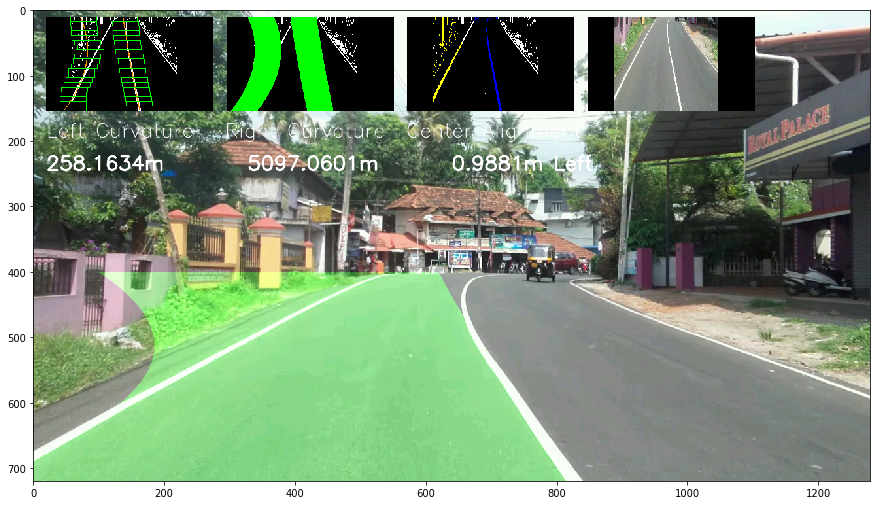

In [252]:
plt.figure(figsize=(15,10))
plt.imshow(proc_img)

# Normal video

In [143]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [147]:
project_video_path = "LVTM1.mp4"
project_video_output_path = 'output_videos/LVTM1_out1.mp4'


'''
project_video_sample_path = 'LVTM1_sample.mp4'
project_video_sample_output_path = 'output_videos/LVTM1_sample_out.mp4'
'''


"\nproject_video_sample_path = 'LVTM1_sample.mp4'\nproject_video_sample_output_path = 'output_videos/LVTM1_sample_out.mp4'\n"

In [148]:
detector = AdvancedLaneDetectorWithMemory(opts, ipts, src_pts, dst_pts, 20, 50, 10)

clip1 = VideoFileClip(project_video_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=11888.098626906545
Left Curvature   Right Curvature  Center Alignment 
822.2464m        2209.7088m       0.0722m Left     
Moviepy - Building video output_videos/LVTM1_out1.mp4.
Moviepy - Writing video output_videos/LVTM1_out1.mp4



t:   0%|                                     | 0/655 [00:00<?, ?it/s, now=None]

[Previous lane] Found pct=0.8760792666692024
Left Curvature   Right Curvature  Center Alignment 
435.3504m        1323.7522m       0.2018m Left     


t:   0%|                             | 2/655 [00:09<49:58,  4.59s/it, now=None]

[Previous lane] Found pct=0.8682879173790168
Left Curvature   Right Curvature  Center Alignment 
364.9003m        6012.2545m       0.4003m Left     


t:   0%|                           | 3/655 [00:17<1:03:35,  5.85s/it, now=None]

[Previous lane] Found pct=0.8793497334701851
Left Curvature   Right Curvature  Center Alignment 
447.3091m        1550.6911m       0.3554m Left     


t:   1%|▏                          | 4/655 [00:25<1:09:37,  6.42s/it, now=None]

[Previous lane] Found pct=0.8541523395593211
Left Curvature   Right Curvature  Center Alignment 
621.0839m        552.4461m        0.3441m Left     


t:   1%|▏                          | 5/655 [00:33<1:13:08,  6.75s/it, now=None]

[Previous lane] Found pct=0.8408076350761968
Non zeros found below thresholds, begining sliding window - pct=0.8408076350761968
[Sliding windows] Found pct=17287.346400533635
Left Curvature   Right Curvature  Center Alignment 
1132.3940m       1764.4592m       0.1089m Left     


t:   1%|▏                          | 6/655 [00:41<1:16:43,  7.09s/it, now=None]

[Previous lane] Found pct=0.8102327334401206
Non zeros found below thresholds, begining sliding window - pct=0.8102327334401206
[Sliding windows] Found pct=18241.41517478564
Left Curvature   Right Curvature  Center Alignment 
1373.3209m       775.4072m        0.1092m Left     


t:   1%|▎                          | 7/655 [00:48<1:18:22,  7.26s/it, now=None]

[Previous lane] Found pct=0.7718571612515559
Non zeros found below thresholds, begining sliding window - pct=0.7718571612515559
[Sliding windows] Found pct=18869.971565303233
Left Curvature   Right Curvature  Center Alignment 
2193.9308m       3128.7582m       0.0803m Right    


t:   1%|▎                          | 8/655 [00:56<1:19:41,  7.39s/it, now=None]

[Previous lane] Found pct=0.7506752332623997
Non zeros found below thresholds, begining sliding window - pct=0.7506752332623997
[Sliding windows] Found pct=19463.563860697333
Left Curvature   Right Curvature  Center Alignment 
4090.1115m       1483.5614m       0.0902m Right    


t:   1%|▎                          | 9/655 [01:04<1:20:26,  7.47s/it, now=None]

[Previous lane] Found pct=0.74817306095333
Non zeros found below thresholds, begining sliding window - pct=0.74817306095333
[Sliding windows] Found pct=17873.13953246969
**** MAX DISTANCE BREACHED ****
y_smooth=[ 833.64043703  952.04330308 1037.19829805 1113.84902824] - y_new=[853.04650727 825.98587227 781.1627772  715.74004917] - distance=398.1089790627119 - max-distance=150
**** REVISED Poly right [-1.06303310e-04  5.10817623e-01  8.08365314e+02]
Left Curvature   Right Curvature  Center Alignment 
2325.6766m       2013.0275m       0.0946m Right    


t:   2%|▍                         | 10/655 [01:11<1:21:29,  7.58s/it, now=None]

[Previous lane] Found pct=0.7251957967649258
Non zeros found below thresholds, begining sliding window - pct=0.7251957967649258
[Sliding windows] Found pct=18263.134342162226
**** MAX DISTANCE BREACHED ****
y_smooth=[ 836.96727053  955.42921894 1038.92714575 1112.40584418] - y_new=[849.86470429 858.04375883 827.65065741 764.42524928] - distance=347.98059490137393 - max-distance=150
**** REVISED Poly right [-1.25240355e-04  5.17681918e-01  8.11396276e+02]
Left Curvature   Right Curvature  Center Alignment 
2281.6907m       1708.2538m       0.0857m Right    


t:   2%|▍                         | 11/655 [01:19<1:21:40,  7.61s/it, now=None]

[Previous lane] Found pct=0.7560975609756098
Non zeros found below thresholds, begining sliding window - pct=0.7560975609756098
[Sliding windows] Found pct=18267.587081308146
**** MAX DISTANCE BREACHED ****
y_smooth=[ 835.30385378  953.73626101 1038.0627219  1113.12743621] - y_new=[838.49420721 950.30017654 976.19253987 945.59387019] - distance=167.53356601828682 - max-distance=150
**** REVISED Poly right [-1.15771832e-04  5.14249770e-01  8.09880795e+02]
Left Curvature   Right Curvature  Center Alignment 
46354.0584m      1848.1744m       0.1118m Right    


t:   2%|▍                         | 12/655 [01:27<1:21:57,  7.65s/it, now=None]

[Previous lane] Found pct=0.7883675217982965
Non zeros found below thresholds, begining sliding window - pct=0.7883675217982965
[Sliding windows] Found pct=15020.403936293533
**** MAX DISTANCE BREACHED ****
y_smooth=[ 836.13556215  954.58273998 1038.49493382 1112.76664019] - y_new=[610.07961973 589.5983902  594.98882628 619.73519099] - distance=493.031449207155 - max-distance=150
**** REVISED Poly right [-1.20506093e-04  5.15965844e-01  8.10638535e+02]
Left Curvature   Right Curvature  Center Alignment 
20436.1176m      1775.4649m       0.1006m Right    


t:   2%|▌                         | 13/655 [01:35<1:23:35,  7.81s/it, now=None]

[Previous lane] Found pct=0.7920520017727877
Non zeros found below thresholds, begining sliding window - pct=0.7920520017727877
[Sliding windows] Found pct=12468.910651499484
**** MAX DISTANCE BREACHED ****
y_smooth=[ 835.71970797  954.15950049 1038.27882786 1112.9470382 ] - y_new=[499.79599115 616.33645724 647.20481206 622.63848418] - distance=490.3085540216639 - max-distance=150
**** REVISED Poly right [-1.18138963e-04  5.15107807e-01  8.10259665e+02]
Left Curvature   Right Curvature  Center Alignment 
14082.1250m      1811.0910m       0.0845m Right    


t:   2%|▌                         | 14/655 [01:43<1:24:46,  7.94s/it, now=None]

[Previous lane] Found pct=0.7954629102954461
Non zeros found below thresholds, begining sliding window - pct=0.7954629102954461
[Sliding windows] Found pct=11562.990832134374
**** MAX DISTANCE BREACHED ****
y_smooth=[ 835.92763506  954.37112024 1038.38688084 1112.8568392 ] - y_new=[815.50092184 851.66629149 817.53332125 727.34233683] - distance=385.51450237051426 - max-distance=150
**** REVISED Poly right [-1.19322528e-04  5.15536826e-01  8.10449100e+02]
Left Curvature   Right Curvature  Center Alignment 
347.1888m        1793.1012m       0.3157m Right    


t:   2%|▌                         | 15/655 [01:52<1:25:32,  8.02s/it, now=None]

[Previous lane] Found pct=0.8304138194179472
Non zeros found below thresholds, begining sliding window - pct=0.8304138194179472
[Sliding windows] Found pct=13050.127128932672
Left Curvature   Right Curvature  Center Alignment 
392.4640m        3059.9133m       0.1879m Right    


t:   2%|▋                         | 16/655 [02:00<1:26:39,  8.14s/it, now=None]

[Previous lane] Found pct=0.84787655332514
Non zeros found below thresholds, begining sliding window - pct=0.84787655332514
[Sliding windows] Found pct=13309.035060767445
Left Curvature   Right Curvature  Center Alignment 
550.0195m        7094.2552m       0.2424m Right    


t:   3%|▋                         | 17/655 [02:08<1:26:17,  8.12s/it, now=None]

[Previous lane] Found pct=0.7631171460901673
Non zeros found below thresholds, begining sliding window - pct=0.7631171460901673
[Sliding windows] Found pct=14630.86224763266
Left Curvature   Right Curvature  Center Alignment 
631.4018m        19006.8394m      0.2282m Right    


t:   3%|▋                         | 18/655 [02:16<1:26:03,  8.11s/it, now=None]

[Previous lane] Found pct=0.7683397683397684
Non zeros found below thresholds, begining sliding window - pct=0.7683397683397684
[Sliding windows] Found pct=14130.442159767741
Left Curvature   Right Curvature  Center Alignment 
759.8358m        18129.0300m      0.2324m Right    


t:   3%|▊                         | 19/655 [02:24<1:26:00,  8.11s/it, now=None]

[Previous lane] Found pct=0.7705664674067748
Non zeros found below thresholds, begining sliding window - pct=0.7705664674067748
[Sliding windows] Found pct=15357.758326216908
Left Curvature   Right Curvature  Center Alignment 
4328.1128m       4609.2533m       0.1478m Right    


t:   3%|▊                         | 20/655 [02:32<1:26:04,  8.13s/it, now=None]

[Previous lane] Found pct=0.8512725991380479
Left Curvature   Right Curvature  Center Alignment 
1740.0917m       2962.3574m       0.1585m Right    


t:   3%|▊                         | 21/655 [02:40<1:24:41,  8.01s/it, now=None]

[Previous lane] Found pct=0.8794146687257905
Left Curvature   Right Curvature  Center Alignment 
2311.0906m       2997.4410m       0.2199m Right    


t:   3%|▊                         | 22/655 [02:48<1:25:41,  8.12s/it, now=None]

[Previous lane] Found pct=0.8433047810506075
Non zeros found below thresholds, begining sliding window - pct=0.8433047810506075
[Sliding windows] Found pct=18436.066209247445
**** MAX DISTANCE BREACHED ****
y_smooth=[ 848.57667737  965.41173083 1065.36083942 1171.07089542] - y_new=[868.53009054 899.63500775 826.4465541  666.08264497] - distance=504.9882504526679 - max-distance=150
**** REVISED Poly right [7.20118426e-05 4.42136069e-01 8.26289844e+02]
Left Curvature   Right Curvature  Center Alignment 
3248.3353m       2979.7963m       0.2340m Right    


t:   4%|▉                         | 23/655 [02:57<1:27:10,  8.28s/it, now=None]

[Previous lane] Found pct=0.7974197453795661
Non zeros found below thresholds, begining sliding window - pct=0.7974197453795661
[Sliding windows] Found pct=20607.196318786297
**** MAX DISTANCE BREACHED ****
y_smooth=[ 851.7391115   969.21064913 1069.65013448 1175.83384671] - y_new=[876.71153607 902.17993381 832.64017256 683.17642957] - distance=492.6574171404566 - max-distance=150
**** REVISED Poly right [7.18028361e-05 4.44755158e-01 8.29321847e+02]
Left Curvature   Right Curvature  Center Alignment 
3885.0522m       2988.5927m       0.2551m Right    


t:   4%|▉                         | 24/655 [03:05<1:25:54,  8.17s/it, now=None]

[Previous lane] Found pct=0.7479372323362601
Non zeros found below thresholds, begining sliding window - pct=0.7479372323362601
[Sliding windows] Found pct=23170.945318054797
**** MAX DISTANCE BREACHED ****
y_smooth=[ 850.15789444  967.31118998 1067.50548695 1173.45237107] - y_new=[876.65063786 908.40203312 841.26295026 691.86591268] - distance=481.5864583838486 - max-distance=150
**** REVISED Poly right [7.19073393e-05 4.43445613e-01 8.27805845e+02]
Left Curvature   Right Curvature  Center Alignment 
1712.0399m       2984.1881m       0.2505m Right    


t:   4%|▉                         | 25/655 [03:13<1:26:06,  8.20s/it, now=None]

[Previous lane] Found pct=0.7673790183058443
Non zeros found below thresholds, begining sliding window - pct=0.7673790183058443
[Sliding windows] Found pct=23920.93598721392
**** MAX DISTANCE BREACHED ****
y_smooth=[ 850.94850297  968.26091955 1068.57781071 1174.64310889] - y_new=[876.40239071 906.68571328 837.87495399 686.36426818] - distance=488.2788407123411 - max-distance=150
**** REVISED Poly right [7.18550877e-05 4.44100386e-01 8.28563846e+02]
Left Curvature   Right Curvature  Center Alignment 
3063.6583m       2986.3888m       0.2704m Right    


t:   4%|█                         | 26/655 [03:21<1:24:44,  8.08s/it, now=None]

[Previous lane] Found pct=0.7709119108886461
Non zeros found below thresholds, begining sliding window - pct=0.7709119108886461
[Sliding windows] Found pct=22614.327893122776
**** MAX DISTANCE BREACHED ****
y_smooth=[ 850.5531987   967.78605477 1068.04164883 1174.04773998] - y_new=[872.34338011 900.18494971 837.68411483 699.82853279] - distance=474.2192071843324 - max-distance=150
**** REVISED Poly right [7.18812135e-05 4.43773000e-01 8.28184846e+02]
Left Curvature   Right Curvature  Center Alignment 
4740.0760m       2985.2880m       0.2716m Right    


t:   4%|█                         | 27/655 [03:29<1:24:01,  8.03s/it, now=None]

[Previous lane] Found pct=0.7674530401495593
Non zeros found below thresholds, begining sliding window - pct=0.7674530401495593
[Sliding windows] Found pct=22802.56528086887
**** MAX DISTANCE BREACHED ****
y_smooth=[ 850.75085084  968.02348716 1068.30972977 1174.34542443] - y_new=[874.35453966 917.58184598 798.61584934 543.16288231] - distance=631.1825421216141 - max-distance=150
**** REVISED Poly right [7.18681506e-05 4.43936693e-01 8.28374346e+02]
Left Curvature   Right Curvature  Center Alignment 
6826.1310m       2985.8383m       0.2741m Right    


t:   4%|█                         | 28/655 [03:37<1:22:46,  7.92s/it, now=None]

[Previous lane] Found pct=0.7793418371197827
Non zeros found below thresholds, begining sliding window - pct=0.7793418371197827
[Sliding windows] Found pct=21042.501566155937
**** MAX DISTANCE BREACHED ****
y_smooth=[ 850.65202477  967.90477096 1068.1756893  1174.19658221] - y_new=[857.46750593 892.07586953 828.39373912 683.49487867] - distance=490.70170353597086 - max-distance=150
**** REVISED Poly right [7.18746821e-05 4.43854846e-01 8.28279596e+02]
Left Curvature   Right Curvature  Center Alignment 
6197.4835m       2985.5632m       0.2666m Right    


t:   4%|█▏                        | 29/655 [03:44<1:21:57,  7.85s/it, now=None]

[Previous lane] Found pct=0.8102364371441272
Non zeros found below thresholds, begining sliding window - pct=0.8102364371441272
[Sliding windows] Found pct=20255.52515716614
Left Curvature   Right Curvature  Center Alignment 
5867.4841m       1404.9365m       0.2634m Right    


t:   5%|█▏                        | 30/655 [03:52<1:21:37,  7.84s/it, now=None]

[Previous lane] Found pct=0.8193306167300032
Non zeros found below thresholds, begining sliding window - pct=0.8193306167300032
[Sliding windows] Found pct=18792.05878851701
Left Curvature   Right Curvature  Center Alignment 
110503.4164m     2667.2290m       0.1981m Right    


t:   5%|█▏                        | 31/655 [04:00<1:20:47,  7.77s/it, now=None]

[Previous lane] Found pct=0.8001470182853992
Non zeros found below thresholds, begining sliding window - pct=0.8001470182853992
[Sliding windows] Found pct=18443.85941376459
Left Curvature   Right Curvature  Center Alignment 
13485.3887m      3299.9698m       0.0941m Right    


t:   5%|█▎                        | 32/655 [04:08<1:20:30,  7.75s/it, now=None]

[Previous lane] Found pct=0.8129713423831071
Non zeros found below thresholds, begining sliding window - pct=0.8129713423831071
[Sliding windows] Found pct=17647.905804505426
Left Curvature   Right Curvature  Center Alignment 
16066.8017m      1414.6575m       0.0328m Right    


t:   5%|█▎                        | 33/655 [04:15<1:20:07,  7.73s/it, now=None]

[Previous lane] Found pct=0.8335473389062131
Non zeros found below thresholds, begining sliding window - pct=0.8335473389062131
[Sliding windows] Found pct=16791.366788082072
Left Curvature   Right Curvature  Center Alignment 
3590.6410m       1234.6651m       0.0281m Left     


t:   5%|█▎                        | 34/655 [04:23<1:19:42,  7.70s/it, now=None]

[Previous lane] Found pct=0.8591413136195621
Left Curvature   Right Curvature  Center Alignment 
1660.3738m       3071.6370m       0.0372m Left     


t:   5%|█▍                        | 35/655 [04:30<1:19:08,  7.66s/it, now=None]

[Previous lane] Found pct=0.8311590776334455
Non zeros found below thresholds, begining sliding window - pct=0.8311590776334455
[Sliding windows] Found pct=15884.6181469222
Left Curvature   Right Curvature  Center Alignment 
3005.4534m       5945.0937m       0.0856m Right    


t:   5%|█▍                        | 36/655 [04:38<1:20:09,  7.77s/it, now=None]

[Previous lane] Found pct=0.8030869212022745
Non zeros found below thresholds, begining sliding window - pct=0.8030869212022745
[Sliding windows] Found pct=15486.889168697537
Left Curvature   Right Curvature  Center Alignment 
71812.2207m      2330.9161m       0.2424m Right    


t:   6%|█▍                        | 37/655 [04:46<1:19:36,  7.73s/it, now=None]

[Previous lane] Found pct=0.8011811556904072
Non zeros found below thresholds, begining sliding window - pct=0.8011811556904072
[Sliding windows] Found pct=15778.030449976974
Left Curvature   Right Curvature  Center Alignment 
2630.3474m       4348.4053m       0.1602m Right    


t:   6%|█▌                        | 38/655 [04:54<1:18:38,  7.65s/it, now=None]

[Previous lane] Found pct=0.7938022894077139
Non zeros found below thresholds, begining sliding window - pct=0.7938022894077139
[Sliding windows] Found pct=14288.242985291008
Left Curvature   Right Curvature  Center Alignment 
770.4806m        5769.9806m       0.0751m Right    


t:   6%|█▌                        | 39/655 [05:01<1:18:19,  7.63s/it, now=None]

[Previous lane] Found pct=0.7850616487211711
Non zeros found below thresholds, begining sliding window - pct=0.7850616487211711
[Sliding windows] Found pct=12713.009578478992
Left Curvature   Right Curvature  Center Alignment 
970.3805m        16298.7769m      0.0356m Right    


t:   6%|█▌                        | 40/655 [05:09<1:17:57,  7.61s/it, now=None]

[Previous lane] Found pct=0.7958664301688902
Non zeros found below thresholds, begining sliding window - pct=0.7958664301688902
[Sliding windows] Found pct=9457.835158479216
**** MAX DISTANCE BREACHED ****
y_smooth=[ 834.23256662  941.78371172 1030.08755563 1120.40289094] - y_new=[817.65404712 811.08302272 789.99894441 754.8461916 ] - distance=365.55669934049615 - max-distance=150
**** REVISED Poly right [2.51436426e-05 4.21404305e-01 8.13099492e+02]
Left Curvature   Right Curvature  Center Alignment 
440.9185m        8521.9759m       0.0656m Left     


t:   6%|█▋                        | 41/655 [05:16<1:18:12,  7.64s/it, now=None]

[Previous lane] Found pct=0.8022509848058526
Non zeros found below thresholds, begining sliding window - pct=0.8022509848058526
[Sliding windows] Found pct=11505.275708122303
Left Curvature   Right Curvature  Center Alignment 
492.8461m        32247.1208m      0.0325m Left     


t:   6%|█▋                        | 42/655 [05:24<1:17:43,  7.61s/it, now=None]

[Previous lane] Found pct=0.7673563050921541
Non zeros found below thresholds, begining sliding window - pct=0.7673563050921541
[Sliding windows] Found pct=10989.621803744445
Left Curvature   Right Curvature  Center Alignment 
218.4618m        2526.9322m       0.2556m Left     


t:   7%|█▋                        | 43/655 [05:32<1:17:33,  7.60s/it, now=None]

[Previous lane] Found pct=0.7584694616560714
Non zeros found below thresholds, begining sliding window - pct=0.7584694616560714
[Sliding windows] Found pct=10517.674056489901
Left Curvature   Right Curvature  Center Alignment 
271.6946m        4148.4550m       0.2454m Left     


t:   7%|█▋                        | 44/655 [05:39<1:18:08,  7.67s/it, now=None]

[Previous lane] Found pct=0.7886677514916344
Non zeros found below thresholds, begining sliding window - pct=0.7886677514916344
[Sliding windows] Found pct=10514.699253139734
Left Curvature   Right Curvature  Center Alignment 
287.7075m        4851.4983m       0.4080m Left     


t:   7%|█▊                        | 45/655 [05:47<1:17:25,  7.61s/it, now=None]

[Previous lane] Found pct=0.787754062884542
Non zeros found below thresholds, begining sliding window - pct=0.787754062884542
[Sliding windows] Found pct=10289.271905630754
Left Curvature   Right Curvature  Center Alignment 
182.9527m        4012.9589m       0.6332m Left     


t:   7%|█▊                        | 46/655 [05:54<1:16:59,  7.59s/it, now=None]

[Previous lane] Found pct=0.7759492793791575
Non zeros found below thresholds, begining sliding window - pct=0.7759492793791575
[Sliding windows] Found pct=12414.77854767184
**** MAX DISTANCE BREACHED ****
y_smooth=[252.65557004 244.65218065 150.45692258 -21.77615465] - y_new=[238.2152066  242.12229854 205.86750925 134.6078641 ] - distance=156.38401874501298 - max-distance=150
**** REVISED Poly left [-9.75472739e-04  3.09401901e-01  2.39624157e+02]
Left Curvature   Right Curvature  Center Alignment 
223.1807m        4069.3140m       0.4910m Left     


t:   7%|█▊                        | 47/655 [06:02<1:16:49,  7.58s/it, now=None]

[Previous lane] Found pct=0.735221713252937
Non zeros found below thresholds, begining sliding window - pct=0.735221713252937
[Sliding windows] Found pct=11905.385809105357
**** MAX DISTANCE BREACHED ****
y_smooth=[247.05506242 244.52417785 144.64568919 -42.21393813] - y_new=[237.53549879 249.98059343 222.90433085 162.91043423] - distance=205.12437236759405 - max-distance=150
**** REVISED Poly left [-1.08726423e-03  3.70418943e-01  2.31252276e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 811.96050006  914.56634942 1001.42409712 1092.52457212] - y_new=[1591.75424597  958.91950076  748.70594557  801.6517157 ] - distance=779.7937459040007 - max-distance=150
**** REVISED Poly right [5.30340913e-05 3.91861465e-01 7.92234842e+02]
Left Curvature   Right Curvature  Center Alignment 
200.9662m        4040.9380m       0.5621m Left     


t:   7%|█▉                        | 48/655 [06:10<1:17:42,  7.68s/it, now=None]

[Previous lane] Found pct=0.6537800428213866
Non zeros found below thresholds, begining sliding window - pct=0.6537800428213866
[Sliding windows] Found pct=13849.017852296372
**** MAX DISTANCE BREACHED ****
y_smooth=[249.85531623 244.58817925 147.55130589 -31.99504639] - y_new=[234.27103955 244.96491082 225.82303342 182.06162322] - distance=214.05666961335257 - max-distance=150
**** REVISED Poly left [-1.03136849e-03  3.39910422e-01  2.35438216e+02]
Left Curvature   Right Curvature  Center Alignment 
211.4629m        1827.7841m       0.3730m Left     


t:   7%|█▉                        | 49/655 [06:18<1:18:22,  7.76s/it, now=None]

[Previous lane] Found pct=0.7444367176634215
Non zeros found below thresholds, begining sliding window - pct=0.7444367176634215
[Sliding windows] Found pct=10826.061389275228
Left Curvature   Right Curvature  Center Alignment 
273.7751m        2739.7810m       0.1908m Left     


t:   8%|█▉                        | 50/655 [06:25<1:17:46,  7.71s/it, now=None]

[Previous lane] Found pct=0.7709114223712764
Non zeros found below thresholds, begining sliding window - pct=0.7709114223712764
[Sliding windows] Found pct=8817.179917143421
Left Curvature   Right Curvature  Center Alignment 
856.4716m        4518.2062m       0.2479m Left     


t:   8%|██                        | 51/655 [06:33<1:17:47,  7.73s/it, now=None]

[Previous lane] Found pct=0.7676324719394414
Non zeros found below thresholds, begining sliding window - pct=0.7676324719394414
[Sliding windows] Found pct=8473.644009397025
Left Curvature   Right Curvature  Center Alignment 
711.9439m        6312.3256m       0.3237m Left     


t:   8%|██                        | 52/655 [06:41<1:17:44,  7.74s/it, now=None]

[Previous lane] Found pct=0.7883732507328945
Non zeros found below thresholds, begining sliding window - pct=0.7883732507328945
[Sliding windows] Found pct=7886.761878422479
Left Curvature   Right Curvature  Center Alignment 
3234.6897m       27354.7250m      0.2243m Left     


t:   8%|██                        | 53/655 [06:49<1:17:28,  7.72s/it, now=None]

[Previous lane] Found pct=0.7617028307082278
Non zeros found below thresholds, begining sliding window - pct=0.7617028307082278
[Sliding windows] Found pct=7780.143683225025
Left Curvature   Right Curvature  Center Alignment 
22966.0621m      5802.8754m       0.2336m Left     


t:   8%|██▏                       | 54/655 [06:56<1:17:36,  7.75s/it, now=None]

[Previous lane] Found pct=0.7760432124413842
Non zeros found below thresholds, begining sliding window - pct=0.7760432124413842
[Sliding windows] Found pct=7624.869294236362
Left Curvature   Right Curvature  Center Alignment 
6047.0317m       1389.2894m       0.1855m Left     


t:   8%|██▏                       | 55/655 [07:04<1:17:40,  7.77s/it, now=None]

[Previous lane] Found pct=0.780285929270128
Non zeros found below thresholds, begining sliding window - pct=0.780285929270128
[Sliding windows] Found pct=6798.135440180587
Left Curvature   Right Curvature  Center Alignment 
5737.6489m       7289.6035m       0.4352m Left     


t:   9%|██▏                       | 56/655 [07:12<1:18:13,  7.84s/it, now=None]

[Previous lane] Found pct=0.7671905697445972
Non zeros found below thresholds, begining sliding window - pct=0.7671905697445972
[Sliding windows] Found pct=8284.579050770344
Left Curvature   Right Curvature  Center Alignment 
7667.6572m       252.4253m        0.0025m Right    


t:   9%|██▎                       | 57/655 [07:20<1:17:49,  7.81s/it, now=None]

[Previous lane] Found pct=0.6978035240164132
Non zeros found below thresholds, begining sliding window - pct=0.6978035240164132
[Sliding windows] Found pct=9502.296644943277
Left Curvature   Right Curvature  Center Alignment 
21353.8167m      767.8984m        0.2198m Left     


t:   9%|██▎                       | 58/655 [07:28<1:17:36,  7.80s/it, now=None]

[Previous lane] Found pct=0.8567574511819116
Left Curvature   Right Curvature  Center Alignment 
81781.0734m      1698.3165m       0.4260m Left     


t:   9%|██▎                       | 59/655 [07:35<1:16:56,  7.75s/it, now=None]

[Previous lane] Found pct=0.8616684947415962
Left Curvature   Right Curvature  Center Alignment 
24798.0845m      1156.2852m       0.4986m Left     


t:   9%|██▍                       | 60/655 [07:43<1:16:19,  7.70s/it, now=None]

[Previous lane] Found pct=0.7892389667554732
Non zeros found below thresholds, begining sliding window - pct=0.7892389667554732
[Sliding windows] Found pct=5567.74400556006
**** MAX DISTANCE BREACHED ****
y_smooth=[937.59932506 963.43782431 970.13811149 964.42016558] - y_new=[740.15972601 731.2504117  733.22803301 743.29905233] - distance=236.91007847570359 - max-distance=150
**** REVISED Poly right [-1.55227914e-04  1.57683767e-01  9.30103207e+02]
Left Curvature   Right Curvature  Center Alignment 
14050.1113m      1375.7949m       0.5355m Left     


t:   9%|██▍                       | 61/655 [07:51<1:17:08,  7.79s/it, now=None]

[Previous lane] Found pct=0.7661173048957829
Non zeros found below thresholds, begining sliding window - pct=0.7661173048957829
[Sliding windows] Found pct=4143.882792050412
**** MAX DISTANCE BREACHED ****
y_smooth=[343.50596272 250.45493721 177.08785681 104.67521196] - y_new=[-83.80739679 349.5848176  525.96182339 550.92837076] - distance=446.2531588005148 - max-distance=150
**** REVISED Poly left [ 1.19304445e-05 -3.76379758e-01  3.62295124e+02]
Left Curvature   Right Curvature  Center Alignment 
17936.8548m      574908.9792m     0.6270m Left     


t:   9%|██▍                       | 62/655 [08:00<1:22:05,  8.31s/it, now=None]

[Previous lane] Found pct=0.266856901289368
Non zeros found below thresholds, begining sliding window - pct=0.266856901289368
[Sliding windows] Found pct=4928.404037201437
**** MAX DISTANCE BREACHED ****
y_smooth=[340.39526703 245.97005803 171.65220725  98.42085995] - y_new=[-886.20589124   54.35529219  420.51729125  443.31311462] - distance=1226.6011582701615 - max-distance=150
**** REVISED Poly left [ 1.35812935e-05 -3.82454289e-01  3.59484028e+02]
Left Curvature   Right Curvature  Center Alignment 
15757.2566m      1175.5503m       0.5436m Left     


t:  10%|██▌                       | 63/655 [08:09<1:22:26,  8.36s/it, now=None]

[Previous lane] Found pct=0.05032881492417125
Non zeros found below thresholds, begining sliding window - pct=0.05032881492417125
[Sliding windows] Found pct=6663.964971144813
**** MAX DISTANCE BREACHED ****
y_smooth=[341.95061488 248.21249762 174.37003203 101.54803596] - y_new=[-3839.54133488  -995.86168951   224.92080862   508.67111282] - distance=4181.4919497590245 - max-distance=150
**** REVISED Poly left [ 1.27558690e-05 -3.79417023e-01  3.60889576e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[947.30037996 951.16260811 946.09303343 933.77069678] - y_new=[737.52123594 817.23339427 879.32185224 939.91584913] - distance=209.7791440201171 - max-distance=150
**** REVISED Poly right [-9.06595245e-05  4.71797462e-02  9.45168041e+02]
Left Curvature   Right Curvature  Center Alignment 
16776.5345m      2355.7468m       0.5853m Left     


t:  10%|██▌                       | 64/655 [08:18<1:23:29,  8.48s/it, now=None]

[Previous lane] Found pct=0.2511565619673728
Non zeros found below thresholds, begining sliding window - pct=0.2511565619673728
[Sliding windows] Found pct=7371.403335768201
**** MAX DISTANCE BREACHED ****
y_smooth=[341.17294096 247.09127783 173.01111964  99.98444795] - y_new=[2940.72640553 1118.32093471  595.77236199  904.66894832] - distance=2599.553464579534 - max-distance=150
**** REVISED Poly left [ 1.31685813e-05 -3.80935656e-01  3.60186802e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[945.38182216 958.6902144  957.08117641 944.57813683] - y_new=[730.00766568 809.63631069 872.92194834 935.83667191] - distance=215.3741564781949 - max-distance=150
**** REVISED Poly right [-1.36175020e-04  1.00894826e-01  9.40677518e+02]
Left Curvature   Right Curvature  Center Alignment 
16250.9229m      1568.4091m       0.5644m Left     


t:  10%|██▌                       | 65/655 [08:26<1:22:48,  8.42s/it, now=None]

[Previous lane] Found pct=0.23084665482534045
Non zeros found below thresholds, begining sliding window - pct=0.23084665482534045
[Sliding windows] Found pct=7986.772705743043
**** MAX DISTANCE BREACHED ****
y_smooth=[341.56177792 247.65188773 173.69057583 100.76624196] - y_new=[443.17293293 548.77278671 593.81204738 603.79297705] - distance=503.0267350993019 - max-distance=150
**** REVISED Poly left [ 1.29622251e-05 -3.80176340e-01  3.60538189e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[946.34110106 954.92641126 951.58710492 939.17441681] - y_new=[735.33414794 814.48136912 879.0120138  944.62076315] - distance=211.006953115025 - max-distance=150
**** REVISED Poly right [-1.13417272e-04  7.40372861e-02  9.42922780e+02]
Left Curvature   Right Curvature  Center Alignment 
16509.5448m      1883.0852m       0.5749m Left     


t:  10%|██▌                       | 66/655 [08:34<1:21:03,  8.26s/it, now=None]

[Previous lane] Found pct=0.27152523113475546
Non zeros found below thresholds, begining sliding window - pct=0.27152523113475546
[Sliding windows] Found pct=8389.393729662725
**** MAX DISTANCE BREACHED ****
y_smooth=[341.36735944 247.37158278 173.35084774 100.37534495] - y_new=[-213.6433915   248.91451755  419.30679048  412.2287929 ] - distance=555.010750940412 - max-distance=150
**** REVISED Poly left [ 1.30654032e-05 -3.80555998e-01  3.60362496e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[945.86146161 956.80831283 954.33414067 941.87627682] - y_new=[740.17129544 820.79086114 886.76081388 954.04125565] - distance=205.69016616486465 - max-distance=150
**** REVISED Poly right [-1.24796146e-04  8.74660560e-02  9.41800149e+02]
Left Curvature   Right Curvature  Center Alignment 
16379.2126m      1711.4009m       0.5696m Left     


t:  10%|██▋                       | 67/655 [08:42<1:19:28,  8.11s/it, now=None]

[Previous lane] Found pct=0.29654132412316975
Non zeros found below thresholds, begining sliding window - pct=0.29654132412316975
[Sliding windows] Found pct=8383.725154448606
**** MAX DISTANCE BREACHED ****
y_smooth=[341.46456868 247.51173525 173.52071179 100.57079346] - y_new=[504.89964319 409.7131383  382.98206755 400.17822629] - distance=299.60743283207705 - max-distance=150
**** REVISED Poly left [ 1.30138142e-05 -3.80366169e-01  3.60450343e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[946.10128133 955.86736204 952.96062279 940.52534681] - y_new=[748.0173386  829.95658198 896.92918516 965.16508477] - distance=198.08394273503927 - max-distance=150
**** REVISED Poly right [-1.19106709e-04  8.07516710e-02  9.42361465e+02]
Left Curvature   Right Curvature  Center Alignment 
16444.1204m      1793.1425m       0.5722m Left     


t:  10%|██▋                       | 68/655 [08:50<1:19:35,  8.14s/it, now=None]

[Previous lane] Found pct=0.5907351370594518
Non zeros found below thresholds, begining sliding window - pct=0.5907351370594518
[Sliding windows] Found pct=8596.402723389107
**** MAX DISTANCE BREACHED ****
y_smooth=[341.41596406 247.44165901 173.43577976 100.4730692 ] - y_new=[455.84586145 490.39843886 508.57894685 518.34918466] - distance=417.8761154508997 - max-distance=150
**** REVISED Poly left [ 1.30396087e-05 -3.80461083e-01  3.60406419e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[945.98137147 956.33783744 953.64738173 941.20081182] - y_new=[753.37156419 837.65196019 906.91669988 977.81737102] - distance=192.6098072775677 - max-distance=150
**** REVISED Poly right [-1.21951428e-04  8.41088635e-02  9.42080807e+02]
Left Curvature   Right Curvature  Center Alignment 
16411.6023m      1751.3183m       0.5709m Left     


t:  11%|██▋                       | 69/655 [08:58<1:18:28,  8.04s/it, now=None]

[Previous lane] Found pct=0.6341911764705882
Non zeros found below thresholds, begining sliding window - pct=0.6341911764705882
[Sliding windows] Found pct=12484.007000938673
**** MAX DISTANCE BREACHED ****
y_smooth=[946.0413264  956.10259974 953.30400226 940.86307932] - y_new=[759.84891368 849.81944514 923.58015369 998.92689191] - distance=186.19241272377485 - max-distance=150
**** REVISED Poly right [-1.20529068e-04  8.24302673e-02  9.42221136e+02]
Left Curvature   Right Curvature  Center Alignment 
1177.3593m       1771.9836m       0.5241m Left     


t:  11%|██▊                       | 70/655 [09:06<1:19:23,  8.14s/it, now=None]

[Previous lane] Found pct=0.711121455448233
Non zeros found below thresholds, begining sliding window - pct=0.711121455448233
[Sliding windows] Found pct=12517.436246557276
**** MAX DISTANCE BREACHED ****
y_smooth=[946.01134894 956.22021859 953.475692   941.03194557] - y_new=[ 776.05380923  871.25372296  947.63023625 1024.19926714] - distance=169.95753970363228 - max-distance=150
**** REVISED Poly right [-1.21240248e-04  8.32695654e-02  9.42150971e+02]
Left Curvature   Right Curvature  Center Alignment 
2227.8272m       1761.5904m       0.5047m Left     


t:  11%|██▊                       | 71/655 [09:14<1:18:13,  8.04s/it, now=None]

[Previous lane] Found pct=0.7141939141939142
Non zeros found below thresholds, begining sliding window - pct=0.7141939141939142
[Sliding windows] Found pct=12540.604687204686
**** MAX DISTANCE BREACHED ****
y_smooth=[946.02633767 956.16140917 953.38984713 940.94751244] - y_new=[ 776.39575202  876.11995954  957.43530811 1040.11597451] - distance=169.63058565272866 - max-distance=150
**** REVISED Poly right [-1.20884658e-04  8.28499163e-02  9.42186053e+02]
Left Curvature   Right Curvature  Center Alignment 
13794.2173m      1766.7717m       0.5352m Left     


t:  11%|██▊                       | 72/655 [09:22<1:17:38,  7.99s/it, now=None]

[Previous lane] Found pct=0.7361713989884912
Non zeros found below thresholds, begining sliding window - pct=0.7361713989884912
[Sliding windows] Found pct=12231.93544661702
Left Curvature   Right Curvature  Center Alignment 
17943.9624m      12713.6848m      0.2077m Left     


t:  11%|██▉                       | 73/655 [09:29<1:16:37,  7.90s/it, now=None]

[Previous lane] Found pct=0.9555842380988535
Left Curvature   Right Curvature  Center Alignment 
3856.8030m       8212.9314m       0.3162m Left     


t:  11%|██▉                       | 74/655 [09:37<1:15:41,  7.82s/it, now=None]

[Previous lane] Found pct=0.9316856117259946
Left Curvature   Right Curvature  Center Alignment 
35761.5454m      9971.8045m       0.3134m Left     


t:  11%|██▉                       | 75/655 [09:45<1:15:31,  7.81s/it, now=None]

[Previous lane] Found pct=0.9444319628547891
Left Curvature   Right Curvature  Center Alignment 
10921.5596m      15661.2826m      0.1876m Left     


t:  12%|███                       | 76/655 [09:52<1:14:39,  7.74s/it, now=None]

[Previous lane] Found pct=0.9166695624978282
Left Curvature   Right Curvature  Center Alignment 
8518.9387m       20222.0095m      0.0674m Left     


t:  12%|███                       | 77/655 [10:01<1:18:06,  8.11s/it, now=None]

[Previous lane] Found pct=0.9023201134123993
Left Curvature   Right Curvature  Center Alignment 
8223.0026m       28627.9365m      0.0391m Right    


t:  12%|███                       | 78/655 [10:09<1:17:13,  8.03s/it, now=None]

[Previous lane] Found pct=0.8608135545753693
Left Curvature   Right Curvature  Center Alignment 
4701.6909m       7882.7382m       0.1476m Right    


t:  12%|███▏                      | 79/655 [10:17<1:15:52,  7.90s/it, now=None]

[Previous lane] Found pct=0.8758019525801952
Left Curvature   Right Curvature  Center Alignment 
4760.0086m       6412.2216m       0.0852m Right    


t:  12%|███▏                      | 80/655 [10:24<1:14:56,  7.82s/it, now=None]

[Previous lane] Found pct=0.8673227813852814
Left Curvature   Right Curvature  Center Alignment 
34291.4183m      14388.1532m      0.0057m Left     


t:  12%|███▏                      | 81/655 [10:32<1:15:36,  7.90s/it, now=None]

[Previous lane] Found pct=0.866671293725708
Left Curvature   Right Curvature  Center Alignment 
20230.8457m      23565.7973m      0.0129m Right    


t:  13%|███▎                      | 82/655 [10:40<1:14:14,  7.77s/it, now=None]

[Previous lane] Found pct=0.866798712552612
Left Curvature   Right Curvature  Center Alignment 
52683.4669m      9466.7382m       0.0169m Right    


t:  13%|███▎                      | 83/655 [10:48<1:13:46,  7.74s/it, now=None]

[Previous lane] Found pct=0.8645983299740858
Left Curvature   Right Curvature  Center Alignment 
46078.8842m      91303.5632m      0.0067m Left     


t:  13%|███▎                      | 84/655 [10:55<1:13:23,  7.71s/it, now=None]

[Previous lane] Found pct=0.863069631790011
Left Curvature   Right Curvature  Center Alignment 
73132.3229m      11367.2608m      0.0483m Right    


t:  13%|███▎                      | 85/655 [11:03<1:12:54,  7.67s/it, now=None]

[Previous lane] Found pct=0.8804777845404748
Left Curvature   Right Curvature  Center Alignment 
163346.0312m     15482.0589m      0.0250m Right    


t:  13%|███▍                      | 86/655 [11:10<1:12:23,  7.63s/it, now=None]

[Previous lane] Found pct=0.9096958941679438
Left Curvature   Right Curvature  Center Alignment 
96485.6934m      20503.1730m      0.0592m Left     


t:  13%|███▍                      | 87/655 [11:18<1:12:20,  7.64s/it, now=None]

[Previous lane] Found pct=0.9183546920214964
Left Curvature   Right Curvature  Center Alignment 
10264.3173m      11572.8094m      0.1222m Left     


t:  13%|███▍                      | 88/655 [11:26<1:12:08,  7.63s/it, now=None]

[Previous lane] Found pct=0.9189097823790408
Left Curvature   Right Curvature  Center Alignment 
6298.7951m       36527.2649m      0.1423m Left     


t:  14%|███▌                      | 89/655 [11:33<1:11:50,  7.62s/it, now=None]

[Previous lane] Found pct=0.9396608387011963
Left Curvature   Right Curvature  Center Alignment 
13683.9338m      12122.7653m      0.1247m Left     


t:  14%|███▌                      | 90/655 [11:41<1:12:00,  7.65s/it, now=None]

[Previous lane] Found pct=0.9449094973046412
Left Curvature   Right Curvature  Center Alignment 
4185.8647m       77370.5231m      0.1384m Left     


t:  14%|███▌                      | 91/655 [11:49<1:11:42,  7.63s/it, now=None]

[Previous lane] Found pct=0.9040488075429839
Left Curvature   Right Curvature  Center Alignment 
4000.5720m       89796.1993m      0.1254m Left     


t:  14%|███▋                      | 92/655 [11:57<1:12:31,  7.73s/it, now=None]

[Previous lane] Found pct=0.8894651815321827
Left Curvature   Right Curvature  Center Alignment 
4859.1075m       711450.7910m     0.1263m Left     


t:  14%|███▋                      | 93/655 [12:04<1:12:22,  7.73s/it, now=None]

[Previous lane] Found pct=0.9281688880937472
Left Curvature   Right Curvature  Center Alignment 
4202.7584m       22625.1100m      0.1360m Left     


t:  14%|███▋                      | 94/655 [12:12<1:11:59,  7.70s/it, now=None]

[Previous lane] Found pct=0.9224539655250419
Left Curvature   Right Curvature  Center Alignment 
4541.0585m       184852.9751m     0.1353m Left     


t:  15%|███▊                      | 95/655 [12:20<1:12:02,  7.72s/it, now=None]

[Previous lane] Found pct=0.9032418726795255
Left Curvature   Right Curvature  Center Alignment 
4877.7175m       48264.4542m      0.1531m Left     


t:  15%|███▊                      | 96/655 [12:27<1:12:08,  7.74s/it, now=None]

[Previous lane] Found pct=0.8757544596950865
Left Curvature   Right Curvature  Center Alignment 
2642.7886m       104059.9630m     0.1483m Left     


t:  15%|███▊                      | 97/655 [12:35<1:11:37,  7.70s/it, now=None]

[Previous lane] Found pct=0.8960489181561618
Left Curvature   Right Curvature  Center Alignment 
2803.2042m       131349.3253m     0.1225m Left     


t:  15%|███▉                      | 98/655 [12:43<1:11:30,  7.70s/it, now=None]

[Previous lane] Found pct=0.8783471074380166
Left Curvature   Right Curvature  Center Alignment 
2891.5561m       21622.2996m      0.0658m Left     


t:  15%|███▉                      | 99/655 [12:50<1:11:06,  7.67s/it, now=None]

[Previous lane] Found pct=0.9137025953000049
Left Curvature   Right Curvature  Center Alignment 
3402.7055m       5261.3485m       0.1297m Left     


t:  15%|███▊                     | 100/655 [12:58<1:11:13,  7.70s/it, now=None]

[Previous lane] Found pct=0.9552815410668924
Left Curvature   Right Curvature  Center Alignment 
3429.4802m       3679.1486m       0.1797m Left     


t:  15%|███▊                     | 101/655 [13:06<1:11:03,  7.70s/it, now=None]

[Previous lane] Found pct=0.9231249025417122
Left Curvature   Right Curvature  Center Alignment 
2254.4165m       7732.7087m       0.1891m Left     


t:  16%|███▉                     | 102/655 [13:14<1:11:50,  7.79s/it, now=None]

[Previous lane] Found pct=0.953175284273761
Left Curvature   Right Curvature  Center Alignment 
1391.9056m       22894.5768m      0.2475m Left     


t:  16%|███▉                     | 103/655 [13:21<1:10:56,  7.71s/it, now=None]

[Previous lane] Found pct=0.9760602317510735
Left Curvature   Right Curvature  Center Alignment 
818.1331m        11228.4692m      0.1736m Left     


t:  16%|███▉                     | 104/655 [13:29<1:10:21,  7.66s/it, now=None]

[Previous lane] Found pct=0.9562381404174574
Left Curvature   Right Curvature  Center Alignment 
875.9463m        6317.7146m       0.1689m Left     


t:  16%|████                     | 105/655 [13:36<1:10:00,  7.64s/it, now=None]

[Previous lane] Found pct=0.9564790375053711
Left Curvature   Right Curvature  Center Alignment 
1019.9929m       2947.4056m       0.2013m Left     


t:  16%|████                     | 106/655 [13:44<1:10:00,  7.65s/it, now=None]

[Previous lane] Found pct=0.9658847228539866
Left Curvature   Right Curvature  Center Alignment 
770.2587m        2940.1281m       0.1865m Left     


t:  16%|████                     | 107/655 [13:52<1:10:27,  7.72s/it, now=None]

[Previous lane] Found pct=0.9665726943213854
Left Curvature   Right Curvature  Center Alignment 
659.0157m        11931.6456m      0.1560m Left     


t:  16%|████                     | 108/655 [14:00<1:10:14,  7.70s/it, now=None]

[Previous lane] Found pct=0.9546497878556027
Left Curvature   Right Curvature  Center Alignment 
829.2939m        2722.6756m       0.1507m Left     


t:  17%|████▏                    | 109/655 [14:07<1:09:45,  7.67s/it, now=None]

[Previous lane] Found pct=0.9599143206854345
Left Curvature   Right Curvature  Center Alignment 
1318.9985m       1609.0563m       0.1522m Left     


t:  17%|████▏                    | 110/655 [14:15<1:09:03,  7.60s/it, now=None]

[Previous lane] Found pct=0.9578174809103714
Left Curvature   Right Curvature  Center Alignment 
2037.1049m       4596.4406m       0.1397m Left     


t:  17%|████▏                    | 111/655 [14:22<1:09:03,  7.62s/it, now=None]

[Previous lane] Found pct=0.9618804714965189
Left Curvature   Right Curvature  Center Alignment 
2259.3686m       4417.0713m       0.1896m Left     


t:  17%|████▎                    | 112/655 [14:30<1:08:50,  7.61s/it, now=None]

[Previous lane] Found pct=0.9544620626392347
Left Curvature   Right Curvature  Center Alignment 
2701.4377m       2626.5859m       0.2295m Left     


t:  17%|████▎                    | 113/655 [14:37<1:08:25,  7.58s/it, now=None]

[Previous lane] Found pct=0.9586660976650613
Left Curvature   Right Curvature  Center Alignment 
3159.0969m       3315.5370m       0.1895m Left     


t:  17%|████▎                    | 114/655 [14:45<1:08:25,  7.59s/it, now=None]

[Previous lane] Found pct=0.9465966294594003
Left Curvature   Right Curvature  Center Alignment 
3487.6729m       14670.9410m      0.1245m Left     


t:  18%|████▍                    | 115/655 [14:53<1:09:06,  7.68s/it, now=None]

[Previous lane] Found pct=0.9435347261434218
Left Curvature   Right Curvature  Center Alignment 
4128.6979m       4411.6812m       0.0756m Left     


t:  18%|████▍                    | 116/655 [15:01<1:10:41,  7.87s/it, now=None]

[Previous lane] Found pct=0.9523531813145156
Left Curvature   Right Curvature  Center Alignment 
3951.6283m       2492.9584m       0.0669m Left     


t:  18%|████▍                    | 117/655 [15:09<1:10:20,  7.84s/it, now=None]

[Previous lane] Found pct=0.9479370187334789
Left Curvature   Right Curvature  Center Alignment 
4858.2664m       5307.2448m       0.1167m Left     


t:  18%|████▌                    | 118/655 [15:17<1:09:25,  7.76s/it, now=None]

[Previous lane] Found pct=0.9418899547910464
Left Curvature   Right Curvature  Center Alignment 
4468.1254m       2543.8531m       0.1151m Left     


t:  18%|████▌                    | 119/655 [15:24<1:08:45,  7.70s/it, now=None]

[Previous lane] Found pct=0.9321982365460626
Left Curvature   Right Curvature  Center Alignment 
8008.2940m       9540.3256m       0.0116m Right    


t:  18%|████▌                    | 120/655 [15:32<1:07:55,  7.62s/it, now=None]

[Previous lane] Found pct=0.9467856205720283
Left Curvature   Right Curvature  Center Alignment 
50368.9644m      4370.8244m       0.0275m Left     


t:  18%|████▌                    | 121/655 [15:40<1:08:49,  7.73s/it, now=None]

[Previous lane] Found pct=0.929711610088326
Left Curvature   Right Curvature  Center Alignment 
11848.0719m      29531.7838m      0.0255m Left     


t:  19%|████▋                    | 122/655 [15:47<1:08:18,  7.69s/it, now=None]

[Previous lane] Found pct=0.9214995530785004
Left Curvature   Right Curvature  Center Alignment 
11938.6313m      3935.8372m       0.0639m Left     


t:  19%|████▋                    | 123/655 [15:55<1:07:29,  7.61s/it, now=None]

[Previous lane] Found pct=0.9185402237613213
Left Curvature   Right Curvature  Center Alignment 
12812.8610m      2020.2111m       0.0162m Right    


t:  19%|████▋                    | 124/655 [16:03<1:08:11,  7.71s/it, now=None]

[Previous lane] Found pct=0.9052957505872304
Left Curvature   Right Curvature  Center Alignment 
14227.9842m      907.9853m        0.0880m Left     


t:  19%|████▊                    | 125/655 [16:10<1:07:39,  7.66s/it, now=None]

[Previous lane] Found pct=0.9017788089713844
Left Curvature   Right Curvature  Center Alignment 
111884.0358m     408.1715m        0.1231m Left     


t:  19%|████▊                    | 126/655 [16:18<1:07:15,  7.63s/it, now=None]

[Previous lane] Found pct=0.8962970948094647
**** MAX DISTANCE BREACHED ****
y_smooth=[ 827.84718196  962.69929226 1036.44521425 1079.8482329 ] - y_new=[ 764.9920499   975.06447109 1003.20161023  906.96470688] - distance=172.88352602074235 - max-distance=150
**** REVISED Poly right [-3.79286292e-04  6.72158643e-01  7.95187466e+02]
Left Curvature   Right Curvature  Center Alignment 
42229.7731m      563.1699m        0.0726m Left     


t:  19%|████▊                    | 127/655 [16:25<1:07:36,  7.68s/it, now=None]

[Previous lane] Found pct=0.8913806436261972
Left Curvature   Right Curvature  Center Alignment 
84687.5850m      311.2019m        0.2847m Left     


t:  20%|████▉                    | 128/655 [16:33<1:07:25,  7.68s/it, now=None]

[Previous lane] Found pct=0.8876712328767123
Left Curvature   Right Curvature  Center Alignment 
330807.0147m     400.0514m        0.3669m Left     


t:  20%|████▉                    | 129/655 [16:41<1:07:07,  7.66s/it, now=None]

[Previous lane] Found pct=0.8819068255687974
**** MAX DISTANCE BREACHED ****
y_smooth=[864.215687   969.11532745 998.08096605 978.19853909] - y_new=[ 925.30602843  949.94908205  335.1222686  -843.74121716] - distance=1821.939756248083 - max-distance=150
**** REVISED Poly right [-6.10600820e-04  6.33308849e-01  8.34076747e+02]
Left Curvature   Right Curvature  Center Alignment 
17741.2003m      350.0727m        0.3098m Left     


t:  20%|████▉                    | 130/655 [16:48<1:07:08,  7.67s/it, now=None]

[Previous lane] Found pct=0.8956808199121523
**** MAX DISTANCE BREACHED ****
y_smooth=[868.4639891  964.34484083 989.53020912 968.92063245] - y_new=[ 859.19298767 2044.03515987 4209.69576355 7457.83358137] - distance=6488.912948915793 - max-distance=150
**** REVISED Poly right [-5.72436812e-04  5.83876291e-01  8.40701267e+02]
Left Curvature   Right Curvature  Center Alignment 
13605.4864m      373.3958m        0.3474m Left     


t:  20%|█████                    | 131/655 [16:56<1:07:09,  7.69s/it, now=None]

[Previous lane] Found pct=0.8990164684354987
Left Curvature   Right Curvature  Center Alignment 
17246.9463m      515.6773m        0.2537m Left     


t:  20%|█████                    | 132/655 [17:04<1:06:53,  7.67s/it, now=None]

[Previous lane] Found pct=0.8819535126664926
Left Curvature   Right Curvature  Center Alignment 
12790.9980m      603.4571m        0.1803m Left     


t:  20%|█████                    | 133/655 [17:11<1:06:37,  7.66s/it, now=None]

[Previous lane] Found pct=0.8953553158081345
**** MAX DISTANCE BREACHED ****
y_smooth=[ 854.54865773  952.68071845  996.62590636 1009.8506848 ] - y_new=[869.1703928  937.82833007 901.0830469  782.85186775] - distance=226.99881704921654 - max-distance=150
**** REVISED Poly right [-3.84005118e-04  5.26930034e-01  8.29162169e+02]
Left Curvature   Right Curvature  Center Alignment 
43018.5697m      556.1100m        0.2047m Left     


t:  20%|█████                    | 134/655 [17:19<1:06:53,  7.70s/it, now=None]

[Previous lane] Found pct=0.9553387819667809
Left Curvature   Right Curvature  Center Alignment 
13807.4184m      398.9061m        0.2814m Left     


t:  21%|█████▏                   | 135/655 [17:27<1:06:30,  7.67s/it, now=None]

[Previous lane] Found pct=0.9472555959918241
Left Curvature   Right Curvature  Center Alignment 
17468.7541m      574.5206m        0.1794m Left     


t:  21%|█████▏                   | 136/655 [17:34<1:06:16,  7.66s/it, now=None]

[Previous lane] Found pct=0.9296580600139568
**** MAX DISTANCE BREACHED ****
y_smooth=[ 853.38345758  959.78498098 1004.07734658 1012.07739828] - y_new=[ 845.04532429  967.49268108 1067.34312241 1168.87583566] - distance=156.79843737792703 - max-distance=150
**** REVISED Poly right [-4.53653924e-04  5.84384967e-01  8.25298344e+02]
Left Curvature   Right Curvature  Center Alignment 
12753.6994m      470.7617m        0.2509m Left     


t:  21%|█████▏                   | 137/655 [17:42<1:06:39,  7.72s/it, now=None]

[Previous lane] Found pct=0.9339488636363636
Left Curvature   Right Curvature  Center Alignment 
22078.7452m      1638.6814m       0.0799m Right    


t:  21%|█████▎                   | 138/655 [17:50<1:05:52,  7.65s/it, now=None]

[Previous lane] Found pct=0.9003903736433443
Left Curvature   Right Curvature  Center Alignment 
923663.4637m     2555.3896m       0.1002m Right    


t:  21%|█████▎                   | 139/655 [17:58<1:06:19,  7.71s/it, now=None]

[Previous lane] Found pct=0.8596838777660696
Left Curvature   Right Curvature  Center Alignment 
11865.4332m      3365.5224m       0.1084m Right    


t:  21%|█████▎                   | 140/655 [18:05<1:06:09,  7.71s/it, now=None]

[Previous lane] Found pct=0.8208234496780752
Non zeros found below thresholds, begining sliding window - pct=0.8208234496780752
[Sliding windows] Found pct=8044.037572009488
**** MAX DISTANCE BREACHED ****
y_smooth=[ 845.74003492  970.61925756 1063.88808115 1151.25952293] - y_new=[711.15238041 743.55184185 769.92608318 796.70447757] - distance=354.55504535910984 - max-distance=150
**** REVISED Poly right [-7.37172725e-05  5.25317936e-01  8.19658431e+02]
Left Curvature   Right Curvature  Center Alignment 
27365.9238m      2905.1137m       0.0974m Right    


t:  22%|█████▍                   | 141/655 [18:14<1:07:57,  7.93s/it, now=None]

[Previous lane] Found pct=0.8316456260873444
Non zeros found below thresholds, begining sliding window - pct=0.8316456260873444
[Sliding windows] Found pct=7619.690547352456
**** MAX DISTANCE BREACHED ****
y_smooth=[ 844.46004213  970.19265493 1064.59729234 1153.50730503] - y_new=[1850.2610507  1099.30480246  809.36240556  795.70676572] - distance=1005.8010085672747 - max-distance=150
**** REVISED Poly right [-6.86828091e-05  5.26969434e-01  8.18283277e+02]
Left Curvature   Right Curvature  Center Alignment 
26001.5844m      3118.4400m       0.0890m Right    


t:  22%|█████▍                   | 142/655 [18:22<1:07:36,  7.91s/it, now=None]

[Previous lane] Found pct=0.847562150703411
Non zeros found below thresholds, begining sliding window - pct=0.847562150703411
[Sliding windows] Found pct=7046.938186548468
**** MAX DISTANCE BREACHED ****
y_smooth=[ 845.10003853  970.40595624 1064.24268674 1152.38341398] - y_new=[630.95942484 760.36876263 791.48097093 758.22405751] - distance=394.1593564673044 - max-distance=150
**** REVISED Poly right [-7.12000408e-05  5.26143685e-01  8.18970854e+02]
Left Curvature   Right Curvature  Center Alignment 
89820.6101m      3008.0049m       0.0562m Right    


t:  22%|█████▍                   | 143/655 [18:30<1:07:20,  7.89s/it, now=None]

[Previous lane] Found pct=0.8743963916158132
Left Curvature   Right Curvature  Center Alignment 
10657.6269m      563.6827m        0.1577m Left     


t:  22%|█████▍                   | 144/655 [18:37<1:06:35,  7.82s/it, now=None]

[Previous lane] Found pct=0.8842148373508074
Left Curvature   Right Curvature  Center Alignment 
5235.1519m       347.9799m        0.2293m Left     


t:  22%|█████▌                   | 145/655 [18:45<1:06:04,  7.77s/it, now=None]

[Previous lane] Found pct=0.8737906772207564
**** MAX DISTANCE BREACHED ****
y_smooth=[ 800.4743139   951.88911965 1028.35256608 1065.1107697 ] - y_new=[724.61518324 968.63757998 996.87491552 876.68506717] - distance=188.42570252917778 - max-distance=150
**** REVISED Poly right [-4.96315535e-04  7.79369660e-01  7.62746620e+02]
Left Curvature   Right Curvature  Center Alignment 
5723.0938m       430.2945m        0.1601m Left     


t:  22%|█████▌                   | 146/655 [18:53<1:06:24,  7.83s/it, now=None]

[Previous lane] Found pct=0.8453016280483686
Non zeros found below thresholds, begining sliding window - pct=0.8453016280483686
[Sliding windows] Found pct=6533.577045193542
**** MAX DISTANCE BREACHED ****
y_smooth=[ 790.3558008   949.02629917 1026.01307664 1058.60019079] - y_new=[912.72090268 772.66338753 779.31853785 891.48583257] - distance=246.69453878678405 - max-distance=150
**** REVISED Poly right [-5.54995791e-04  8.28930521e-01  7.50296764e+02]
Left Curvature   Right Curvature  Center Alignment 
27187.5873m      384.7780m        0.1624m Left     


t:  22%|█████▌                   | 147/655 [19:01<1:06:24,  7.84s/it, now=None]

[Previous lane] Found pct=0.835510650621018
Non zeros found below thresholds, begining sliding window - pct=0.835510650621018
[Sliding windows] Found pct=6873.523070982688
**** MAX DISTANCE BREACHED ****
y_smooth=[ 795.41505735  950.45770941 1027.18282136 1061.85548024] - y_new=[559.46549182 550.42486889 563.51133999 594.65911726] - distance=467.19636298217563 - max-distance=150
**** REVISED Poly right [-5.25655663e-04  8.04150090e-01  7.56521692e+02]
Left Curvature   Right Curvature  Center Alignment 
13966.5392m      406.2640m        0.1319m Left     


t:  23%|█████▋                   | 148/655 [19:09<1:06:22,  7.85s/it, now=None]

[Previous lane] Found pct=0.8490488852526079
Non zeros found below thresholds, begining sliding window - pct=0.8490488852526079
[Sliding windows] Found pct=6555.617917774596
**** MAX DISTANCE BREACHED ****
y_smooth=[ 792.88542907  949.74200429 1026.597949   1060.22783552] - y_new=[597.57875033 588.12015655 619.08058859 684.28751579] - distance=407.5173604144801 - max-distance=150
**** REVISED Poly right [-5.40325727e-04  8.16540305e-01  7.53409228e+02]
Left Curvature   Right Curvature  Center Alignment 
7530.7928m       395.2288m        0.1734m Left     


t:  23%|█████▋                   | 149/655 [19:17<1:06:28,  7.88s/it, now=None]

[Previous lane] Found pct=0.8415841584158416
Non zeros found below thresholds, begining sliding window - pct=0.8415841584158416
[Sliding windows] Found pct=6346.247741562477
**** MAX DISTANCE BREACHED ****
y_smooth=[ 794.15024321  950.09985685 1026.89038518 1061.04165788] - y_new=[826.44268257 823.5902845  814.51308321 799.39563049] - distance=261.6460273853701 - max-distance=150
**** REVISED Poly right [-5.32990695e-04  8.10345198e-01  7.54965460e+02]
Left Curvature   Right Curvature  Center Alignment 
62652.4140m      400.6703m        0.1951m Left     


t:  23%|█████▋                   | 150/655 [19:24<1:06:31,  7.90s/it, now=None]

[Previous lane] Found pct=0.8005505849965588
Non zeros found below thresholds, begining sliding window - pct=0.8005505849965588
[Sliding windows] Found pct=6417.272814865795
**** MAX DISTANCE BREACHED ****
y_smooth=[ 793.51783614  949.92093057 1026.74416709 1060.6347467 ] - y_new=[846.28874064 880.14711943 882.43365356 862.67559313] - distance=197.95915356492776 - max-distance=150
**** REVISED Poly right [-5.36658211e-04  8.13442752e-01  7.54187344e+02]
Left Curvature   Right Curvature  Center Alignment 
18019.0334m      397.9310m        0.1916m Left     


t:  23%|█████▊                   | 151/655 [19:32<1:06:35,  7.93s/it, now=None]

[Previous lane] Found pct=0.7673181757744981
Non zeros found below thresholds, begining sliding window - pct=0.7673181757744981
[Sliding windows] Found pct=6678.388844568542
**** MAX DISTANCE BREACHED ****
y_smooth=[ 793.83403967  950.01039371 1026.81727614 1060.83820229] - y_new=[839.65286786 809.00039779 788.76502776 772.3399742 ] - distance=288.49822809139346 - max-distance=150
**** REVISED Poly right [-5.34824453e-04  8.11893975e-01  7.54576402e+02]
Left Curvature   Right Curvature  Center Alignment 
1082.3855m       399.2960m        0.1121m Left     


t:  23%|█████▊                   | 152/655 [19:40<1:06:28,  7.93s/it, now=None]

[Previous lane] Found pct=0.811974859411181
Non zeros found below thresholds, begining sliding window - pct=0.811974859411181
[Sliding windows] Found pct=6988.713264968575
**** MAX DISTANCE BREACHED ****
y_smooth=[ 793.67593791  949.96566214 1026.78072161 1060.73647449] - y_new=[854.03517881 924.75981181 910.03002526 831.91402275] - distance=228.8224517439976 - max-distance=150
**** REVISED Poly right [-5.35741332e-04  8.12668363e-01  7.54381873e+02]
Left Curvature   Right Curvature  Center Alignment 
4878.1959m       398.6123m        0.2035m Left     


t:  23%|█████▊                   | 153/655 [19:48<1:06:18,  7.93s/it, now=None]

[Previous lane] Found pct=0.9042986137606511
Left Curvature   Right Curvature  Center Alignment 
8692.3318m       1203.9582m       0.2150m Left     


t:  24%|█████▉                   | 154/655 [19:56<1:05:13,  7.81s/it, now=None]

[Previous lane] Found pct=0.9085016062413951
Left Curvature   Right Curvature  Center Alignment 
8845.1350m       2245.5667m       0.1290m Left     


t:  24%|█████▉                   | 155/655 [20:04<1:05:30,  7.86s/it, now=None]

[Previous lane] Found pct=0.9223320158102767
Left Curvature   Right Curvature  Center Alignment 
31279.8951m      2929.4943m       0.1080m Right    


t:  24%|█████▉                   | 156/655 [20:13<1:08:21,  8.22s/it, now=None]

[Previous lane] Found pct=0.9231573444851019
Left Curvature   Right Curvature  Center Alignment 
16119.5027m      5071.2447m       0.1197m Right    


t:  24%|█████▉                   | 157/655 [20:21<1:07:12,  8.10s/it, now=None]

[Previous lane] Found pct=0.8912017762975298
Left Curvature   Right Curvature  Center Alignment 
36986.7045m      2547.2339m       0.0904m Right    


t:  24%|██████                   | 158/655 [20:28<1:05:37,  7.92s/it, now=None]

[Previous lane] Found pct=0.9173811006274247
Left Curvature   Right Curvature  Center Alignment 
41557.1231m      3641.5960m       0.0265m Right    


t:  24%|██████                   | 159/655 [20:36<1:04:27,  7.80s/it, now=None]

[Previous lane] Found pct=0.9214834276475343
Left Curvature   Right Curvature  Center Alignment 
11409.2009m      4864.5584m       0.0591m Left     


t:  24%|██████                   | 160/655 [20:43<1:04:03,  7.76s/it, now=None]

[Previous lane] Found pct=0.9427470559505075
Left Curvature   Right Curvature  Center Alignment 
23064.4640m      3211.3299m       0.1817m Left     


t:  25%|██████▏                  | 161/655 [20:51<1:04:04,  7.78s/it, now=None]

[Previous lane] Found pct=0.9588102015918202
Left Curvature   Right Curvature  Center Alignment 
12478.3393m      1579.4936m       0.1841m Left     


t:  25%|██████▏                  | 162/655 [20:59<1:03:34,  7.74s/it, now=None]

[Previous lane] Found pct=0.9664896539095403
Left Curvature   Right Curvature  Center Alignment 
4884.2434m       716.6829m        0.1989m Left     


t:  25%|██████▏                  | 163/655 [21:07<1:03:14,  7.71s/it, now=None]

[Previous lane] Found pct=0.9744772048317963
Left Curvature   Right Curvature  Center Alignment 
13264.1518m      372.4976m        0.2294m Left     


t:  25%|██████▎                  | 164/655 [21:14<1:02:46,  7.67s/it, now=None]

[Previous lane] Found pct=0.9395036887994634
**** MAX DISTANCE BREACHED ****
y_smooth=[ 817.88007579  959.74934539 1034.02858108 1073.4489901 ] - y_new=[753.44932535 988.0587674  959.79952822 739.58758433] - distance=333.86140577131766 - max-distance=150
**** REVISED Poly right [-4.35735333e-04  7.19984445e-01  7.82970192e+02]
Left Curvature   Right Curvature  Center Alignment 
18760.3088m      490.1534m        0.1399m Left     


t:  25%|██████▎                  | 165/655 [21:22<1:03:16,  7.75s/it, now=None]

[Previous lane] Found pct=0.916204645940066
**** MAX DISTANCE BREACHED ****
y_smooth=[ 817.58635524  963.4549571  1034.74372582 1065.67150541] - y_new=[995. 995. 995. 995.] - distance=177.41364476289561 - max-distance=150
**** REVISED Poly right [-5.04512364e-04  7.60053735e-01  7.80844949e+02]
Left Curvature   Right Curvature  Center Alignment 
215341.1529m     423.2820m        0.1185m Left     


t:  25%|██████▎                  | 166/655 [21:30<1:04:25,  7.91s/it, now=None]

[Previous lane] Found pct=0.9298708710851109
**** MAX DISTANCE BREACHED ****
y_smooth=[ 817.73321552  961.60215125 1034.38615345 1069.56024775] - y_new=[  910.45375401  9316.43628642 25264.10128504 49409.88092604] - distance=48340.320678285585 - max-distance=150
**** REVISED Poly right [-4.70123849e-04  7.40019090e-01  7.81907571e+02]
Left Curvature   Right Curvature  Center Alignment 
17433.2480m      454.2656m        0.1117m Left     


t:  25%|██████▎                  | 167/655 [21:38<1:03:34,  7.82s/it, now=None]

[Previous lane] Found pct=0.9213834082425535


**** MAX DISTANCE BREACHED ****
y_smooth=[ 817.65978538  962.52855417 1034.56493963 1067.61587658] - y_new=[793.25693277 858.1843783  628.51331797 148.51957607] - distance=919.0963005090961 - max-distance=150
**** REVISED Poly right [-4.87318106e-04  7.50036412e-01  7.81376260e+02]
Left Curvature   Right Curvature  Center Alignment 
407535.9751m     438.2257m        0.1601m Left     


t:  26%|██████▍                  | 168/655 [21:47<1:05:25,  8.06s/it, now=None]

[Previous lane] Found pct=0.8938161730857757
Left Curvature   Right Curvature  Center Alignment 
19440.1122m      321.3416m        0.5248m Left     


t:  26%|██████▍                  | 169/655 [21:54<1:03:59,  7.90s/it, now=None]

[Previous lane] Found pct=0.9324183201551544
Left Curvature   Right Curvature  Center Alignment 
10896.1612m      549.6716m        0.4462m Left     


t:  26%|██████▍                  | 170/655 [22:02<1:04:09,  7.94s/it, now=None]

[Previous lane] Found pct=0.9556069698503362
**** MAX DISTANCE BREACHED ****
y_smooth=[852.82123329 944.08746879 969.65507875 953.04901899] - y_new=[ 853.40901466  970.12695582 1063.20713964 1156.02583979] - distance=202.97682079809056 - max-distance=150
**** REVISED Poly right [-5.27170872e-04  5.49574747e-01  8.26660423e+02]
Left Curvature   Right Curvature  Center Alignment 
10467.5435m      405.3670m        0.4917m Left     


t:  26%|██████▌                  | 171/655 [22:10<1:04:09,  7.95s/it, now=None]

[Previous lane] Found pct=0.9057980049875312
**** MAX DISTANCE BREACHED ****
y_smooth=[850.272155   939.30013254 969.31574781 962.70312594] - y_new=[ 857.56935728  989.7434823  1117.40655316 1264.55742034] - distance=301.85429440230484 - max-distance=150
**** REVISED Poly right [-4.57852964e-04  5.16360448e-01  8.25598765e+02]
Left Curvature   Right Curvature  Center Alignment 
14121.0086m      466.5621m        0.4510m Left     


t:  26%|██████▌                  | 172/655 [22:18<1:03:31,  7.89s/it, now=None]

[Previous lane] Found pct=0.9131359489561762
**** MAX DISTANCE BREACHED ****
y_smooth=[851.54669415 941.69380067 969.48541328 957.87607246] - y_new=[ 866.58077901  991.23492154 1099.31854612 1214.83355785] - distance=256.9574853846191 - max-distance=150
**** REVISED Poly right [-4.92511918e-04  5.32967597e-01  8.26129594e+02]
Left Curvature   Right Curvature  Center Alignment 
11321.1038m      433.8036m        0.4330m Left     


t:  26%|██████▌                  | 173/655 [22:26<1:03:05,  7.85s/it, now=None]

[Previous lane] Found pct=0.9311919382774366
**** MAX DISTANCE BREACHED ****
y_smooth=[850.90942457 940.49696661 969.40058054 960.2895992 ] - y_new=[ 872.56134079  992.33254322 1087.86103664 1183.13311359] - distance=222.8435143867655 - max-distance=150
**** REVISED Poly right [-4.75182441e-04  5.24664022e-01  8.25864180e+02]
Left Curvature   Right Curvature  Center Alignment 
53115.5735m      449.5835m        0.4194m Left     


t:  27%|██████▋                  | 174/655 [22:33<1:02:53,  7.84s/it, now=None]

[Previous lane] Found pct=0.9078571082351801
Left Curvature   Right Curvature  Center Alignment 
14473.7654m      428.3991m        0.2600m Left     


t:  27%|██████▋                  | 175/655 [22:41<1:01:44,  7.72s/it, now=None]

[Previous lane] Found pct=0.9157609985287837
Left Curvature   Right Curvature  Center Alignment 
31004.2524m      1499.6227m       0.0047m Right    


t:  27%|██████▋                  | 176/655 [22:48<1:01:19,  7.68s/it, now=None]

[Previous lane] Found pct=0.9083255813953488
Left Curvature   Right Curvature  Center Alignment 
160108.8717m     3061.8892m       0.0448m Right    


t:  27%|██████▊                  | 177/655 [22:56<1:01:27,  7.71s/it, now=None]

[Previous lane] Found pct=0.8671068742347385
Left Curvature   Right Curvature  Center Alignment 
942618.5531m     6919.5241m       0.1470m Right    


t:  27%|██████▊                  | 178/655 [23:04<1:00:47,  7.65s/it, now=None]

[Previous lane] Found pct=0.8333836011891939
Non zeros found below thresholds, begining sliding window - pct=0.8333836011891939
[Sliding windows] Found pct=8863.174415097592
**** MAX DISTANCE BREACHED ****
y_smooth=[ 848.5290911   972.21351078 1066.62027061 1156.9907852 ] - y_new=[613.65593535 586.60610253 617.36450496 694.69914622] - distance=462.2916389771367 - max-distance=150
**** REVISED Poly right [-5.04530656e-05  5.12396252e-01  8.23035411e+02]
Left Curvature   Right Curvature  Center Alignment 
50171.1858m      4245.8928m       0.1628m Right    


t:  27%|██████▊                  | 179/655 [23:12<1:02:03,  7.82s/it, now=None]

[Previous lane] Found pct=0.8195599678025222
Non zeros found below thresholds, begining sliding window - pct=0.8195599678025222
[Sliding windows] Found pct=8850.071952419283
**** MAX DISTANCE BREACHED ****
y_smooth=[ 849.85899209  974.63859462 1070.79813935 1163.70067316] - y_new=[622.8188412  594.12545559 598.1874358  626.26425039] - distance=537.4364227708509 - max-distance=150
**** REVISED Poly right [-4.07126366e-05  5.13367833e-01  8.24292382e+02]
Left Curvature   Right Curvature  Center Alignment 
9086.4919m       5262.8584m       0.1906m Right    


t:  27%|██████▊                  | 180/655 [23:20<1:02:55,  7.95s/it, now=None]

[Previous lane] Found pct=0.8179463814685147
Non zeros found below thresholds, begining sliding window - pct=0.8179463814685147
[Sliding windows] Found pct=9364.217783319746
Left Curvature   Right Curvature  Center Alignment 
23542.9547m      1012.3073m       0.0176m Right    


t:  28%|██████▉                  | 181/655 [23:28<1:02:22,  7.90s/it, now=None]

[Previous lane] Found pct=0.8767087550871334
Left Curvature   Right Curvature  Center Alignment 
284085.8272m     1772.1740m       0.0487m Right    


t:  28%|██████▉                  | 182/655 [23:36<1:02:10,  7.89s/it, now=None]

[Previous lane] Found pct=0.8120411883529586
Non zeros found below thresholds, begining sliding window - pct=0.8120411883529586
[Sliding windows] Found pct=9149.00596147214
Left Curvature   Right Curvature  Center Alignment 
11301.4308m      227.1406m        0.1469m Left     


t:  28%|██████▉                  | 183/655 [23:44<1:02:32,  7.95s/it, now=None]

[Previous lane] Found pct=0.7869286584397013
Non zeros found below thresholds, begining sliding window - pct=0.7869286584397013
[Sliding windows] Found pct=8312.37323234998
**** MAX DISTANCE BREACHED ****
y_smooth=[ 790.67234492  947.10136925 1024.4588553  1059.3401339 ] - y_new=[828.03482869 849.2576621  842.15669181 813.65195529] - distance=245.6881786035923 - max-distance=150
**** REVISED Poly right [-5.30952593e-04  8.11549505e-01  7.51422251e+02]
Left Curvature   Right Curvature  Center Alignment 
11477.3066m      402.2108m        0.0027m Left     


t:  28%|███████                  | 184/655 [23:52<1:02:27,  7.96s/it, now=None]

[Previous lane] Found pct=0.7409607962624416
Non zeros found below thresholds, begining sliding window - pct=0.7409607962624416
[Sliding windows] Found pct=8836.035090392037
**** MAX DISTANCE BREACHED ****
y_smooth=[ 775.68974379  949.78349734 1022.81337897 1036.95870841] - y_new=[601.12187004 613.02263475 611.30545855 599.59913749] - distance=437.35957092462627 - max-distance=150
**** REVISED Poly right [-7.36056902e-04  9.53994930e-01  7.29830140e+02]
Left Curvature   Right Curvature  Center Alignment 
5271.8543m       290.1742m        0.0640m Left     


t:  28%|███████                  | 185/655 [24:00<1:01:46,  7.89s/it, now=None]

[Previous lane] Found pct=0.6972274278026044
Non zeros found below thresholds, begining sliding window - pct=0.6972274278026044
[Sliding windows] Found pct=8929.801162846572
**** MAX DISTANCE BREACHED ****
y_smooth=[ 783.18104435  948.44243329 1023.63611714 1048.14942115] - y_new=[594.11994507 615.02422652 621.64090232 619.2738009 ] - distance=428.8756202512792 - max-distance=150
**** REVISED Poly right [-6.33504748e-04  8.82772218e-01  7.40626195e+02]
Left Curvature   Right Curvature  Center Alignment 
5094.8132m       337.0924m        0.0383m Left     


t:  28%|███████                  | 186/655 [24:08<1:02:00,  7.93s/it, now=None]

[Previous lane] Found pct=0.7220159151193634
Non zeros found below thresholds, begining sliding window - pct=0.7220159151193634
[Sliding windows] Found pct=8808.15953701471
**** MAX DISTANCE BREACHED ****
y_smooth=[ 779.43539407  949.11296532 1023.22474805 1042.55406478] - y_new=[843.77566085 911.51845721 901.05966183 833.13150426] - distance=209.4225605279023 - max-distance=150
**** REVISED Poly right [-6.84780825e-04  9.18383574e-01  7.35228167e+02]
Left Curvature   Right Curvature  Center Alignment 
5004.1730m       311.8693m        0.0780m Left     


t:  29%|███████▏                 | 187/655 [24:15<1:01:22,  7.87s/it, now=None]

[Previous lane] Found pct=0.70527447863088
Non zeros found below thresholds, begining sliding window - pct=0.70527447863088
[Sliding windows] Found pct=8920.90629383709
**** MAX DISTANCE BREACHED ****
y_smooth=[ 781.30821921  948.77769931 1023.4304326  1045.35174297] - y_new=[823.48539052 809.23172957 809.70885809 820.74603753] - distance=224.60570544231382 - max-distance=150
**** REVISED Poly right [-6.59142786e-04  9.00577896e-01  7.37927181e+02]
Left Curvature   Right Curvature  Center Alignment 
6652.6400m       323.9884m        0.0900m Left     


t:  29%|███████▏                 | 188/655 [24:23<1:01:29,  7.90s/it, now=None]

[Previous lane] Found pct=0.6995898050421717
Non zeros found below thresholds, begining sliding window - pct=0.6995898050421717
[Sliding windows] Found pct=9007.966400884916
**** MAX DISTANCE BREACHED ****
y_smooth=[ 780.37180664  948.94533231 1023.32759033 1043.95290388] - y_new=[579.91996821 599.84037549 630.95198891 675.55274686] - distance=392.3756014142348 - max-distance=150
**** REVISED Poly right [-6.71961806e-04  9.09480735e-01  7.36577674e+02]
Left Curvature   Right Curvature  Center Alignment 
6426.6222m       317.8128m        0.0972m Left     


t:  29%|███████▏                 | 189/655 [24:31<1:01:14,  7.89s/it, now=None]

[Previous lane] Found pct=0.7240222436692862
Non zeros found below thresholds, begining sliding window - pct=0.7240222436692862
[Sliding windows] Found pct=8985.668780734408
**** MAX DISTANCE BREACHED ****
y_smooth=[ 780.84001293  948.86151581 1023.37901146 1044.65232342] - y_new=[646.26464436 646.17554394 644.30891215 640.8464124 ] - distance=403.80591102239316 - max-distance=150
**** REVISED Poly right [-6.65552296e-04  9.05029315e-01  7.37252428e+02]
Left Curvature   Right Curvature  Center Alignment 
7385.4942m       320.8708m        0.1157m Left     


t:  29%|███████▎                 | 190/655 [24:39<1:00:53,  7.86s/it, now=None]

[Previous lane] Found pct=0.7137846836847946
Non zeros found below thresholds, begining sliding window - pct=0.7137846836847946
[Sliding windows] Found pct=8651.94472807991
**** MAX DISTANCE BREACHED ****
y_smooth=[ 780.60590979  948.90342406 1023.35330089 1044.30261365] - y_new=[577.43680184 603.77123577 635.13479924 675.65037722] - distance=388.2185016563021 - max-distance=150
**** REVISED Poly right [-6.68757051e-04  9.07255025e-01  7.36915051e+02]
Left Curvature   Right Curvature  Center Alignment 
12264.8598m      319.3344m        0.1452m Left     


t:  29%|███████▎                 | 191/655 [24:47<1:00:56,  7.88s/it, now=None]

[Previous lane] Found pct=0.7434112599597233
Non zeros found below thresholds, begining sliding window - pct=0.7434112599597233
[Sliding windows] Found pct=8547.633307065931
**** MAX DISTANCE BREACHED ****
y_smooth=[ 780.72296136  948.88246993 1023.36615618 1044.47746854] - y_new=[598.59685934 566.75382225 577.29044217 619.83688394] - distance=446.0757140077576 - max-distance=150
**** REVISED Poly right [-6.67154674e-04  9.06142170e-01  7.37083740e+02]
Left Curvature   Right Curvature  Center Alignment 
27286.4038m      320.1007m        0.1658m Left     


t:  29%|███████▎                 | 192/655 [24:55<1:00:46,  7.88s/it, now=None]

[Previous lane] Found pct=0.769243825850802
Non zeros found below thresholds, begining sliding window - pct=0.769243825850802
[Sliding windows] Found pct=8579.357930917424
**** MAX DISTANCE BREACHED ****
y_smooth=[ 780.66443557  948.892947   1023.35972854 1044.39004109] - y_new=[840.84598488 889.91171647 890.02857981 855.35813477] - distance=189.03190632558494 - max-distance=150
**** REVISED Poly right [-6.67955862e-04  9.06698597e-01  7.36999395e+02]
Left Curvature   Right Curvature  Center Alignment 
16318.8037m      319.7171m        0.1853m Left     


t:  29%|███████▎                 | 193/655 [25:03<1:00:32,  7.86s/it, now=None]

[Previous lane] Found pct=0.7739644970414201
Non zeros found below thresholds, begining sliding window - pct=0.7739644970414201
[Sliding windows] Found pct=8172.750138067061
Left Curvature   Right Curvature  Center Alignment 
12440.1362m      649.6464m        0.5633m Left     


t:  30%|███████▍                 | 194/655 [25:10<1:00:16,  7.84s/it, now=None]

[Previous lane] Found pct=0.6851944647881895
Non zeros found below thresholds, begining sliding window - pct=0.6851944647881895
[Sliding windows] Found pct=10233.970550822958
Left Curvature   Right Curvature  Center Alignment 
31228.2885m      300.9713m        0.4637m Left     


t:  30%|███████▍                 | 195/655 [25:18<1:00:02,  7.83s/it, now=None]

[Previous lane] Found pct=0.7920247507734617
Non zeros found below thresholds, begining sliding window - pct=0.7920247507734617
[Sliding windows] Found pct=10792.759520262785
Left Curvature   Right Curvature  Center Alignment 
3154.4593m       515.0991m        0.2015m Left     


t:  30%|████████                   | 196/655 [25:26<59:46,  7.81s/it, now=None]

[Previous lane] Found pct=0.7926588086385571
Non zeros found below thresholds, begining sliding window - pct=0.7926588086385571
[Sliding windows] Found pct=7841.499762677004
**** MAX DISTANCE BREACHED ****
y_smooth=[830.25514637 950.1782135  995.48626184 995.78950541] - y_new=[827.10628361 813.33906932 788.2866898  750.75554755] - distance=245.03395785913278 - max-distance=150
**** REVISED Poly right [-5.62560060e-04  6.76588289e-01  7.97832132e+02]
Left Curvature   Right Curvature  Center Alignment 
4569.5158m       379.7064m        0.3556m Left     


t:  30%|████████                   | 197/655 [25:34<59:18,  7.77s/it, now=None]

[Previous lane] Found pct=0.8246421048106273
Non zeros found below thresholds, begining sliding window - pct=0.8246421048106273
[Sliding windows] Found pct=7002.144361807317
**** MAX DISTANCE BREACHED ****
y_smooth=[ 832.67118068  952.98195932 1005.25922812 1018.4508488 ] - y_new=[-712.91340853  364.12353405  770.58321644  772.44745731] - distance=1545.5845892166396 - max-distance=150
**** REVISED Poly right [-4.88570601e-04  6.52242825e-01  8.01280466e+02]
Left Curvature   Right Curvature  Center Alignment 
3911.4026m       437.1030m        0.3052m Left     


t:  30%|████████▏                  | 198/655 [25:42<59:24,  7.80s/it, now=None]

[Previous lane] Found pct=0.8840959875643641
Left Curvature   Right Curvature  Center Alignment 
251114.5342m     1879.6191m       0.0008m Left     


t:  30%|████████▏                  | 199/655 [25:49<58:59,  7.76s/it, now=None]

[Previous lane] Found pct=0.9034040556742949
Left Curvature   Right Curvature  Center Alignment 
49881.6982m      987.0945m        0.0294m Left     


t:  31%|████████▏                  | 200/655 [25:57<58:57,  7.77s/it, now=None]

[Previous lane] Found pct=0.9012776495750549
Left Curvature   Right Curvature  Center Alignment 
70165.5750m      647.0806m        0.0723m Left     


t:  31%|████████▎                  | 201/655 [26:05<59:02,  7.80s/it, now=None]

[Previous lane] Found pct=0.9112214124151797
Left Curvature   Right Curvature  Center Alignment 
69649.7341m      340.7246m        0.2847m Left     


t:  31%|████████▎                  | 202/655 [26:12<58:12,  7.71s/it, now=None]

[Previous lane] Found pct=0.9172333113986986
Left Curvature   Right Curvature  Center Alignment 
6022.2534m       302.3346m        0.3804m Left     


t:  31%|████████▎                  | 203/655 [26:20<58:00,  7.70s/it, now=None]

[Previous lane] Found pct=0.9265342960288808
**** MAX DISTANCE BREACHED ****
y_smooth=[ 871.95137465  997.30068454 1037.53919527 1024.40798406] - y_new=[795.26825172 988.61481587 948.29876757 734.65534181] - distance=289.75264224491593 - max-distance=150
**** REVISED Poly right [-6.67121524e-04  7.34889773e-01  8.36874690e+02]
Left Curvature   Right Curvature  Center Alignment 
4307.3712m       320.3639m        0.3577m Left     


t:  31%|████████▍                  | 204/655 [26:28<58:14,  7.75s/it, now=None]

[Previous lane] Found pct=0.8787826978970764
**** MAX DISTANCE BREACHED ****
y_smooth=[ 871.15005003  995.72640772 1033.54351816 1016.38820573] - y_new=[902.53636165 970.08801271 751.94873662 291.87115214] - distance=724.5170535907189 - max-distance=150
**** REVISED Poly right [-6.87155286e-04  7.38809781e-01  8.35927449e+02]
Left Curvature   Right Curvature  Center Alignment 
3076.2733m       311.0833m        0.3393m Left     


t:  31%|████████▍                  | 205/655 [26:35<57:20,  7.65s/it, now=None]

[Previous lane] Found pct=0.8931194125159643
**** MAX DISTANCE BREACHED ****
y_smooth=[ 871.55071234  996.51354613 1035.54135671 1020.39809489] - y_new=[875.40892498 878.79643237 550.20599438 -72.87372709] - distance=1093.2718219845858 - max-distance=150
**** REVISED Poly right [-6.77138405e-04  7.36849777e-01  8.36401070e+02]
Left Curvature   Right Curvature  Center Alignment 
7041.9731m       315.6541m        0.3240m Left     


t:  31%|████████▍                  | 206/655 [26:43<57:21,  7.67s/it, now=None]

[Previous lane] Found pct=0.926192337763878
Left Curvature   Right Curvature  Center Alignment 
41577.1244m      421.3584m        0.2471m Left     


t:  32%|████████▌                  | 207/655 [26:51<57:20,  7.68s/it, now=None]

[Previous lane] Found pct=0.9075235109717869
**** MAX DISTANCE BREACHED ****
y_smooth=[ 861.304732    986.32028597 1033.05426798 1032.42961786] - y_new=[ 869.9054314   697.70341407  219.56912232 -561.11866089] - distance=1593.5482787521437 - max-distance=150
**** REVISED Poly right [-5.91982902e-04  7.07256231e-01  8.27421878e+02]
Left Curvature   Right Curvature  Center Alignment 
13431.7799m      360.8530m        0.2809m Left     


t:  32%|████████▌                  | 208/655 [26:58<57:14,  7.68s/it, now=None]

[Previous lane] Found pct=0.9191025641025641
Left Curvature   Right Curvature  Center Alignment 
24398.9020m      1098.0133m       0.1573m Left     


t:  32%|████████▌                  | 209/655 [27:06<56:55,  7.66s/it, now=None]

[Previous lane] Found pct=0.9283206884837504
Left Curvature   Right Curvature  Center Alignment 
25165.0175m      440.7627m        0.3387m Left     


t:  32%|████████▋                  | 210/655 [27:14<56:48,  7.66s/it, now=None]

[Previous lane] Found pct=0.9124574209245742
Left Curvature   Right Curvature  Center Alignment 
83163.3998m      762.8785m        0.0820m Left     


t:  32%|████████▋                  | 211/655 [27:22<57:12,  7.73s/it, now=None]

[Previous lane] Found pct=0.9087563125909441
Left Curvature   Right Curvature  Center Alignment 
28455.1987m      5007.3793m       0.1948m Right    


t:  32%|████████▋                  | 212/655 [27:29<56:45,  7.69s/it, now=None]

[Previous lane] Found pct=0.9329449783144825
Left Curvature   Right Curvature  Center Alignment 
1066759.4651m    2325.5935m       0.1434m Right    


t:  33%|████████▊                  | 213/655 [27:37<56:29,  7.67s/it, now=None]

[Previous lane] Found pct=0.9366191239767069
Left Curvature   Right Curvature  Center Alignment 
13135.9901m      2594.7709m       0.1633m Right    


t:  33%|████████▊                  | 214/655 [27:44<56:22,  7.67s/it, now=None]

[Previous lane] Found pct=0.9422454568085636
Left Curvature   Right Curvature  Center Alignment 
19396.7156m      3597.6686m       0.2102m Right    


t:  33%|████████▊                  | 215/655 [27:52<56:15,  7.67s/it, now=None]

[Previous lane] Found pct=0.9404927940492794
Left Curvature   Right Curvature  Center Alignment 
51995.9998m      1651.7732m       0.1865m Right    


t:  33%|████████▉                  | 216/655 [27:59<55:24,  7.57s/it, now=None]

[Previous lane] Found pct=0.9570919908054266
Left Curvature   Right Curvature  Center Alignment 
9904.8611m       1001.7526m       0.1392m Right    


t:  33%|████████▉                  | 217/655 [28:07<56:13,  7.70s/it, now=None]

[Previous lane] Found pct=0.9638865408096178
Left Curvature   Right Curvature  Center Alignment 
44979.7782m      663.6100m        0.0878m Right    


t:  33%|████████▉                  | 218/655 [28:16<57:14,  7.86s/it, now=None]

[Previous lane] Found pct=0.9580385220125787
Left Curvature   Right Curvature  Center Alignment 
12242.0812m      433.1557m        0.0126m Left     


t:  33%|█████████                  | 219/655 [28:23<56:42,  7.80s/it, now=None]

[Previous lane] Found pct=0.9723497495826378
Left Curvature   Right Curvature  Center Alignment 
25877.8443m      263.4998m        0.1758m Left     


t:  34%|█████████                  | 220/655 [28:31<56:07,  7.74s/it, now=None]

[Previous lane] Found pct=0.9683276292128313
**** MAX DISTANCE BREACHED ****
y_smooth=[ 845.09843544  986.95753048 1041.73772738 1044.33385393] - y_new=[807.73796894 988.71305391 992.83409406 871.92488726] - distance=172.40896667051015 - max-distance=150
**** REVISED Poly right [-6.52300879e-04  7.95741688e-01  8.06942103e+02]
Left Curvature   Right Curvature  Center Alignment 
53212.5843m      327.4825m        0.1097m Left     


t:  34%|█████████                  | 221/655 [28:39<55:41,  7.70s/it, now=None]

[Previous lane] Found pct=0.9684650455927052
Left Curvature   Right Curvature  Center Alignment 
37333.3479m      1228.9616m       0.0325m Left     


t:  34%|█████████▏                 | 222/655 [28:46<55:20,  7.67s/it, now=None]

[Previous lane] Found pct=0.9692615269274022
Left Curvature   Right Curvature  Center Alignment 
16984.5311m      1332.3493m       0.1657m Left     


t:  34%|█████████▏                 | 223/655 [28:54<54:54,  7.63s/it, now=None]

[Previous lane] Found pct=0.9632709218161153
**** MAX DISTANCE BREACHED ****
y_smooth=[ 884.42152691  962.38403361 1009.71724995 1043.68443161] - y_new=[  913.79345003  3869.32807074  9313.29912209 17494.64204434] - distance=16450.957612726033 - max-distance=150
**** REVISED Poly right [-1.67075434e-04  3.70326429e-01  8.66322894e+02]
Left Curvature   Right Curvature  Center Alignment 
42739.3161m      1278.4978m       0.0799m Left     


t:  34%|█████████▏                 | 224/655 [29:02<55:15,  7.69s/it, now=None]

[Previous lane] Found pct=0.9423076923076923
**** MAX DISTANCE BREACHED ****
y_smooth=[ 887.37063777  957.72445342  999.27589433 1027.73256937] - y_new=[ 854.01277427 1486.98363763 2625.69662811 4326.48632951] - distance=3298.753760137921 - max-distance=150
**** REVISED Poly right [-1.63684573e-04  3.38704863e-01  8.70844606e+02]
Left Curvature   Right Curvature  Center Alignment 
10692.4905m      1304.8506m       0.1013m Left     


t:  34%|█████████▎                 | 225/655 [29:09<55:18,  7.72s/it, now=None]

[Previous lane] Found pct=0.9289038677579843
Left Curvature   Right Curvature  Center Alignment 
8301.8349m       2441.9805m       0.1296m Right    


t:  35%|█████████▎                 | 226/655 [29:17<54:56,  7.68s/it, now=None]

[Previous lane] Found pct=0.9403615991851286
**** MAX DISTANCE BREACHED ****
y_smooth=[ 867.15338277  959.20144922 1021.53065625 1073.80720006] - y_new=[ 847.53823749  982.98082143 1106.2384298  1242.74363037] - distance=168.93643031733063 - max-distance=150
**** REVISED Poly right [-1.25658290e-04  4.12172667e-01  8.46858895e+02]
Left Curvature   Right Curvature  Center Alignment 
12656.0657m      1700.9046m       0.0209m Right    


t:  35%|█████████▎                 | 227/655 [29:25<54:58,  7.71s/it, now=None]

[Previous lane] Found pct=0.9438494792690116
Left Curvature   Right Curvature  Center Alignment 
8351.7076m       1663.1301m       0.3787m Right    


t:  35%|█████████▍                 | 228/655 [29:32<54:30,  7.66s/it, now=None]

[Previous lane] Found pct=0.9341640235613956
Left Curvature   Right Curvature  Center Alignment 
12460.1007m      1643.6531m       0.3753m Right    


t:  35%|█████████▍                 | 229/655 [29:40<54:22,  7.66s/it, now=None]

[Previous lane] Found pct=0.9542922743313916
Left Curvature   Right Curvature  Center Alignment 
10650.8630m      2157.0704m       0.3214m Right    


t:  35%|█████████▍                 | 230/655 [29:48<54:32,  7.70s/it, now=None]

[Previous lane] Found pct=0.96488968296838
Left Curvature   Right Curvature  Center Alignment 
14230.3907m      39035.6349m      0.2513m Right    


t:  35%|█████████▌                 | 231/655 [29:56<54:55,  7.77s/it, now=None]

[Previous lane] Found pct=0.9678067585301837
Left Curvature   Right Curvature  Center Alignment 
15151.5091m      18742.8411m      0.2236m Right    


t:  35%|█████████▌                 | 232/655 [30:04<55:11,  7.83s/it, now=None]

[Previous lane] Found pct=0.9707623982235382
Left Curvature   Right Curvature  Center Alignment 
25438.2160m      27286.2210m      0.1836m Right    


t:  36%|█████████▌                 | 233/655 [30:11<54:19,  7.72s/it, now=None]

[Previous lane] Found pct=0.9618890858445176
Left Curvature   Right Curvature  Center Alignment 
41521.3742m      10994.5517m      0.1588m Right    


t:  36%|█████████▋                 | 234/655 [30:20<56:29,  8.05s/it, now=None]

[Previous lane] Found pct=0.9619295958279009
Left Curvature   Right Curvature  Center Alignment 
26891.8672m      3611.3765m       0.0425m Right    


t:  36%|█████████▋                 | 235/655 [30:28<55:42,  7.96s/it, now=None]

[Previous lane] Found pct=0.9573404730031236
Left Curvature   Right Curvature  Center Alignment 
73624.0748m      4343.1240m       0.0390m Right    


t:  36%|█████████▋                 | 236/655 [30:35<54:49,  7.85s/it, now=None]

[Previous lane] Found pct=0.9479861910241657
Left Curvature   Right Curvature  Center Alignment 
514657.9058m     2858.5237m       0.0727m Right    


t:  36%|█████████▊                 | 237/655 [30:43<54:14,  7.79s/it, now=None]

[Previous lane] Found pct=0.9442117288651942
Left Curvature   Right Curvature  Center Alignment 
32681.7902m      1249.2005m       0.0575m Right    


t:  36%|█████████▊                 | 238/655 [30:51<54:06,  7.79s/it, now=None]

[Previous lane] Found pct=0.9542108285908213
Left Curvature   Right Curvature  Center Alignment 
34664.0495m      427.4741m        0.1109m Left     


t:  36%|█████████▊                 | 239/655 [30:59<54:22,  7.84s/it, now=None]

[Previous lane] Found pct=0.9680888575458392
Left Curvature   Right Curvature  Center Alignment 
35930.7506m      1845.8195m       0.1002m Left     


t:  37%|█████████▉                 | 240/655 [31:06<53:40,  7.76s/it, now=None]

[Previous lane] Found pct=0.9838446918273147
Left Curvature   Right Curvature  Center Alignment 
380360.0600m     850.5085m        0.2012m Left     


t:  37%|█████████▉                 | 241/655 [31:14<53:30,  7.75s/it, now=None]

[Previous lane] Found pct=0.9489754650849286
Left Curvature   Right Curvature  Center Alignment 
39602.6961m      770.0721m        0.1720m Right    


t:  37%|█████████▉                 | 242/655 [31:22<53:15,  7.74s/it, now=None]

[Previous lane] Found pct=0.9501092966439502
**** MAX DISTANCE BREACHED ****
y_smooth=[ 788.991302    913.4785388  1014.37448433 1116.43145748] - y_new=[794.10749629 857.99177024 844.08186129 772.37877179] - distance=344.05268568992597 - max-distance=150
**** REVISED Poly right [1.45128454e-05 4.92869451e-01 7.64311547e+02]
Left Curvature   Right Curvature  Center Alignment 
4082626.1014m    14777.4628m      0.0048m Left     


t:  37%|██████████                 | 243/655 [31:30<53:45,  7.83s/it, now=None]

[Previous lane] Found pct=0.9440709046454768
Left Curvature   Right Curvature  Center Alignment 
26965.5979m      1325.0811m       0.2595m Left     


t:  37%|██████████                 | 244/655 [31:37<53:15,  7.77s/it, now=None]

[Previous lane] Found pct=0.9603279080899952
Left Curvature   Right Curvature  Center Alignment 
22637.0500m      722.6173m        0.3588m Left     


t:  37%|██████████                 | 245/655 [31:45<53:09,  7.78s/it, now=None]

[Previous lane] Found pct=0.9667218448541584
Left Curvature   Right Curvature  Center Alignment 
17194.9999m      781.7535m        0.2902m Left     


t:  38%|██████████▏                | 246/655 [31:53<53:11,  7.80s/it, now=None]

[Previous lane] Found pct=0.9611117154356575
Left Curvature   Right Curvature  Center Alignment 
8696.4839m       1362.9442m       0.1758m Left     


t:  38%|██████████▏                | 247/655 [32:00<52:18,  7.69s/it, now=None]

[Previous lane] Found pct=0.9656417664052827
Left Curvature   Right Curvature  Center Alignment 
12925.0212m      1383.1216m       0.2112m Left     


t:  38%|██████████▏                | 248/655 [32:08<52:06,  7.68s/it, now=None]

[Previous lane] Found pct=0.9725644734873048
Left Curvature   Right Curvature  Center Alignment 
8888.5797m       16863.4126m      0.1972m Left     


t:  38%|██████████▎                | 249/655 [32:16<51:51,  7.66s/it, now=None]

[Previous lane] Found pct=0.9612793100350373
Left Curvature   Right Curvature  Center Alignment 
9439.1988m       5442.7433m       0.1184m Left     


t:  38%|██████████▎                | 250/655 [32:23<51:31,  7.63s/it, now=None]

[Previous lane] Found pct=0.9673188561599656
Left Curvature   Right Curvature  Center Alignment 
10366.4280m      14870.3604m      0.1202m Left     


t:  38%|██████████▎                | 251/655 [32:31<52:16,  7.76s/it, now=None]

[Previous lane] Found pct=0.963248421510995
Left Curvature   Right Curvature  Center Alignment 
14704.7935m      6110.4195m       0.0920m Left     


t:  38%|██████████▍                | 252/655 [32:39<52:27,  7.81s/it, now=None]

[Previous lane] Found pct=0.9777495232040686
Left Curvature   Right Curvature  Center Alignment 
18103.4897m      4054.4524m       0.1454m Left     


t:  39%|██████████▍                | 253/655 [32:47<52:37,  7.85s/it, now=None]

[Previous lane] Found pct=0.9722965675916796
Left Curvature   Right Curvature  Center Alignment 
7420.0005m       5163.8616m       0.1378m Left     


t:  39%|██████████▍                | 254/655 [32:55<52:11,  7.81s/it, now=None]

[Previous lane] Found pct=0.9570421535695699
Left Curvature   Right Curvature  Center Alignment 
6144.2893m       3816.2171m       0.1730m Left     


t:  39%|██████████▌                | 255/655 [33:03<51:46,  7.77s/it, now=None]

[Previous lane] Found pct=0.95182156133829
Left Curvature   Right Curvature  Center Alignment 
6317.1246m       3237.8163m       0.1742m Left     


t:  39%|██████████▌                | 256/655 [33:11<52:01,  7.82s/it, now=None]

[Previous lane] Found pct=0.9514278228975636
Left Curvature   Right Curvature  Center Alignment 
8988.5316m       1566.4570m       0.2321m Left     


t:  39%|██████████▌                | 257/655 [33:18<51:17,  7.73s/it, now=None]

[Previous lane] Found pct=0.9411339231068826
Left Curvature   Right Curvature  Center Alignment 
5550.7326m       858.0282m        0.2535m Left     


t:  39%|██████████▋                | 258/655 [33:26<50:38,  7.65s/it, now=None]

[Previous lane] Found pct=0.9355448502957497
Left Curvature   Right Curvature  Center Alignment 
19635.1447m      2514.5409m       0.2094m Left     


t:  40%|██████████▋                | 259/655 [33:33<50:30,  7.65s/it, now=None]

[Previous lane] Found pct=0.8962136578769438
Left Curvature   Right Curvature  Center Alignment 
30719.9502m      2145.0241m       0.1159m Left     


t:  40%|██████████▋                | 260/655 [33:41<50:06,  7.61s/it, now=None]

[Previous lane] Found pct=0.8861846306677074
Left Curvature   Right Curvature  Center Alignment 
13773.5798m      9947.4962m       0.1924m Left     


t:  40%|██████████▊                | 261/655 [33:48<50:01,  7.62s/it, now=None]

[Previous lane] Found pct=0.9214605067064083
Left Curvature   Right Curvature  Center Alignment 
19753.8393m      752.0045m        0.4157m Left     


t:  40%|██████████▊                | 262/655 [33:56<50:13,  7.67s/it, now=None]

[Previous lane] Found pct=0.9387739225143924
Left Curvature   Right Curvature  Center Alignment 
5307.9305m       710.6054m        0.3994m Left     


t:  40%|██████████▊                | 263/655 [34:04<50:07,  7.67s/it, now=None]

[Previous lane] Found pct=0.9151357381926367
Left Curvature   Right Curvature  Center Alignment 
2315.6460m       2543.3659m       0.2910m Left     


t:  40%|██████████▉                | 264/655 [34:11<49:43,  7.63s/it, now=None]

[Previous lane] Found pct=0.9328203610535661
Left Curvature   Right Curvature  Center Alignment 
1964.6996m       4289.0480m       0.2193m Left     


t:  40%|██████████▉                | 265/655 [34:19<50:00,  7.69s/it, now=None]

[Previous lane] Found pct=0.9653834449178332
Left Curvature   Right Curvature  Center Alignment 
2624.9168m       2385.9303m       0.3991m Left     


t:  41%|██████████▉                | 266/655 [34:27<50:04,  7.72s/it, now=None]

[Previous lane] Found pct=0.9541088580576307
Left Curvature   Right Curvature  Center Alignment 
2103.9238m       1786.1267m       0.3916m Left     


t:  41%|███████████                | 267/655 [34:35<49:51,  7.71s/it, now=None]

[Previous lane] Found pct=0.9513174404015057
Left Curvature   Right Curvature  Center Alignment 
2345.1239m       1793.3573m       0.3449m Left     


t:  41%|███████████                | 268/655 [34:42<49:44,  7.71s/it, now=None]

[Previous lane] Found pct=0.9642757153256062
Left Curvature   Right Curvature  Center Alignment 
2601.1259m       25608.1041m      0.2327m Left     


t:  41%|███████████                | 269/655 [34:50<49:24,  7.68s/it, now=None]

[Previous lane] Found pct=0.9757847533632287
Left Curvature   Right Curvature  Center Alignment 
2439.7554m       12430.3056m      0.2249m Left     


t:  41%|███████████▏               | 270/655 [34:57<48:50,  7.61s/it, now=None]

[Previous lane] Found pct=0.9854580707707222
Left Curvature   Right Curvature  Center Alignment 
1592.7819m       46663.0890m      0.3144m Left     


t:  41%|███████████▏               | 271/655 [35:05<48:34,  7.59s/it, now=None]

[Previous lane] Found pct=0.953584447144593
Left Curvature   Right Curvature  Center Alignment 
1319.1117m       29615.0493m      0.2770m Left     


t:  42%|███████████▏               | 272/655 [35:13<48:25,  7.59s/it, now=None]

[Previous lane] Found pct=0.9770665842094414
Left Curvature   Right Curvature  Center Alignment 
1861.7497m       7223.8411m       0.2710m Left     


t:  42%|███████████▎               | 273/655 [35:20<48:34,  7.63s/it, now=None]

[Previous lane] Found pct=0.9810504964236149
Left Curvature   Right Curvature  Center Alignment 
2095.5705m       8016.8543m       0.3078m Left     


t:  42%|███████████▎               | 274/655 [35:28<48:56,  7.71s/it, now=None]

[Previous lane] Found pct=0.9924326730469619
Left Curvature   Right Curvature  Center Alignment 
1466.1414m       4273.2858m       0.3471m Left     


t:  42%|███████████▎               | 275/655 [35:36<48:24,  7.64s/it, now=None]

[Previous lane] Found pct=0.9839962889945495
Left Curvature   Right Curvature  Center Alignment 
913.9218m        2915.7708m       0.2940m Left     


t:  42%|███████████▍               | 276/655 [35:43<48:02,  7.61s/it, now=None]

[Previous lane] Found pct=0.9655214130171788
Left Curvature   Right Curvature  Center Alignment 
1947.4635m       998.5889m        0.2986m Left     


t:  42%|███████████▍               | 277/655 [35:51<47:53,  7.60s/it, now=None]

[Previous lane] Found pct=0.9641622936132087
Left Curvature   Right Curvature  Center Alignment 
5870.0129m       452.7870m        0.2771m Left     


t:  42%|███████████▍               | 278/655 [35:59<48:22,  7.70s/it, now=None]

[Previous lane] Found pct=0.981187228301604
Left Curvature   Right Curvature  Center Alignment 
15139.2521m      201.1040m        0.3563m Left     


t:  43%|███████████▌               | 279/655 [36:07<49:13,  7.85s/it, now=None]

[Previous lane] Found pct=0.9336803983703033
**** MAX DISTANCE BREACHED ****
y_smooth=[ 705.07778539  902.85465626  992.01480211 1019.78708054] - y_new=[259.20959548 831.90186348 997.73290269 903.72147507] - distance=445.868189915524 - max-distance=150
**** REVISED Poly right [-7.67348343e-04  1.05967940e+00  6.54012186e+02]
Left Curvature   Right Curvature  Center Alignment 
9058.9216m       278.3006m        0.2842m Left     


t:  43%|███████████▌               | 280/655 [36:15<48:39,  7.78s/it, now=None]

[Previous lane] Found pct=0.899232633279483
Left Curvature   Right Curvature  Center Alignment 
21802.2314m      852.5027m        0.3664m Left     


t:  43%|███████████▌               | 281/655 [36:22<48:19,  7.75s/it, now=None]

[Previous lane] Found pct=0.9637426165640317
Left Curvature   Right Curvature  Center Alignment 
18355.8802m      563.0159m        0.3454m Left     


t:  43%|███████████▌               | 282/655 [36:30<47:47,  7.69s/it, now=None]

[Previous lane] Found pct=0.950530888030888
Left Curvature   Right Curvature  Center Alignment 
7973.1000m       504.1468m        0.4197m Left     


t:  43%|███████████▋               | 283/655 [36:38<48:27,  7.82s/it, now=None]

[Previous lane] Found pct=0.9628690454627785
Left Curvature   Right Curvature  Center Alignment 
13489.9412m      510.1217m        0.4733m Left     


t:  43%|███████████▋               | 284/655 [36:46<48:02,  7.77s/it, now=None]

[Previous lane] Found pct=0.9760038586759918
Left Curvature   Right Curvature  Center Alignment 
5143.8093m       465.9008m        0.5141m Left     


t:  44%|███████████▋               | 285/655 [36:53<47:08,  7.64s/it, now=None]

[Previous lane] Found pct=0.9648110432224485
Left Curvature   Right Curvature  Center Alignment 
5979.1440m       344.4242m        0.5728m Left     


t:  44%|███████████▊               | 286/655 [37:01<47:01,  7.64s/it, now=None]

[Previous lane] Found pct=0.9759766033006058
Left Curvature   Right Curvature  Center Alignment 
5843.5496m       549.5551m        0.3382m Left     


t:  44%|███████████▊               | 287/655 [37:08<47:17,  7.71s/it, now=None]

[Previous lane] Found pct=0.9789035457011881
**** MAX DISTANCE BREACHED ****
y_smooth=[814.53645375 917.68837416 954.78571025 951.50597946] - y_new=[ 826.81767535  938.94436892 1024.48038943 1106.31389054] - distance=154.80791107564926 - max-distance=150
**** REVISED Poly right [-5.04713336e-04  5.89257349e-01  7.86335370e+02]
Left Curvature   Right Curvature  Center Alignment 
8264.8936m       423.2334m        0.4562m Left     


t:  44%|███████████▊               | 288/655 [37:16<47:11,  7.72s/it, now=None]

[Previous lane] Found pct=0.9771124357282613
Left Curvature   Right Curvature  Center Alignment 
6045.5569m       1528.1063m       0.2181m Left     


t:  44%|███████████▉               | 289/655 [37:24<46:35,  7.64s/it, now=None]

[Previous lane] Found pct=0.9793785704333287
Left Curvature   Right Curvature  Center Alignment 
3759.9825m       39518.7857m      0.2037m Left     


t:  44%|███████████▉               | 290/655 [37:31<46:17,  7.61s/it, now=None]

[Previous lane] Found pct=0.9807948913457872
Left Curvature   Right Curvature  Center Alignment 
3248.0519m       25323.5450m      0.2151m Left     


t:  44%|███████████▉               | 291/655 [37:39<46:53,  7.73s/it, now=None]

[Previous lane] Found pct=0.9839134104562832
Left Curvature   Right Curvature  Center Alignment 
3723.6010m       6946.7323m       0.2474m Left     


t:  45%|████████████               | 292/655 [37:47<46:30,  7.69s/it, now=None]

[Previous lane] Found pct=0.978453152319243
Left Curvature   Right Curvature  Center Alignment 
3627.8887m       6161.4190m       0.2409m Left     


t:  45%|████████████               | 293/655 [37:54<45:56,  7.61s/it, now=None]

[Previous lane] Found pct=0.9738250722620705
Left Curvature   Right Curvature  Center Alignment 
3061.9693m       3445.1643m       0.2382m Left     


t:  45%|████████████               | 294/655 [38:02<45:27,  7.56s/it, now=None]

[Previous lane] Found pct=0.9707208460896187
Left Curvature   Right Curvature  Center Alignment 
3617.4889m       1193.6759m       0.2145m Left     


t:  45%|████████████▏              | 295/655 [38:10<46:02,  7.67s/it, now=None]

[Previous lane] Found pct=0.9581832142224322
Left Curvature   Right Curvature  Center Alignment 
4327.5619m       1686.4632m       0.1352m Left     


t:  45%|████████████▏              | 296/655 [38:17<45:30,  7.61s/it, now=None]

[Previous lane] Found pct=0.9525647736194713
Left Curvature   Right Curvature  Center Alignment 
9888.2524m       572.4787m        0.2305m Left     


t:  45%|████████████▏              | 297/655 [38:25<45:33,  7.64s/it, now=None]

[Previous lane] Found pct=0.9506382978723404
Left Curvature   Right Curvature  Center Alignment 
9575.5199m       589.5066m        0.2644m Left     


t:  45%|████████████▎              | 298/655 [38:33<45:51,  7.71s/it, now=None]

[Previous lane] Found pct=0.9746988925713362
**** MAX DISTANCE BREACHED ****
y_smooth=[ 813.0785354   938.55540267 1005.84420594 1043.71728429] - y_new=[797.76382403 956.80765506 973.93680501 893.19403063] - distance=150.52325365803244 - max-distance=150
**** REVISED Poly right [-3.67696562e-04  6.30601266e-01  7.82467714e+02]
Left Curvature   Right Curvature  Center Alignment 
9752.2379m       580.8672m        0.2394m Left     


t:  46%|████████████▎              | 299/655 [38:40<46:02,  7.76s/it, now=None]

[Previous lane] Found pct=0.9717978848413631
Left Curvature   Right Curvature  Center Alignment 
7532.2594m       999.1819m        0.2855m Left     


t:  46%|████████████▎              | 300/655 [38:48<45:45,  7.73s/it, now=None]

[Previous lane] Found pct=0.9696627521830774
Left Curvature   Right Curvature  Center Alignment 
5287.6443m       565.7721m        0.3879m Left     


t:  46%|████████████▍              | 301/655 [38:56<45:23,  7.69s/it, now=None]

[Previous lane] Found pct=0.9402502157031924
Left Curvature   Right Curvature  Center Alignment 
4434.0922m       490.3282m        0.4029m Left     


t:  46%|████████████▍              | 302/655 [39:03<45:11,  7.68s/it, now=None]

[Previous lane] Found pct=0.9562798092209857
Left Curvature   Right Curvature  Center Alignment 
4778.0937m       1685.4675m       0.2266m Left     


t:  46%|████████████▍              | 303/655 [39:11<45:29,  7.75s/it, now=None]

[Previous lane] Found pct=0.9493910690121786
Left Curvature   Right Curvature  Center Alignment 
4300.7559m       10477.5398m      0.1549m Left     


t:  46%|████████████▌              | 304/655 [39:19<45:18,  7.74s/it, now=None]

[Previous lane] Found pct=0.9557285021689207
Left Curvature   Right Curvature  Center Alignment 
2852.7780m       1302.5270m       0.2895m Left     


t:  47%|████████████▌              | 305/655 [39:27<45:23,  7.78s/it, now=None]

[Previous lane] Found pct=0.9589803012746234
Left Curvature   Right Curvature  Center Alignment 
2908.4870m       6608.9834m       0.2035m Left     


t:  47%|████████████▌              | 306/655 [39:35<45:05,  7.75s/it, now=None]

[Previous lane] Found pct=0.9621599509102066
Left Curvature   Right Curvature  Center Alignment 
2076.1744m       5659.7261m       0.1830m Left     


t:  47%|████████████▋              | 307/655 [39:42<44:49,  7.73s/it, now=None]

[Previous lane] Found pct=0.964605049803104
Left Curvature   Right Curvature  Center Alignment 
2215.9957m       24199.7611m      0.1396m Left     


t:  47%|████████████▋              | 308/655 [39:50<45:00,  7.78s/it, now=None]

[Previous lane] Found pct=0.9529544429409111
Left Curvature   Right Curvature  Center Alignment 
4085.2822m       6544.9245m       0.0827m Left     


t:  47%|████████████▋              | 309/655 [39:58<45:12,  7.84s/it, now=None]

[Previous lane] Found pct=0.9360429039978725
Left Curvature   Right Curvature  Center Alignment 
7148.1176m       2570.0875m       0.0748m Left     


t:  47%|████████████▊              | 310/655 [40:06<44:52,  7.81s/it, now=None]

[Previous lane] Found pct=0.9735447208824793
Left Curvature   Right Curvature  Center Alignment 
8619.0506m       3401.2709m       0.0967m Left     


t:  47%|████████████▊              | 311/655 [40:14<44:32,  7.77s/it, now=None]

[Previous lane] Found pct=0.9696324951644101
Left Curvature   Right Curvature  Center Alignment 
8711.7410m       2264.2246m       0.0992m Left     


t:  48%|████████████▊              | 312/655 [40:21<44:02,  7.70s/it, now=None]

[Previous lane] Found pct=0.9541478277963437
Left Curvature   Right Curvature  Center Alignment 
11993.4549m      1501.1318m       0.0554m Left     


t:  48%|████████████▉              | 313/655 [40:30<46:02,  8.08s/it, now=None]

[Previous lane] Found pct=0.9493918225782815
Left Curvature   Right Curvature  Center Alignment 
20116.3549m      21223.8560m      0.0975m Right    


t:  48%|████████████▉              | 314/655 [40:38<45:48,  8.06s/it, now=None]

[Previous lane] Found pct=0.9483816374021579
Left Curvature   Right Curvature  Center Alignment 
77609.2809m      543.4433m        0.0670m Left     


t:  48%|████████████▉              | 315/655 [40:46<44:56,  7.93s/it, now=None]

[Previous lane] Found pct=0.9321282401091405
**** MAX DISTANCE BREACHED ****
y_smooth=[ 848.8079035   966.43220841 1042.39389822 1102.23313991] - y_new=[860.50435744 976.75946419 994.02107795 943.95605025] - distance=158.277089666062 - max-distance=150
**** REVISED Poly right [-2.01530601e-04  5.41032930e-01  8.22260083e+02]
Left Curvature   Right Curvature  Center Alignment 
92863.0190m      1060.7116m       0.0377m Right    


t:  48%|█████████████              | 316/655 [40:54<44:42,  7.91s/it, now=None]

[Previous lane] Found pct=0.9456064430821012
Left Curvature   Right Curvature  Center Alignment 
23345.9317m      703.5191m        0.0502m Left     


t:  48%|█████████████              | 317/655 [41:01<44:34,  7.91s/it, now=None]

[Previous lane] Found pct=0.9447544642857143
Left Curvature   Right Curvature  Center Alignment 
14363.4523m      616.6486m        0.0919m Left     


t:  49%|█████████████              | 318/655 [41:09<44:16,  7.88s/it, now=None]

[Previous lane] Found pct=0.9176382746539544
Left Curvature   Right Curvature  Center Alignment 
10849.4085m      554.2095m        0.1183m Left     


t:  49%|█████████████▏             | 319/655 [41:17<43:46,  7.82s/it, now=None]

[Previous lane] Found pct=0.9335191313940661
Left Curvature   Right Curvature  Center Alignment 
12678.6160m      9474.2287m       0.0958m Right    


t:  49%|█████████████▏             | 320/655 [41:25<43:22,  7.77s/it, now=None]

[Previous lane] Found pct=0.9144174923129484
Left Curvature   Right Curvature  Center Alignment 
7149.4129m       1479.0516m       0.1824m Right    


t:  49%|█████████████▏             | 321/655 [41:32<43:10,  7.75s/it, now=None]

[Previous lane] Found pct=0.887795379190569
Left Curvature   Right Curvature  Center Alignment 
22667.0317m      1664.8060m       0.0034m Right    


t:  49%|█████████████▎             | 322/655 [41:40<42:50,  7.72s/it, now=None]

[Previous lane] Found pct=0.9072012609595114
Left Curvature   Right Curvature  Center Alignment 
10198.6572m      670.2524m        0.1957m Left     


t:  49%|█████████████▎             | 323/655 [41:48<42:36,  7.70s/it, now=None]

[Previous lane] Found pct=0.9203736654804271
Left Curvature   Right Curvature  Center Alignment 
13554.2582m      516.5691m        0.3495m Left     


t:  49%|█████████████▎             | 324/655 [41:55<42:29,  7.70s/it, now=None]

[Previous lane] Found pct=0.9082253122790478
Left Curvature   Right Curvature  Center Alignment 
10728.7274m      1940.4090m       0.1963m Left     


t:  50%|█████████████▍             | 325/655 [42:03<42:00,  7.64s/it, now=None]

[Previous lane] Found pct=0.8957563818435524
Left Curvature   Right Curvature  Center Alignment 
6628.9384m       9143.6475m       0.0415m Left     


t:  50%|█████████████▍             | 326/655 [42:10<41:51,  7.63s/it, now=None]

[Previous lane] Found pct=0.8523138378052457
Left Curvature   Right Curvature  Center Alignment 
90177.3246m      8713.3651m       0.0130m Right    


t:  50%|█████████████▍             | 327/655 [42:18<41:48,  7.65s/it, now=None]

[Previous lane] Found pct=0.9206303724928366
Left Curvature   Right Curvature  Center Alignment 
30116.9914m      4605.7133m       0.0222m Left     


t:  50%|█████████████▌             | 328/655 [42:26<41:42,  7.65s/it, now=None]

[Previous lane] Found pct=0.9183756345177665
Left Curvature   Right Curvature  Center Alignment 
37012.4544m      5402.4644m       0.0383m Right    


t:  50%|█████████████▌             | 329/655 [42:33<41:34,  7.65s/it, now=None]

[Previous lane] Found pct=0.9565536918554384
Left Curvature   Right Curvature  Center Alignment 
242394.1848m     2539.4789m       0.0009m Left     


t:  50%|█████████████▌             | 330/655 [42:41<41:26,  7.65s/it, now=None]

[Previous lane] Found pct=0.9346940544288438
Left Curvature   Right Curvature  Center Alignment 
34256.0153m      862.4205m        0.0229m Left     


t:  51%|█████████████▋             | 331/655 [42:49<41:07,  7.61s/it, now=None]

[Previous lane] Found pct=0.9218673218673219
Left Curvature   Right Curvature  Center Alignment 
13223.5174m      910.7835m        0.0215m Right    


t:  51%|█████████████▋             | 332/655 [42:56<40:59,  7.61s/it, now=None]

[Previous lane] Found pct=0.9375060603122273
Left Curvature   Right Curvature  Center Alignment 
20087.3625m      790.9856m        0.0042m Right    


t:  51%|█████████████▋             | 333/655 [43:04<40:38,  7.57s/it, now=None]

[Previous lane] Found pct=0.9261062883760321
**** MAX DISTANCE BREACHED ****
y_smooth=[ 834.07691941  958.98393491 1036.19104526 1093.20393156] - y_new=[617.20590433 964.47239962 953.45815045 685.70839425] - distance=407.49553730721595 - max-distance=150
**** REVISED Poly right [-2.52427801e-04  5.87977792e-01  8.05309099e+02]
Left Curvature   Right Curvature  Center Alignment 
54441.6905m      846.6678m        0.0166m Right    


t:  51%|█████████████▊             | 334/655 [43:12<41:05,  7.68s/it, now=None]

[Previous lane] Found pct=0.9147307426505767
**** MAX DISTANCE BREACHED ****
y_smooth=[ 836.98832844  960.31849701 1035.4671152  1089.71305191] - y_new=[1220.44494169  997.42465635 1003.33743991 1173.09823399] - distance=383.4566132501824 - max-distance=150
**** REVISED Poly right [-2.61283518e-04  5.84769906e-01  8.08403042e+02]
Left Curvature   Right Curvature  Center Alignment 
98836.7127m      817.8797m        0.0160m Right    


t:  51%|█████████████▊             | 335/655 [43:19<41:12,  7.73s/it, now=None]

[Previous lane] Found pct=0.9369095630075687
**** MAX DISTANCE BREACHED ****
y_smooth=[ 835.53262392  959.65121596 1035.82908023 1091.45849173] - y_new=[877.4322609  968.41150372 852.23852287 568.1043197 ] - distance=523.3541720365728 - max-distance=150
**** REVISED Poly right [-2.56855660e-04  5.86373849e-01  8.06856071e+02]
Left Curvature   Right Curvature  Center Alignment 
11356.2438m      832.0247m        0.0120m Right    


t:  51%|█████████████▊             | 336/655 [43:27<41:21,  7.78s/it, now=None]

[Previous lane] Found pct=0.9479759209145634
Left Curvature   Right Curvature  Center Alignment 
16028.3110m      718.0782m        0.1804m Left     


t:  51%|█████████████▉             | 337/655 [43:35<41:09,  7.77s/it, now=None]

[Previous lane] Found pct=0.9713676515382272
Left Curvature   Right Curvature  Center Alignment 
6862.5150m       506.0311m        0.3330m Left     


t:  52%|█████████████▉             | 338/655 [43:43<40:46,  7.72s/it, now=None]

[Previous lane] Found pct=0.9436113803523576
Left Curvature   Right Curvature  Center Alignment 
14274.9481m      464.4932m        0.4344m Left     


t:  52%|█████████████▉             | 339/655 [43:50<40:36,  7.71s/it, now=None]

[Previous lane] Found pct=0.9454886211512717
Left Curvature   Right Curvature  Center Alignment 
14183.2106m      416.6104m        0.4523m Left     


t:  52%|██████████████             | 340/655 [43:58<39:58,  7.62s/it, now=None]

[Previous lane] Found pct=0.9572272915802571
Left Curvature   Right Curvature  Center Alignment 
12809.6501m      385.4718m        0.4490m Left     


t:  52%|██████████████             | 341/655 [44:05<40:03,  7.65s/it, now=None]

[Previous lane] Found pct=0.9603471494837648
Left Curvature   Right Curvature  Center Alignment 
9683.4952m       411.9456m        0.3856m Left     


t:  52%|██████████████             | 342/655 [44:13<39:57,  7.66s/it, now=None]

[Previous lane] Found pct=0.9576320371445154
Left Curvature   Right Curvature  Center Alignment 
6638.6148m       511.6519m        0.2861m Left     


t:  52%|██████████████▏            | 343/655 [44:21<39:46,  7.65s/it, now=None]

[Previous lane] Found pct=0.9650257466529352
Left Curvature   Right Curvature  Center Alignment 
10654.6084m      19029.7118m      0.0503m Right    


t:  53%|██████████████▏            | 344/655 [44:28<39:37,  7.65s/it, now=None]

[Previous lane] Found pct=0.9659929553840993
Left Curvature   Right Curvature  Center Alignment 
7599.3990m       5392.2783m       0.0505m Right    


t:  53%|██████████████▏            | 345/655 [44:36<39:28,  7.64s/it, now=None]

[Previous lane] Found pct=0.9732059447983015
Left Curvature   Right Curvature  Center Alignment 
9507.5966m       3626.6189m       0.0136m Right    


t:  53%|██████████████▎            | 346/655 [44:44<39:13,  7.62s/it, now=None]

[Previous lane] Found pct=0.9753302423235063
Left Curvature   Right Curvature  Center Alignment 
9891.0674m       2332.5607m       0.0386m Left     


t:  53%|██████████████▎            | 347/655 [44:51<39:09,  7.63s/it, now=None]

[Previous lane] Found pct=0.9661649067625253
Left Curvature   Right Curvature  Center Alignment 
10879.1534m      1897.8693m       0.0007m Left     


t:  53%|██████████████▎            | 348/655 [44:59<39:11,  7.66s/it, now=None]

[Previous lane] Found pct=0.9460093896713615
Left Curvature   Right Curvature  Center Alignment 
7989.6040m       2251.9382m       0.0365m Right    


t:  53%|██████████████▍            | 349/655 [45:07<39:15,  7.70s/it, now=None]

[Previous lane] Found pct=0.9439602707045134
Left Curvature   Right Curvature  Center Alignment 
9550.9626m       1013.4625m       0.0420m Left     


t:  53%|██████████████▍            | 350/655 [45:14<38:47,  7.63s/it, now=None]

[Previous lane] Found pct=0.949757934373319
Left Curvature   Right Curvature  Center Alignment 
8126.1902m       600.0793m        0.1528m Left     


t:  54%|██████████████▍            | 351/655 [45:22<38:46,  7.65s/it, now=None]

[Previous lane] Found pct=0.9520385192596298
Left Curvature   Right Curvature  Center Alignment 
4063.4455m       977.2339m        0.1885m Left     


t:  54%|██████████████▌            | 352/655 [45:30<38:35,  7.64s/it, now=None]

[Previous lane] Found pct=0.9457795579290906
Left Curvature   Right Curvature  Center Alignment 
1235.3030m       1138.4997m       0.1989m Left     


t:  54%|██████████████▌            | 353/655 [45:37<38:26,  7.64s/it, now=None]

[Previous lane] Found pct=0.9181562471645042
Left Curvature   Right Curvature  Center Alignment 
2131.3451m       364.8265m        0.3990m Left     


t:  54%|██████████████▌            | 354/655 [45:45<38:26,  7.66s/it, now=None]

[Previous lane] Found pct=0.8971177705669021
Left Curvature   Right Curvature  Center Alignment 
1311.3700m       437.0592m        0.1798m Left     


t:  54%|██████████████▋            | 355/655 [45:52<37:57,  7.59s/it, now=None]

[Previous lane] Found pct=0.8850760456273764
Left Curvature   Right Curvature  Center Alignment 
1583.5158m       1434.7234m       0.3685m Left     


t:  54%|██████████████▋            | 356/655 [46:00<37:52,  7.60s/it, now=None]

[Previous lane] Found pct=0.8179352432615697
Non zeros found below thresholds, begining sliding window - pct=0.8179352432615697
[Sliding windows] Found pct=4574.41625699271
**** MAX DISTANCE BREACHED ****
y_smooth=[305.59062726 215.65768468 157.11620437 110.49016741] - y_new=[302.95006037 225.83581476 250.37799134 351.57223287] - distance=241.08206545884207 - max-distance=150
**** REVISED Poly left [ 1.48943042e-04 -4.11861835e-01  3.25811361e+02]
**** MAX DISTANCE BREACHED ****
y_smooth=[ 894.00966884  920.52983371  970.57886331 1046.25713532] - y_new=[814.86171699 831.10473242 830.57209233 818.01540564] - distance=228.24172968640187 - max-distance=150
**** REVISED Poly right [ 3.20365530e-04 -6.04727605e-03  8.93511119e+02]
Left Curvature   Right Curvature  Center Alignment 
1434.6588m       668.8118m        0.2741m Left     


t:  55%|██████████████▋            | 357/655 [46:08<37:46,  7.60s/it, now=None]

[Previous lane] Found pct=0.807031708749266
Non zeros found below thresholds, begining sliding window - pct=0.807031708749266
[Sliding windows] Found pct=5599.581767469172
**** MAX DISTANCE BREACHED ****
y_smooth=[ 894.84849     923.50769066  967.55824368 1030.38496783] - y_new=[806.48915278 732.69628234 706.88128719 710.59455977] - distance=319.79040805805334 - max-distance=150
**** REVISED Poly right [2.34702139e-04 3.24910540e-02 8.92637182e+02]
Left Curvature   Right Curvature  Center Alignment 
1704.8136m       911.8873m        0.2913m Left     


t:  55%|██████████████▊            | 358/655 [46:16<38:13,  7.72s/it, now=None]

[Previous lane] Found pct=0.8336704093730386
Non zeros found below thresholds, begining sliding window - pct=0.8336704093730386
[Sliding windows] Found pct=5852.218216054118
**** MAX DISTANCE BREACHED ****
y_smooth=[ 894.42907942  922.01876218  969.0685535  1038.32105158] - y_new=[917.46092224 743.9421927  697.60720404 733.47665534] - distance=304.84439623283833 - max-distance=150
**** REVISED Poly right [2.77533835e-04 1.32218890e-02 8.93074150e+02]
Left Curvature   Right Curvature  Center Alignment 
2467.5494m       771.5703m        0.2936m Left     


t:  55%|██████████████▊            | 359/655 [46:23<38:11,  7.74s/it, now=None]

[Previous lane] Found pct=0.814235065890695
Non zeros found below thresholds, begining sliding window - pct=0.814235065890695
[Sliding windows] Found pct=6795.3393538029295
Left Curvature   Right Curvature  Center Alignment 
2039.9065m       395.3908m        0.6690m Left     


t:  55%|██████████████▊            | 360/655 [46:31<38:13,  7.78s/it, now=None]

[Previous lane] Found pct=0.9347242921013413
Left Curvature   Right Curvature  Center Alignment 
2162.8811m       3527.4538m       0.1580m Left     


t:  55%|██████████████▉            | 361/655 [46:39<37:56,  7.74s/it, now=None]

[Previous lane] Found pct=0.950303209584381
Left Curvature   Right Curvature  Center Alignment 
2974.9021m       4073.5729m       0.0683m Left     


t:  55%|██████████████▉            | 362/655 [46:47<37:56,  7.77s/it, now=None]

[Previous lane] Found pct=0.9642546529831275
Left Curvature   Right Curvature  Center Alignment 
5439.8539m       8672.6616m       0.0305m Left     


t:  55%|██████████████▉            | 363/655 [46:54<37:39,  7.74s/it, now=None]

[Previous lane] Found pct=0.9511389759665622
Left Curvature   Right Curvature  Center Alignment 
38403.0479m      5421.9709m       0.0256m Right    


t:  56%|███████████████            | 364/655 [47:02<37:13,  7.68s/it, now=None]

[Previous lane] Found pct=0.939800708226962
Left Curvature   Right Curvature  Center Alignment 
12184.3282m      22353.9690m      0.0692m Right    


t:  56%|███████████████            | 365/655 [47:10<37:06,  7.68s/it, now=None]

[Previous lane] Found pct=0.9303633938989831
Left Curvature   Right Curvature  Center Alignment 
10585.2818m      6381.7926m       0.0692m Right    


t:  56%|███████████████            | 366/655 [47:17<37:12,  7.73s/it, now=None]

[Previous lane] Found pct=0.9202208361429535
Left Curvature   Right Curvature  Center Alignment 
24992.3229m      4557.9000m       0.0516m Right    


t:  56%|███████████████▏           | 367/655 [47:25<37:04,  7.72s/it, now=None]

[Previous lane] Found pct=0.9161081273025877
Left Curvature   Right Curvature  Center Alignment 
11801.9833m      2977.3122m       0.0250m Right    


t:  56%|███████████████▏           | 368/655 [47:33<37:05,  7.75s/it, now=None]

[Previous lane] Found pct=0.9377326080732894
Left Curvature   Right Curvature  Center Alignment 
7410.6856m       2373.7966m       0.0025m Left     


t:  56%|███████████████▏           | 369/655 [47:41<36:55,  7.74s/it, now=None]

[Previous lane] Found pct=0.9629686935891485
Left Curvature   Right Curvature  Center Alignment 
21623.1457m      1629.2147m       0.0107m Left     


t:  56%|███████████████▎           | 370/655 [47:48<36:35,  7.70s/it, now=None]

[Previous lane] Found pct=0.9698350091661574
Left Curvature   Right Curvature  Center Alignment 
12527.8054m      582.3225m        0.0627m Left     


t:  57%|███████████████▎           | 371/655 [47:56<35:58,  7.60s/it, now=None]

[Previous lane] Found pct=0.9703638497652582
Left Curvature   Right Curvature  Center Alignment 
14695.1098m      1029.7363m       0.0326m Right    


t:  57%|███████████████▎           | 372/655 [48:03<35:52,  7.61s/it, now=None]

[Previous lane] Found pct=0.9745463115720009
Left Curvature   Right Curvature  Center Alignment 
16774.2797m      205.6719m        0.2962m Left     


t:  57%|███████████████▍           | 373/655 [48:11<36:12,  7.70s/it, now=None]

[Previous lane] Found pct=0.9631833176248822
**** MAX DISTANCE BREACHED ****
y_smooth=[ 822.53112416  971.23354211 1033.98825174 1046.78098384] - y_new=[-224.65382779  970.90892097  643.0541386  -826.40507167] - distance=1873.1860555079963 - max-distance=150
**** REVISED Poly right [-6.24524719e-04  8.13393323e-01  7.83422770e+02]
Left Curvature   Right Curvature  Center Alignment 
17863.8513m      341.9749m        0.1212m Left     


t:  57%|███████████████▍           | 374/655 [48:19<36:07,  7.72s/it, now=None]

[Previous lane] Found pct=0.9476803829932748
**** MAX DISTANCE BREACHED ****
y_smooth=[ 809.63639925  971.63383741 1026.26351055 1014.25471489] - y_new=[ 853.28561843  622.11775049    8.52957414 -986.0842751 ] - distance=2000.3389899917943 - max-distance=150
**** REVISED Poly right [-8.32980860e-04  9.39533054e-01  7.64742199e+02]
Left Curvature   Right Curvature  Center Alignment 
13933.1877m      256.6426m        0.2009m Left     


t:  57%|███████████████▍           | 375/655 [48:27<35:56,  7.70s/it, now=None]

[Previous lane] Found pct=0.9182471833776822
Left Curvature   Right Curvature  Center Alignment 
12621.1846m      327.1307m        0.2595m Left     


t:  57%|███████████████▍           | 376/655 [48:34<35:46,  7.69s/it, now=None]

[Previous lane] Found pct=0.9564503775030091
**** MAX DISTANCE BREACHED ****
y_smooth=[ 831.40218409  972.11685275 1017.80307026 1004.03549451] - y_new=[ 864.03446367 1009.56390558 1160.77498503 1342.90830973] - distance=338.87281522079115 - max-distance=150
**** REVISED Poly right [-7.43172416e-04  8.22969020e-01  7.92111664e+02]
Left Curvature   Right Curvature  Center Alignment 
18382.6806m      287.6268m        0.2422m Left     


t:  58%|███████████████▌           | 377/655 [48:42<35:54,  7.75s/it, now=None]

[Previous lane] Found pct=0.9550919187018168
**** MAX DISTANCE BREACHED ****
y_smooth=[ 842.28507651  972.35836042 1013.57285012  998.92588432] - y_new=[ 855.03102081  984.25073773 1105.38890662 1242.31587138] - distance=243.3899870594489 - max-distance=150
**** REVISED Poly right [-6.98268194e-04  7.64687003e-01  8.05796397e+02]
Left Curvature   Right Curvature  Center Alignment 
13337.5915m      306.1084m        0.2819m Left     


t:  58%|███████████████▌           | 378/655 [48:50<35:54,  7.78s/it, now=None]

[Previous lane] Found pct=0.9682657216903793
**** MAX DISTANCE BREACHED ****
y_smooth=[ 836.8436303   972.23760659 1015.68796019 1001.48068942] - y_new=[ 842.1576378   961.07061568 1063.98933054 1173.83100769] - distance=172.35031827113062 - max-distance=150
**** REVISED Poly right [-7.20720305e-04  7.93828012e-01  7.98954030e+02]
Left Curvature   Right Curvature  Center Alignment 
8192.9228m       296.5797m        0.2948m Left     


t:  58%|███████████████▌           | 379/655 [48:58<35:46,  7.78s/it, now=None]

[Previous lane] Found pct=0.9651270545773789
**** MAX DISTANCE BREACHED ****
y_smooth=[ 839.56435341  972.2979835  1014.63040515 1000.20328687] - y_new=[ 843.06018631  961.87824913 1065.33910311 1176.27231597] - distance=176.06902909717496 - max-distance=150
**** REVISED Poly right [-7.09494249e-04  7.79257508e-01  8.02375214e+02]
Left Curvature   Right Curvature  Center Alignment 
7380.9455m       301.2686m        0.2944m Left     


t:  58%|███████████████▋           | 380/655 [49:06<35:43,  7.79s/it, now=None]

[Previous lane] Found pct=0.9535056317122151
**** MAX DISTANCE BREACHED ****
y_smooth=[ 838.20399185  972.26779505 1015.15918267 1000.84198814] - y_new=[ 861.0595387   985.67253913 1086.73203884 1189.00851576] - distance=188.16652761880152 - max-distance=150
**** REVISED Poly right [-7.15107277e-04  7.86542760e-01  8.00664622e+02]
Left Curvature   Right Curvature  Center Alignment 
9956.6463m       298.9058m        0.2784m Left     


t:  58%|███████████████▋           | 381/655 [49:14<35:42,  7.82s/it, now=None]

[Previous lane] Found pct=0.9602617438030855
**** MAX DISTANCE BREACHED ****
y_smooth=[ 838.88417263  972.28288927 1014.89479391 1000.5226375 ] - y_new=[ 866.60488787  983.34718168 1071.76329484 1155.75476632] - distance=155.23212881713937 - max-distance=150
**** REVISED Poly right [-7.12300763e-04  7.82900134e-01  8.01519918e+02]
Left Curvature   Right Curvature  Center Alignment 
15195.0357m      300.0826m        0.2797m Left     


t:  58%|███████████████▋           | 382/655 [49:21<35:38,  7.83s/it, now=None]

[Previous lane] Found pct=0.967562802996915
**** MAX DISTANCE BREACHED ****
y_smooth=[ 838.54408224  972.27534216 1015.02698829 1000.68231282] - y_new=[ 859.03680939  976.30903631 1067.31286488 1155.81540192] - distance=155.13308909868465 - max-distance=150
**** REVISED Poly right [-7.13704020e-04  7.84721447e-01  8.01092270e+02]
Left Curvature   Right Curvature  Center Alignment 
9508.9452m       299.4930m        0.2917m Left     


t:  58%|███████████████▊           | 383/655 [49:29<35:20,  7.79s/it, now=None]

[Previous lane] Found pct=0.9774245981578472
**** MAX DISTANCE BREACHED ****
y_smooth=[ 838.71412744  972.27911572 1014.9608911  1000.60247516] - y_new=[ 862.15830538  979.49144008 1068.94229604 1154.46812817] - distance=153.8656530060225 - max-distance=150
**** REVISED Poly right [-7.13002392e-04  7.83810790e-01  8.01306094e+02]
Left Curvature   Right Curvature  Center Alignment 
11450.1645m      299.7875m        0.2974m Left     


t:  59%|███████████████▊           | 384/655 [49:37<35:20,  7.83s/it, now=None]

[Previous lane] Found pct=0.9712497205454952
**** MAX DISTANCE BREACHED ****
y_smooth=[ 838.62910484  972.27722894 1014.9939397  1000.64239399] - y_new=[ 856.39448876  977.60250515 1071.05391036 1161.3808641 ] - distance=160.73847011017915 - max-distance=150
**** REVISED Poly right [-7.13353206e-04  7.84266118e-01  8.01199182e+02]
Left Curvature   Right Curvature  Center Alignment 
12092.8642m      299.6402m        0.2845m Left     


t:  59%|███████████████▊           | 385/655 [49:45<35:03,  7.79s/it, now=None]

[Previous lane] Found pct=0.9701269265639166
Left Curvature   Right Curvature  Center Alignment 
457261.6862m     436.2329m        0.1546m Left     


t:  59%|███████████████▉           | 386/655 [49:53<34:59,  7.80s/it, now=None]

[Previous lane] Found pct=0.9733892238131123
Left Curvature   Right Curvature  Center Alignment 
33485.0361m      1161.9937m       0.0043m Right    


t:  59%|███████████████▉           | 387/655 [50:00<34:44,  7.78s/it, now=None]

[Previous lane] Found pct=0.9704672711956791
Left Curvature   Right Curvature  Center Alignment 
9912.6246m       787.5248m        0.0118m Right    


t:  59%|███████████████▉           | 388/655 [50:08<34:22,  7.72s/it, now=None]

[Previous lane] Found pct=0.9674458698848942
Left Curvature   Right Curvature  Center Alignment 
69665.4532m      354.4456m        0.0917m Left     


t:  59%|████████████████           | 389/655 [50:16<34:06,  7.69s/it, now=None]

[Previous lane] Found pct=0.9545971102332377
**** MAX DISTANCE BREACHED ****
y_smooth=[ 822.48845889  966.9363222  1043.16752518 1084.44131691] - y_new=[724.93518657 987.89835836 935.21453793 648.70462162] - distance=435.7366952886557 - max-distance=150
**** REVISED Poly right [-4.36967641e-04  7.30730127e-01  7.87044372e+02]
Left Curvature   Right Curvature  Center Alignment 
45005.0704m      488.7850m        0.0030m Left     


t:  60%|████████████████           | 390/655 [50:23<34:01,  7.70s/it, now=None]

[Previous lane] Found pct=0.9664159524225993
**** MAX DISTANCE BREACHED ****
y_smooth=[ 819.51330769  968.16621942 1040.31248586 1070.88002968] - y_new=[1710.28135502  980.20674319 1543.93190184 3127.9102588 ] - distance=2057.0302291168673 - max-distance=150
**** REVISED Poly right [-5.19734033e-04  7.76518558e-01  7.81986715e+02]
Left Curvature   Right Curvature  Center Alignment 
81410.8372m      410.8829m        0.0593m Left     


t:  60%|████████████████           | 391/655 [50:31<33:55,  7.71s/it, now=None]

[Previous lane] Found pct=0.9606507756337496


TypeError: expected non-empty vector for x

In [149]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))